
# DSA8030: Individual Industry Based Project
## ML/AI for Prediction of Physician and Laboratory Diagnostic Testing

###  By :
Anjum Banu Ismail

MSc. Data Analytics

Student Id: 40313865 


# Import necessary libraries

In [27]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
from datetime import datetime, timedelta
mlp.rcParams['figure.figsize'] = [8, 6]
mlp.rcParams['axes.grid'] = False
import warnings
warnings.filterwarnings('ignore')
import logging, sys
logging.disable(sys.maxsize)
from pmdarima import model_selection
import pmdarima as pmd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import kpss
import pickle
import itertools
# from fbprophet import Prophet
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from darts import TimeSeries
from darts.utils.model_selection import train_test_split
from darts.models import NBEATSModel

# Load Time Series Data

In [28]:
# Loading the data from csv file 
colnames=['id','type','year','quarter','volume']
dtype_values={'id': 'int64',
              'type':'str',
              'year':'int64',
              'quarter':'int64',
              'volume':'int64',
             }
lab = pd.read_csv("./data/Lab level testing volumes 2017-2021.csv",header=0,names=colnames)
phy = pd.read_csv("./data/Physician level testing volumes 2017-2021.csv",header=0,names=colnames)

# Exploring Time Series Data
## Number of Observations

In [29]:
# Verifying the dimensions of the data
print("Dimensions of Lab data",lab.shape[0])
print("Dimensions of Physician data",phy.shape[0])

info = [lab,phy]
for i in info:
    print("Rows:::", i.shape[0])
    print("Colums:::", i.shape[1])
    print("\nFeatures:::\n", i.columns.tolist())
    print("\nMissing Values:::\n", i.isnull().any())
    print("\nUnique values:::\n", i.nunique())
    print("\n")

Dimensions of Lab data 18466
Dimensions of Physician data 241637
Rows::: 18466
Colums::: 5

Features:::
 ['id', 'type', 'year', 'quarter', 'volume']

Missing Values:::
 id          True
type       False
year       False
quarter    False
volume     False
dtype: bool

Unique values:::
 id         2056
type          2
year          5
quarter       4
volume      432
dtype: int64


Rows::: 241637
Colums::: 5

Features:::
 ['id', 'type', 'year', 'quarter', 'volume']

Missing Values:::
 id          True
type       False
year       False
quarter    False
volume     False
dtype: bool

Unique values:::
 id         52749
type           2
year           5
quarter        4
volume        72
dtype: int64




## Peek at the Data

In [30]:
lab['source'] = 'lab'
phy['source'] = 'physician'
data = pd.concat([lab,phy], axis=0)
print(data.head())

print(len(np.unique(phy.id)))

#Percentage of NA's
lab_missing = (lab[lab['id']!=lab['id']].shape[0] / lab.shape[0])*100
phy_missing = (phy[phy['id']!=phy['id']].shape[0] / phy.shape[0])*100
print(lab_missing)
print(phy_missing)

   id        type  year  quarter  volume source
0 NaN  COMMERCIAL  2018        4       1    lab
1 NaN  COMMERCIAL  2020        1       3    lab
2 NaN  COMMERCIAL  2020        2     223    lab
3 NaN  COMMERCIAL  2020        3    1146    lab
4 NaN  COMMERCIAL  2020        4     980    lab
52750
0.10830715910321671
0.01448453672243903


# Drop NA

In [31]:
data = data.dropna()
data.isnull().any()

id         False
type       False
year       False
quarter    False
volume     False
source     False
dtype: bool

In [32]:
# Creating a new column with Quaterly end dates
data['id']=data['id'].astype(np.int64)

data_copy = data.copy()
data_copy['date']=data_copy['year'].astype('str')+('-Q'+data_copy['quarter'].astype('str'))
data_copy['date']=(pd.PeriodIndex(data_copy['date'], freq='Q').to_timestamp())
data_copy = data_copy.set_index('date')
data_copy.head(10)

id        type  year  quarter  volume source
date                                                       
2018-10-01  56119  COMMERCIAL  2018        4       2    lab
2017-04-01  56123    MEDICARE  2017        2       1    lab
2017-07-01  56123    MEDICARE  2017        3       1    lab
2017-10-01  56123    MEDICARE  2017        4       8    lab
2018-01-01  56123    MEDICARE  2018        1      10    lab
2018-04-01  56123    MEDICARE  2018        2       7    lab
2018-07-01  56123    MEDICARE  2018        3      11    lab
2018-10-01  56123    MEDICARE  2018        4       7    lab
2019-01-01  56123    MEDICARE  2019        1      12    lab
2019-04-01  56123    MEDICARE  2019        2      13    lab

# Getting count on the number of ID's based on the volumes availaible

In [33]:
lab_count_comm = data_copy[(data_copy['type']=='COMMERCIAL')&(data_copy['source']=='lab')][['id','volume']].reset_index(drop=True).groupby('id').count().reset_index()
lab_count_medi = data_copy[(data_copy['type']=='MEDICARE')&(data_copy['source']=='lab')][['id','volume']].reset_index(drop=True).groupby('id').count().reset_index()
phy_count_comm = data_copy[(data_copy['type']=='COMMERCIAL')&(data_copy['source']=='physician')][['id','volume']].reset_index(drop=True).groupby('id').count().reset_index()
phy_count_medi = data_copy[(data_copy['type']=='MEDICARE')&(data_copy['source']=='physician')][['id','volume']].reset_index(drop=True).groupby('id').count().reset_index()

# max_date = max(data_copy.index).date()
# min_date = min(data_copy.index).date()
# num_quat = pd.to_datetime(max_date).to_period(freq='Q')-pd.to_datetime(min_date).to_period(freq='Q')

max_date = data_copy.index.max()
min_date = data_copy.index.min()
num_quat = pd.to_datetime(max_date).to_period(freq='Q')-pd.to_datetime(min_date).to_period(freq='Q')


lab_count_comm = lab_count_comm.assign(type='COMMERCIAL', source='lab')
lab_count_medi = lab_count_medi.assign(type='MEDICARE', source='lab')
phy_count_comm = phy_count_comm.assign(type='COMMERCIAL', source='Physician')
phy_count_medi = phy_count_medi.assign(type='MEDICARE', source='Physician')

total_count = pd.concat([lab_count_comm.rename(columns={'lab_id':'id','volume':'count'}),
                         lab_count_medi.rename(columns={'lab_id':'id','volume':'count'}),
                         phy_count_comm.rename(columns={'phy_id':'id','volume':'count'}),
                         phy_count_medi.rename(columns={'phy_id':'id','volume':'count'})], axis =0)

quat = num_quat.n
min = "{:%d %B %Y}".format(min_date)
max = "{:%d %B %Y}".format(max_date)


print(f'Commercial - {quat+1} Quarters of data between "{min}" to "{max}"')

quater_data = pd.DataFrame(columns=['source','type','Q_name','Q_info','Q_count'])
new_data = pd.DataFrame(columns=['source','type','Q_name','Q_info','Q_count'])

for source in np.unique(total_count.source):
    for type in np.unique(total_count.type):
        print("--------------------------------------------------")
        print(f"Details from {source} for {type} records")
        print("--------------------------------------------------")
        temp = total_count[(total_count.type == type) & (total_count.source==source)]
        print(f"Total:{temp.shape[0]}")
        quat = num_quat.n
        if (type == "COMMERCIAL"):
          quat = quat+1
        Q100=np.ceil((100/100)*quat)
        Q75=np.ceil((75/100)*quat)
        Q50=np.ceil((50/100)*quat)
        Q25=np.ceil((25/100)*quat)
        Q100_name = f"{quat} Quaters"
        Q75_name = f"Between {Q75.astype(np.int64)} to {(Q100-1).astype(np.int64)} Quarter"
        Q50_name = f"Between {Q50.astype(np.int64)} to {(Q75-1).astype(np.int64)} Quarter"
        Q25_name = f"Between {Q25.astype(np.int64)} to {(Q50-1).astype(np.int64)} Quarter"
        rest_name = f"Less than {Q25.astype(np.int64)} Quarter"
        temp_100 =  temp[temp['count'] == Q100].shape[0]
        temp_75 = temp[(temp['count'] >= Q75) & (temp['count']<Q100)].shape[0]
        temp_50 = temp[(temp['count'] >= Q50) & (temp['count']<Q75)].shape[0]
        temp_25 = temp[(temp['count'] >= Q25) & (temp['count']<Q50)].shape[0]
        temp_rest = temp[temp['count']<Q25].shape[0]
        print (f"{quat} Quarters of data::{temp_100}")
        print (f"{Q75.astype(np.int64)} to {(Q100-1).astype(np.int64)} Quarters of data:{temp_75}")
        print (f"{Q50.astype(np.int64)} to {(Q75-1).astype(np.int64)} Quarters of data:{temp_50}")
        print (f"{Q25.astype(np.int64)} to {(Q50-1).astype(np.int64)} Quarters of data:{temp_25}")
        print (f"Less than {Q25.astype(np.int64)} Quarters of data:{temp_rest}\n")
        Q_count=[temp_100,temp_75,temp_50,temp_25,temp_rest]
        Q_name=[Q100_name,Q75_name,Q50_name,Q25_name,rest_name]
        Q_info = [100,75,50,25,5]
        quater_data['Q_name']= Q_name
        quater_data['Q_info']= Q_info
        quater_data['Q_count']= Q_count
        quater_data['source']= source
        quater_data['type']= type
        new_data = new_data.append(quater_data)
        

Commercial - 18 Quarters of data between "01 January 2017" to "01 April 2021"
--------------------------------------------------
Details from Physician for COMMERCIAL records
--------------------------------------------------
Total:33291
18 Quarters of data::101
14 to 17 Quarters of data:705
9 to 13 Quarters of data:2317
5 to 8 Quarters of data:4393
Less than 5 Quarters of data:25775

--------------------------------------------------
Details from Physician for MEDICARE records
--------------------------------------------------
Total:42022
17 Quarters of data::275
13 to 16 Quarters of data:1460
9 to 12 Quarters of data:2608
5 to 8 Quarters of data:5019
Less than 5 Quarters of data:32660

--------------------------------------------------
Details from lab for COMMERCIAL records
--------------------------------------------------
Total:1234
18 Quarters of data::97
14 to 17 Quarters of data:104
9 to 13 Quarters of data:135
5 to 8 Quarters of data:190
Less than 5 Quarters of data:708

-----

# Understanding ID’s with missing volumes

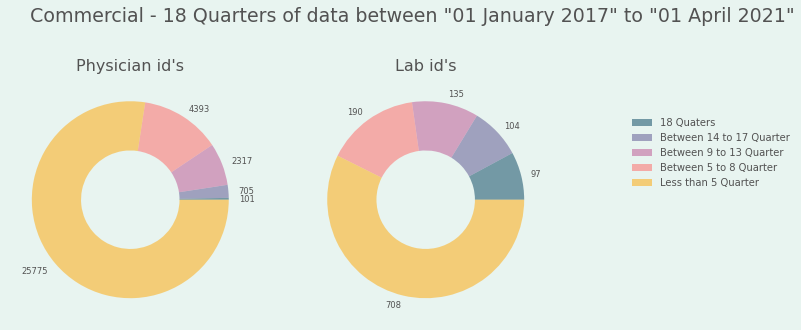

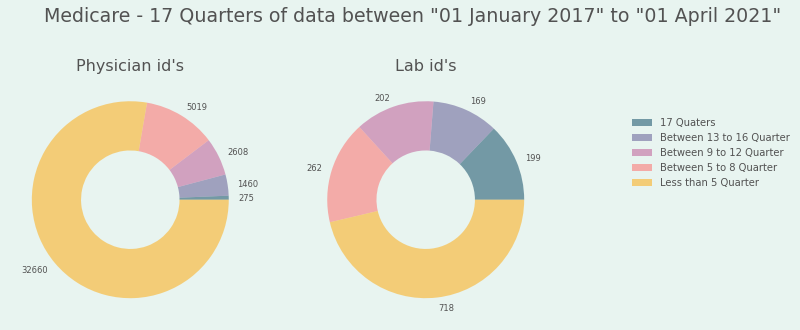

In [34]:
# Donut chart 

font_color = '#525252'
#colors = ['#99ff99', '#66b3ff', '#c7b3fb','#ff6666', '#f9c3b7','#ffb3e6']

colors=['#003f5c','#58508d','#bc5090','#ff6361','#ffa600']
fig, axes = plt.subplots(1, 3, figsize=(15,6), facecolor='#e8f4f0')
fig.delaxes(ax= axes[2])

comm_data = new_data[new_data.type == 'COMMERCIAL']
medi_data = new_data[new_data.type == 'MEDICARE']

def plotDonut(data,ax,title):
  ax =ax
  ax.pie(data,
       labels=data,
       wedgeprops=dict(width=.5,alpha=0.5),
       colors=colors,
       textprops={'color':font_color})
  ax.set_title(title, fontsize=16, color=font_color)

def plotlegend(data):
  legend = plt.legend(data, 
                        bbox_to_anchor=(1.3, .87), # Legend position
                        loc='upper left',  
                        ncol=1, 
                        fancybox=True)
  for text in legend.get_texts():
      plt.setp(text, color=font_color) # Legend font color


plotDonut(comm_data[comm_data.source == 'Physician']['Q_count'],axes[0],"Physician id's")
plotDonut(comm_data[comm_data.source == 'lab']['Q_count'],axes[1],"Lab id's")
plotlegend(comm_data[comm_data.source == 'lab']['Q_name'])
title = fig.suptitle(f'Commercial - {quat+1} Quarters of data between "{min}" to "{max}"', 
                     y=.95, fontsize=19, color=font_color)
fig.subplots_adjust(wspace=.2)


fig, axes = plt.subplots(1, 3, figsize=(15,6), facecolor='#e8f4f0')
fig.delaxes(ax= axes[2])
plotDonut(medi_data[comm_data.source == 'Physician']['Q_count'],axes[0],"Physician id's")
plotDonut(medi_data[comm_data.source == 'lab']['Q_count'],axes[1],"Lab id's")
plotlegend(medi_data[comm_data.source == 'lab']['Q_name'])
title = fig.suptitle(f'Medicare - {quat} Quarters of data between "{min}" to "{max}"', 
                     y=.95, fontsize=19, color=font_color)
fig.subplots_adjust(wspace=.2)

# Visualization on Reports and Volumes 

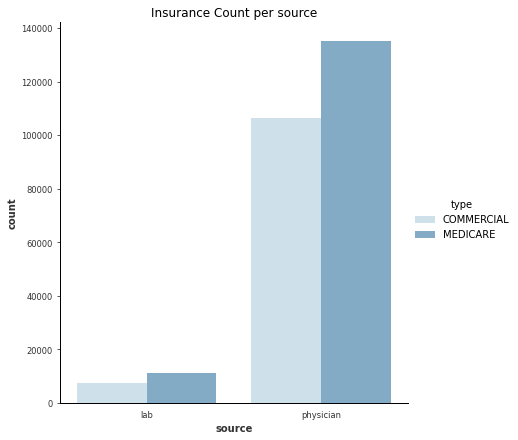

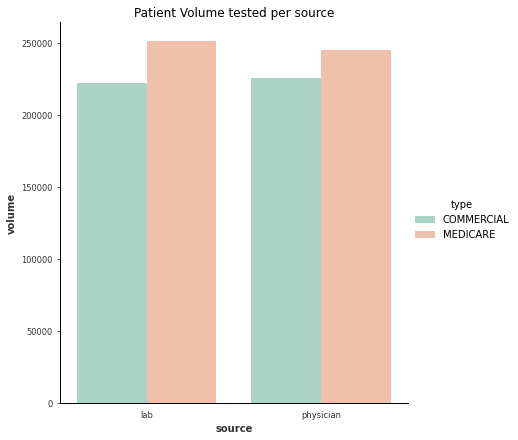

In [35]:
import seaborn as sns


count_data = pd.DataFrame(data_copy.groupby(['source','type'])['id'].count().reset_index().rename(columns={'id': 'count'}))
p=sns.catplot(
    data=count_data, kind="bar",
    x="source", y='count',hue="type",
    palette="Paired", alpha=.6, height=6
)
p.set(title ="Insurance Count per source")


volume_data = pd.DataFrame(data_copy.groupby(['source','type'])['volume'].sum().reset_index())
p=sns.catplot(
    data=volume_data, kind="bar",
    x="source", y='volume',hue="type",
    palette="Set2", alpha=.6, height=6
)
p.set(title ="Patient Volume tested per source")

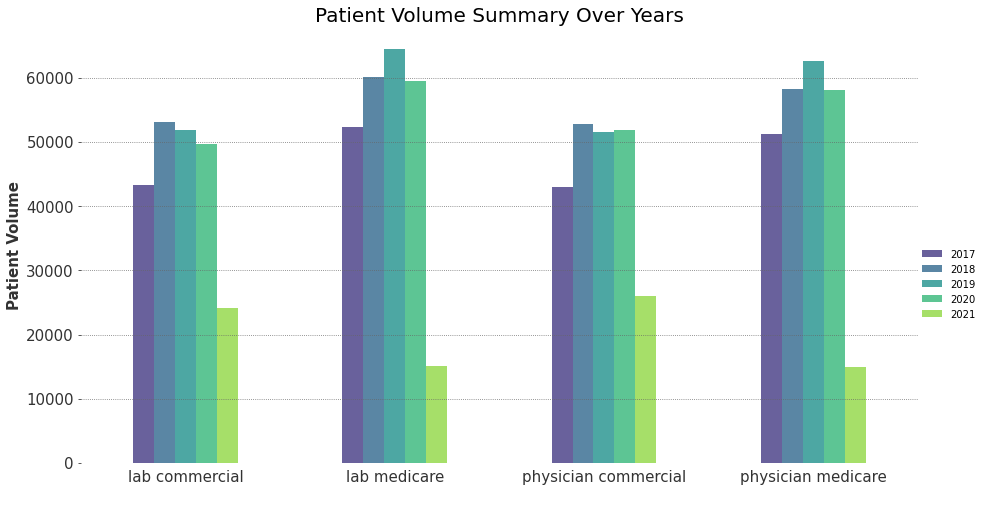

In [36]:
col = sns.color_palette("viridis", 5)
copy = data_copy[['type','year','quarter','volume','source']]
yearly = pd.DataFrame(copy.groupby(['source','type','year'])['volume'].sum()).reset_index()
yearly['source'] = yearly['source']+" "+ yearly['type'].str.lower()
yearly = yearly[['source','year','volume']]
yearly_pi = yearly.pivot(index='source',columns='year',values='volume')
yearly_pi.plot(kind='bar',figsize=(15,8),alpha=0.80, rot=0, fontsize=15,color = col)
plt.xlabel(" ")
plt.ylabel("Patient Volume", fontsize=15)
plt.title("Patient Volume Summary Over Years", fontsize=20)
plt.grid(b=True, which='major', axis='y', color='#666666', linestyle=':')
plt.legend(bbox_to_anchor=(1,0.5), loc="upper left", borderaxespad=0)

# Plotting Time Series before any data imputation and 

In [37]:
import plotly.graph_objects as go
fig = go.Figure()
# pd.tseries.offsets.QuarterBegin()
complete = data_copy['volume'].resample('Q').sum()
complete.index = np.unique(data_copy.index)
#complete['date']=(pd.PeriodIndex(complete['date'], freq='Q').to_timestamp())+pd.tseries.offsets.QuarterBegin()

fig.add_trace(go.Scatter(x=list(complete.index), y=list(complete),name="Physician Medicare")) 
fig.update_layout(
    title_text="Total volumes of patients over the years"
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,label="1y",step="year",stepmode="backward"),
                dict(count=2,label="2y",step="year",stepmode="backward"),
                dict(count=3,label="3y",step="year",stepmode="backward"),
                dict(count=4,label="4y",step="year",stepmode="backward"),
                dict(count=5,label="5y",step="year",stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True
        ),
        type="date"
    )
)

In [38]:
data_copy1 = data_copy.copy()
data_copy1['type'] = np.where(data_copy1['type'] == 'COMMERCIAL','C','M')
data_copy1['source'] = np.where(data_copy1['source'] == 'lab','L','P')
data_copy1 = data_copy1[['id','type','volume','source']]

lab_comm=data_copy[(data_copy['type']=='C') & (data_copy['source'] == 'L')][['volume']].resample('Q').sum()
lab_medi=data_copy[(data_copy['type']=='M') & (data_copy['source'] == 'L')][['volume']].resample('Q').sum()
phy_comm=data_copy[(data_copy['type']=='C') & (data_copy['source'] == 'P')][['volume']].resample('Q').sum()
phy_medi=data_copy[(data_copy['type']=='M') & (data_copy['source'] == 'P')][['volume']].resample('Q').sum()



def plotIndividualPlot(data_copy):
  lab_comm=data_copy[(data_copy['type']=='C') & (data_copy['source'] == 'L')][['volume']].resample('Q').sum()
  lab_medi=data_copy[(data_copy['type']=='M') & (data_copy['source'] == 'L')][['volume']].resample('Q').sum()
  phy_comm=data_copy[(data_copy['type']=='C') & (data_copy['source'] == 'P')][['volume']].resample('Q').sum()
  phy_medi=data_copy[(data_copy['type']=='M') & (data_copy['source'] == 'P')][['volume']].resample('Q').sum()
  lab_comm.index = np.unique(data_copy.index)
  lab_medi.index = np.unique(data_copy.index)[:-1]
  phy_comm.index = np.unique(data_copy.index)
  phy_medi.index = np.unique(data_copy.index)[:-1]
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=list(phy_medi.index), y=list(phy_medi['volume']),name="Physician Medicare",)) 
  fig.add_trace(go.Scatter(x=list(lab_medi.index), y=list(lab_medi['volume']),name="Lab Medicare")) 
  fig.add_trace(go.Scatter(x=list(phy_comm.index), y=list(phy_comm['volume']),name="Physician Commercial")) 
  fig.add_trace(go.Scatter(x=list(lab_comm.index), y=list(lab_comm['volume']),name="Lab Commercial"))
  fig.update_layout(
      title_text="Total volumes of patients every Quater Over the years"
  )

  fig.update_layout(
      xaxis=dict(
          rangeselector=dict(
              buttons=list([
                  dict(count=1,label="1y",step="year",stepmode="backward"),
                  dict(count=2,label="2y",step="year",stepmode="backward"),
                  dict(count=3,label="3y",step="year",stepmode="backward"),
                  dict(count=4,label="4y",step="year",stepmode="backward"),
                  dict(count=5,label="5y",step="year",stepmode="backward"),
                  dict(step="all")
              ])
          ),
          rangeslider=dict(visible=True
          ),
          type="date"
      )
  )
  fig.show()

plotIndividualPlot(data_copy1)



# Data count

In [39]:
count_data = new_data[['source','type','Q_info','Q_count']].copy()
count_data['type'] = np.where(count_data['type'] == 'COMMERCIAL','C','M')
count_data['source'] = np.where(count_data['source'] == 'lab','L','P')
count_data = count_data.reset_index(drop=True)
count_data.to_csv('./data/count_data.csv')

final_count=pd.DataFrame(columns=['source', 'type', 'Q_info', 'Q_count','id'])
for s in np.unique(data_copy1.source):
      for t in np.unique(data_copy1.type):
        id_count = data_copy1[(data_copy1.type==t) & (data_copy1.source==s)][['id','volume']].reset_index(drop=True).groupby('id').count().reset_index()
        if (t == 'M'):
          l1 = [id_count[id_count.volume==17]['id'].reset_index(drop=True)]
          l2 = [id_count[(id_count.volume>=13)&(id_count.volume<=16)]['id'].reset_index(drop=True)]
          l3 = [id_count[(id_count.volume>=9)&(id_count.volume<=12)]['id'].reset_index(drop=True)]
          l4 = [id_count[(id_count.volume>=5)&(id_count.volume<=8)]['id'].reset_index(drop=True)]
          l5 = [id_count[(id_count.volume<5)]['id'].reset_index(drop=True)]
          l=[l1,l2,l3,l4,l5]
        if (t == 'C'):
          l1 = [id_count[id_count.volume==18]['id'].reset_index(drop=True)]
          l2 = [id_count[(id_count.volume>=14)&(id_count.volume<=17)]['id'].reset_index(drop=True)]
          l3 = [id_count[(id_count.volume>=9)&(id_count.volume<=13)]['id'].reset_index(drop=True)]
          l4 = [id_count[(id_count.volume>=5)&(id_count.volume<=8)]['id'].reset_index(drop=True)]
          l5 = [id_count[(id_count.volume<5)]['id'].reset_index(drop=True)]
          l=[l1,l2,l3,l4,l5]

        temp = count_data[(count_data.type==t) & (count_data.source==s)]

        temp['id']=l
        final_count = final_count.append(temp,ignore_index=True)

In [40]:
# Verifying if the covid impact is there for all kind of data

from itertools import chain
def plotSeparate(id_data,data):
  id = sum(id_data['id'],[])
  output = []
  for i in id:
    for j in i:
      output.append(j)
  temp = data[data.id.isin(output)]
  plotIndividualPlot(temp)

# Remove covid noises for 100% data
plotSeparate(final_count[final_count.Q_info == 100],data_copy1)
plotSeparate(final_count[final_count.Q_info == 75],data_copy1)
plotSeparate(final_count[final_count.Q_info == 50],data_copy1)
plotSeparate(final_count[final_count.Q_info == 25],data_copy1)
plotSeparate(final_count[final_count.Q_info == 5],data_copy1)

# Imputation

In [15]:
# Method to return time series by updating NA for missing values

def getTsWithNa(id,s,t):
  idx = (pd.PeriodIndex(np.unique(data_copy1.index), freq='Q').to_timestamp())
  if np.unique(t == 'M'):
      idx = idx[:-1]
  temp = data_copy1[data_copy1.id==id]
  temp1 = temp.reindex(idx, fill_value=np.nan)
  temp1['id'],temp1['source'],temp1['type']  = id, s, t
  return temp1

def getTs(id,s,t):
  return data_copy1[(data_copy1.source==s)&(data_copy1.type==t)&(data_copy1.id==id)]

In [16]:
# Remove covid noise from the data with rolling mean for 100% data
data_copy2 = data_copy1.copy()
noiseDate='2020-04-01'
def updateDataCopy1(vol,id,s,t,data):
  new=vol[vol.index==noiseDate].values
  old=data[(data.id==id)&(data.source==s)&(data.type==t)&(data.index==noiseDate)]['volume'].values
  if new > old:
    data.loc[(data.id==id)&(data.source==s)&(data.type==t)&(data.index==noiseDate),['volume']] = vol[vol.index==noiseDate]

def removeCovidNoise(data,dc):
  lc = sum(data[(data.source=='L')&(data.type=='C')]['id'],[])
  lm = sum(data[(data.source=='L')&(data.type=='M')]['id'],[])
  pc = sum(data[(data.source=='P')&(data.type=='C')]['id'],[])
  pm = sum(data[(data.source=='P')&(data.type=='M')]['id'],[])
  for i,sub_data in enumerate([lc,lm,pc,pm]):
    print("Updating....")
    for id in sub_data[0]:
      if (i==0):
        roll_data = getTs(id,'L','C')
        roll_data['roll_vol'] = roll_data['volume'].rolling(window=5,min_periods=1).mean().astype(np.int32)
        updateDataCopy1(roll_data['roll_vol'],id,'L','C',dc)
      elif (i==1):
        roll_data = getTs(id,'L','M')
        roll_data['roll_vol'] = roll_data['volume'].rolling(window=5,min_periods=1).mean().astype(np.int32)
        updateDataCopy1(roll_data['roll_vol'],id,'L','M',dc)
      elif (i==2):
        roll_data = getTs(id,'P','C')
        roll_data['roll_vol'] = roll_data['volume'].rolling(window=5,min_periods=1).mean().astype(np.int32)
        updateDataCopy1(roll_data['roll_vol'],id,'P','C',dc)
      else:
        roll_data = getTs(id,'P','M')
        roll_data['roll_vol'] = roll_data['volume'].rolling(window=5,min_periods=1).mean().astype(np.int32)
        updateDataCopy1(roll_data['roll_vol'],id,'P','M',dc) 


# Remove covid noises for 100% data and replaced with data copy 2
removeCovidNoise(final_count[final_count.Q_info == 100],data_copy2)

Updating....
Updating....
Updating....
Updating....


In [17]:
#Verification
print(data_copy1[(data_copy1.id==56227)&(data_copy1.index ==noiseDate)&(data_copy1.type =='C')])
print(data_copy2[(data_copy2.id==56227)&(data_copy2.index ==noiseDate)&(data_copy2.type =='C')])
print(data_copy1[(data_copy1.id==56214)&(data_copy1.index ==noiseDate)&(data_copy1.type =='M')])
print(data_copy2[(data_copy2.id==56214)&(data_copy2.index ==noiseDate)&(data_copy2.type =='M')])
print(data_copy1[(data_copy1.id==1003906884)&(data_copy1.index ==noiseDate)&(data_copy1.type =='C')])
print(data_copy2[(data_copy2.id==1003906884)&(data_copy2.index ==noiseDate)&(data_copy2.type =='C')])
print(data_copy1[(data_copy1.id==1003852419)&(data_copy1.index ==noiseDate)&(data_copy1.type =='M')])
print(data_copy2[(data_copy2.id==1003852419)&(data_copy2.index ==noiseDate)&(data_copy2.type =='M')])

               id type  volume source
date                                 
2020-04-01  56227    C      39      L
               id type  volume source
date                                 
2020-04-01  56227    C      49      L
               id type  volume source
date                                 
2020-04-01  56214    M       5      L
               id type  volume source
date                                 
2020-04-01  56214    M       5      L
                    id type  volume source
date                                      
2020-04-01  1003906884    C      13      P
                    id type  volume source
date                                      
2020-04-01  1003906884    C      13      P
                    id type  volume source
date                                      
2020-04-01  1003852419    M       1      P
                    id type  volume source
date                                      
2020-04-01  1003852419    M       4      P


# Identifying the best imputaion technique using 100% availaible data

In [18]:
import random
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error

index = np.unique(data_copy2.index)

random.seed(0)
def getRandomData(data,s,t,count):
  rand_id = random.sample(list(sum(data[(data.source==s)&(data.type==t)]['id'],[])[0]),count)
  rand_volume=pd.DataFrame()
  for i in rand_id:
    rand_volume[i] = data_copy2[(data_copy2.source==s)&(data_copy2.type==t)&(data_copy2.id==i)]['volume']
  return rand_volume

rng = np.random.RandomState(0)
def addRandomNan(y,nan_size):
  data=y.copy()
  size,feature= data.shape
  data.columns = np.arange(feature)
  for i in range(feature):
    missing_features = rng.choice(size, nan_size, replace=False)
    data.iloc[missing_features, i] = np.nan
  return data

def performImputation(s,t,index):
  predict_df = {}
  predict_df_test = {}
  y_train = getRandomData(final_count[final_count.Q_info == 100],s,t,30)
  predict_df['Actual'] = y_train
  
  X_train = addRandomNan(y_train,4)
  y_test = getRandomData(final_count[final_count.Q_info == 100],s,t,30)
  predict_df_test['Actual'] = y_test
  X_test = addRandomNan(y_test,4)
  imputer_model=pd.DataFrame()
  score_simple_imputer = pd.DataFrame()
  # estimators = [KNeighborsRegressor(n_neighbors=8)]
  estimators = [DecisionTreeRegressor(),
                ExtraTreesRegressor(),
                KNeighborsRegressor(n_neighbors=6)]
  train_model_error=pd.DataFrame()
  test_model_error=pd.DataFrame()
  # Complex Imputers
  for est in estimators:
    imp = IterativeImputer(estimator=est,verbose=2,max_iter=15,tol=1e-10,imputation_order='roman')
    ytrain_bar = np.ceil(imp.fit_transform(X_train))
    ytrain_bar=pd.DataFrame(ytrain_bar,index=index)
    ytest_bar=np.ceil(imp.transform(X_test))
    ytrain_bar = ytrain_bar.astype('int')
    ytest_bar=pd.DataFrame(ytest_bar,index=index)
    predict_df[est.__class__.__name__] = pd.DataFrame(ytrain_bar,index=index)
    predict_df_test[est.__class__.__name__] = pd.DataFrame(ytest_bar,index=index)
    train_model_error = train_model_error.append([[est.__class__.__name__,np.sqrt(mean_squared_error(y_train,ytrain_bar))]])
    test_model_error = test_model_error.append([[est.__class__.__name__,np.sqrt(mean_squared_error(y_test,ytest_bar))]])
  
  # # Simple Imputer
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  ytrain_bar=np.ceil(imp.fit_transform(X_train)).astype('int')
  ytest_bar=np.ceil(imp.transform(X_test)).astype('int')
  train_model_error = train_model_error.append([["Simple Mean",np.sqrt(mean_squared_error(y_train,ytrain_bar))]])
  test_model_error = test_model_error.append([["Simple Mean",np.sqrt(mean_squared_error(y_test,ytest_bar))]])
  imputer_model = imputer_model.append([["Simple Mean",imp]])
  predict_df["Simple Mean"] = pd.DataFrame(ytrain_bar,index=index)
  predict_df_test["Simple Mean"] = pd.DataFrame(ytest_bar,index=index)

  # filling imputer
  for i in range(4):
    ytrain_bar = X_train.fillna(X_train.rolling(window=4,min_periods=1).mean())
    ytrain_bar=ytrain_bar.fillna(method='ffill')
    ytrain_bar=ytrain_bar.fillna(method='bfill')
    ytrain_bar = ytrain_bar.astype('int')
  for i in range(4):
    ytest_bar = X_test.fillna(X_test.rolling(window=4,min_periods=1).mean())
    ytest_bar=ytest_bar.fillna(method='ffill')
    ytest_bar=ytest_bar.fillna(method='bfill')
    ytest_bar = ytest_bar.astype('int')
  y_train.columns,y_test.columns = np.arange(y_train.shape[1]),np.arange(y_test.shape[1])
  predict_df["RollMean+FwdFill+BckFill"] = pd.DataFrame(ytrain_bar,index=index)
  predict_df_test["RollMean+FwdFill+BckFill"] = pd.DataFrame(ytest_bar,index=index)
  train_model_error = train_model_error.append([["RollMean+FwdFill+BckFill",np.sqrt(mean_squared_error(y_train,ytrain_bar))]])
  test_model_error = test_model_error.append([["RollMean+FwdFill+BckFill",np.sqrt(mean_squared_error(y_test,ytest_bar))]])
  return train_model_error,test_model_error,predict_df,predict_df_test

lc_imp_train,lc_imp_test,lc_predict,lc_predict_test= performImputation('L','C',index)
lm_imp_train,lm_imp_test,lm_predict,lm_predict_test = performImputation('L','M',index[:-1])
pc_imp_train,pc_imp_test,pc_predict,pc_predict_test= performImputation('P','C',index)
pm_imp_train,pm_imp_test,pc_predict,pc_predict_test  = performImputation('P','M',index[:-1])

[IterativeImputer] Completing matrix with shape (18, 30)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.02
[IterativeImputer] Change: 671.5714285714286, scaled tolerance: 1.293e-07 
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.03
[IterativeImputer] Change: 950.0, scaled tolerance: 1.293e-07 
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.05
[IterativeImputer] Change: 385.0, scaled tolerance: 1.293e-07 
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.07
[IterativeImputer] Change: 550.0, scaled tolerance: 1.293e-07 
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.08
[IterativeImputer] Change: 229.0, scaled tolerance: 1.293e-07 
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.10
[IterativeImputer] Change: 378.0, scaled tolerance: 1.293e-07 
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.12
[IterativeImputer] Change: 296.0, scaled tolerance: 1.293e-07 
[IterativeImputer] En

[IterativeImputer] Ending imputation round 13/15, elapsed time 0.20
[IterativeImputer] Change: 45.0, scaled tolerance: 1.52e-08 
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.22
[IterativeImputer] Change: 75.0, scaled tolerance: 1.52e-08 
[IterativeImputer] Ending imputation round 15/15, elapsed time 0.23
[IterativeImputer] Change: 86.0, scaled tolerance: 1.52e-08 
[IterativeImputer] Completing matrix with shape (17, 30)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.02
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.03
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.04
[IterativeImputer] E

[IterativeImputer] Ending imputation round 1/15, elapsed time 1.94
[IterativeImputer] Change: 21.61428571428571, scaled tolerance: 4e-09 
[IterativeImputer] Ending imputation round 2/15, elapsed time 3.89
[IterativeImputer] Change: 10.560000000000002, scaled tolerance: 4e-09 
[IterativeImputer] Ending imputation round 3/15, elapsed time 5.83
[IterativeImputer] Change: 4.729999999999999, scaled tolerance: 4e-09 
[IterativeImputer] Ending imputation round 4/15, elapsed time 7.76
[IterativeImputer] Change: 5.28, scaled tolerance: 4e-09 
[IterativeImputer] Ending imputation round 5/15, elapsed time 9.69
[IterativeImputer] Change: 4.169999999999999, scaled tolerance: 4e-09 
[IterativeImputer] Ending imputation round 6/15, elapsed time 11.63
[IterativeImputer] Change: 4.62, scaled tolerance: 4e-09 
[IterativeImputer] Ending imputation round 7/15, elapsed time 13.57
[IterativeImputer] Change: 4.699999999999999, scaled tolerance: 4e-09 
[IterativeImputer] Ending imputation round 8/15, elapsed 

[IterativeImputer] Ending imputation round 9/15, elapsed time 17.31
[IterativeImputer] Change: 4.2700000000000005, scaled tolerance: 2.6e-09 
[IterativeImputer] Ending imputation round 10/15, elapsed time 19.27
[IterativeImputer] Change: 4.04, scaled tolerance: 2.6e-09 
[IterativeImputer] Ending imputation round 11/15, elapsed time 21.16
[IterativeImputer] Change: 3.190000000000001, scaled tolerance: 2.6e-09 
[IterativeImputer] Ending imputation round 12/15, elapsed time 23.06
[IterativeImputer] Change: 3.2499999999999973, scaled tolerance: 2.6e-09 
[IterativeImputer] Ending imputation round 13/15, elapsed time 24.95
[IterativeImputer] Change: 4.009999999999999, scaled tolerance: 2.6e-09 
[IterativeImputer] Ending imputation round 14/15, elapsed time 26.86
[IterativeImputer] Change: 4.169999999999999, scaled tolerance: 2.6e-09 
[IterativeImputer] Ending imputation round 15/15, elapsed time 28.77
[IterativeImputer] Change: 3.4099999999999984, scaled tolerance: 2.6e-09 
[IterativeImputer

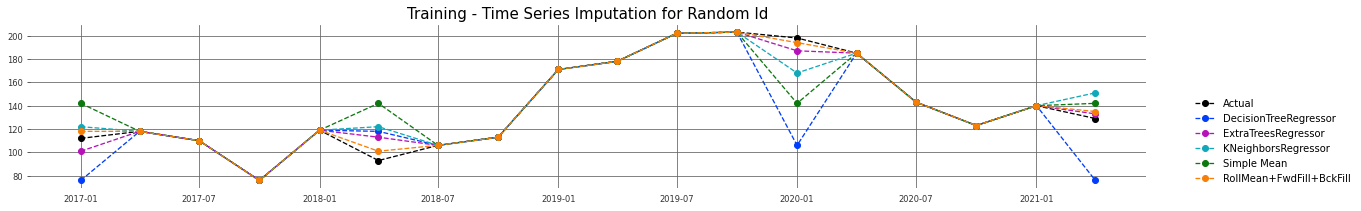

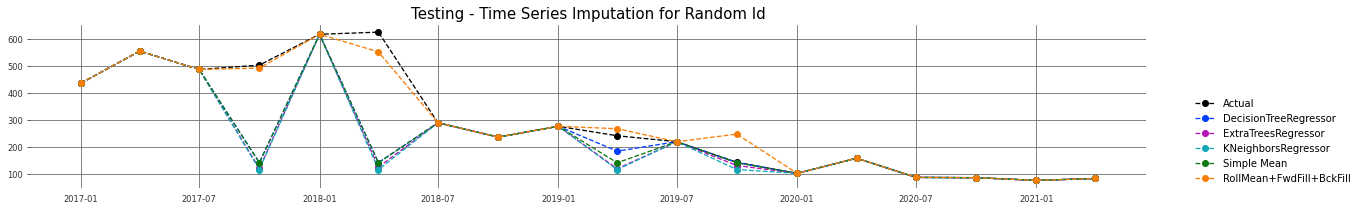

In [19]:
# Verifying the best Imputation
plt.figure(figsize=(20,3))
for name, value in lc_predict.items():
  plt.plot(value[12],"--",marker='o',label=name)
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title("Training - Time Series Imputation for Random Id",fontsize=15)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)

plt.figure(figsize=(20,3))
for name, value in lc_predict_test.items():
  plt.plot(value[12],"--",marker='o',label=name)
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title("Testing - Time Series Imputation for Random Id",fontsize=15)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)



In [20]:
pm_imp_test

0         1
0     DecisionTreeRegressor  3.387115
0       ExtraTreesRegressor  3.018245
0       KNeighborsRegressor  2.815225
0               Simple Mean  2.736106
0  RollMean+FwdFill+BckFill  1.523026

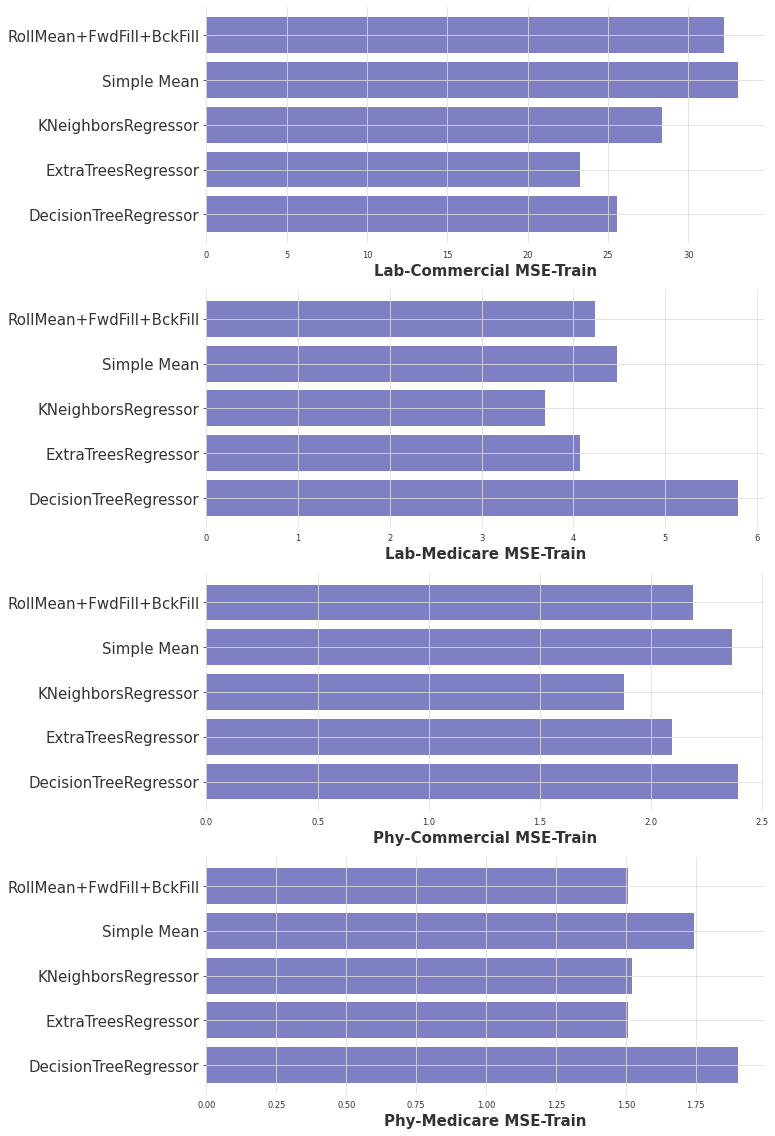

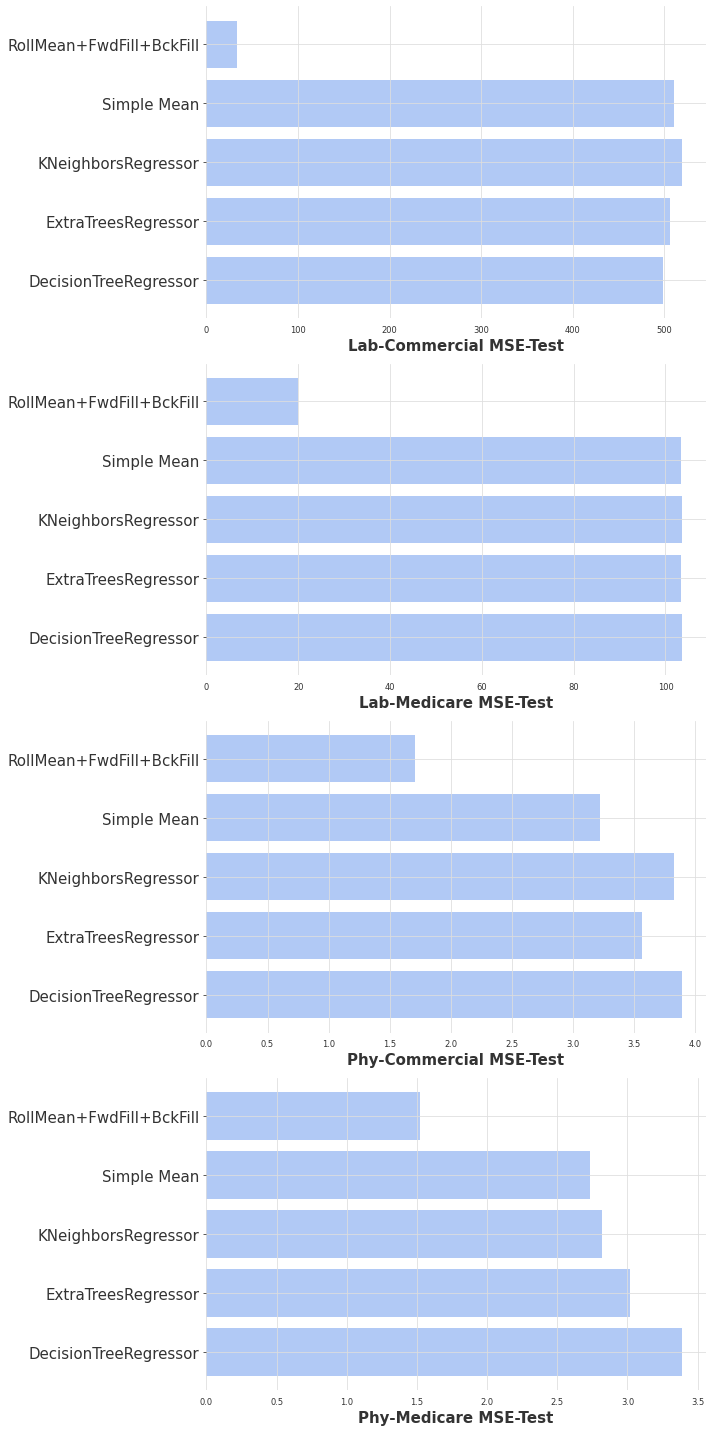

In [21]:
imp_train=[lc_imp_train,lm_imp_train,pc_imp_train,pm_imp_train]
error_text=["Lab-Commercial MSE","Lab-Medicare MSE","Phy-Commercial MSE","Phy-Medicare MSE"]
imp_test=[lc_imp_test,lm_imp_test,pc_imp_test,pm_imp_test]


def plotError(data,c,val):
  fig, ax = plt.subplots(4,1,figsize=(10,20))
  for i,(error,text) in enumerate(zip(data,error_text)):
    ax[i].barh(error.iloc[:,0],error.iloc[:,1],color=c,alpha=0.5)
    ax[i].set_xlabel(text+"-"+val,fontsize=15)
    plt.setp(ax[i].get_yticklabels(), fontsize=15)

plotError(imp_train,'darkblue',"Train")
plotError(imp_test,'cornflowerblue',"Test")
plt.tight_layout()

# Imputation on 75% and 50% availaible data

In [22]:
#Working do not delete
data_copy3 = data_copy2.copy()

def getTsWithNa(id,s,t):
  idx = (pd.PeriodIndex(np.unique(data_copy1.index), freq='Q').to_timestamp())
  if np.unique(t == 'M'):
      idx = idx[:-1]
  temp = data_copy1[(data_copy1.id==id)&(data_copy1.source==s)&(data_copy1.type==t)]
  temp1 = temp.reindex(idx, fill_value=np.nan)
  temp1['id'],temp1['source'],temp1['type']  = id, s, t
  return temp1

def performFinalImputation(data,s,t,n):
  for i in range(n):
    ybar = data.fillna(data.rolling(window=4,min_periods=1).mean())
    ybar=ybar.fillna(method='ffill')
    ybar=ybar.fillna(method='bfill')
  ybar=ybar.astype('int')
  return ybar
  

def applyImputation(data,n):
  lc = sum(data[(data.source=='L')&(data.type=='C')]['id'],[])
  lm = sum(data[(data.source=='L')&(data.type=='M')]['id'],[])
  pc = sum(data[(data.source=='P')&(data.type=='C')]['id'],[])
  pm = sum(data[(data.source=='P')&(data.type=='M')]['id'],[])
  newData = pd.DataFrame()
  for i,sub_data in enumerate([lc,lm,pc,pm]):
    count=0
    print("**********************************")
    for id in sub_data[0]:
      count=count+1
      if (i==0):
        na_data = getTsWithNa(id,'L','C')
        ind = na_data.loc[pd.isna(na_data["volume"]), :].index
        # print(list(ind))
        na_data['volume'] = performFinalImputation(na_data['volume'],'L','C',n)
      elif (i==1):
        na_data = getTsWithNa(id,'L','M')
        ind = na_data.loc[pd.isna(na_data["volume"]), :].index
        # print(list(ind))
        na_data['volume'] = performFinalImputation(na_data['volume'],'L','M',n)
      elif (i==2):
        na_data = getTsWithNa(id,'P','C')
        ind = na_data.loc[pd.isna(na_data["volume"]), :].index
        # print(list(ind))
        na_data['volume'] = performFinalImputation(na_data['volume'],'P','C',n)
      else:
        na_data = getTsWithNa(id,'P','M')
        ind = na_data.loc[pd.isna(na_data["volume"]), :].index
        # print(list(ind))
        na_data['volume'] = performFinalImputation(na_data['volume'],'P','M',n)
      temp = na_data[na_data.index.isin(list(ind))]
      newData = pd.concat([newData,temp])
    print(f"Imputation Performed on {count} id's")
  return newData

newImpData_75 = applyImputation(final_count[final_count.Q_info == 75],4)
newImpData_50 = applyImputation(final_count[final_count.Q_info == 50],8)

**********************************
Imputation Performed on 104 id's
**********************************
Imputation Performed on 169 id's
**********************************
Imputation Performed on 705 id's
**********************************
Imputation Performed on 1460 id's
**********************************
Imputation Performed on 135 id's
**********************************
Imputation Performed on 202 id's
**********************************
Imputation Performed on 2317 id's
**********************************
Imputation Performed on 2608 id's


In [23]:
data_copy3 = data_copy3.append(newImpData_75)
data_copy3 = data_copy3.append(newImpData_50)
#Verification
data_copy3.shape[0] == newImpData_50.shape[0] + newImpData_75.shape[0] + data_copy2.shape[0]

True

In [24]:
#Verification of data imputation nan
print(data_copy2[(data_copy2.id==57278)&(data_copy2.type =='C')])
print(data_copy3[(data_copy3.id==57278)&(data_copy3.type =='C')])
print(data_copy2[(data_copy2.id==56209)&(data_copy2.type =='M')])
print(data_copy3[(data_copy3.id==56209)&(data_copy3.type =='M')])
print(data_copy2[(data_copy2.id==1003087768)&(data_copy2.type =='C')])
print(data_copy3[(data_copy3.id==1003087768)&(data_copy3.type =='C')])
print(data_copy2[(data_copy2.id==1003049610)&(data_copy2.type =='M')])
print(data_copy3[(data_copy3.id==1003049610)&(data_copy3.type =='M')])

               id type  volume source
date                                 
2017-01-01  57278    C      18      L
2017-04-01  57278    C      26      L
2017-07-01  57278    C      28      L
2017-10-01  57278    C      24      L
2018-01-01  57278    C      30      L
2018-04-01  57278    C      25      L
2018-07-01  57278    C       8      L
2018-10-01  57278    C       6      L
2019-01-01  57278    C       6      L
2019-04-01  57278    C       5      L
2019-07-01  57278    C       6      L
2019-10-01  57278    C       1      L
2020-01-01  57278    C       6      L
2020-04-01  57278    C       2      L
2020-07-01  57278    C       7      L
2020-10-01  57278    C       4      L
2021-01-01  57278    C       2      L
               id type  volume source
2017-01-01  57278    C      18      L
2017-04-01  57278    C      26      L
2017-07-01  57278    C      28      L
2017-10-01  57278    C      24      L
2018-01-01  57278    C      30      L
2018-04-01  57278    C      25      L
2018-07-01  

In [25]:
removeCovidNoise(final_count[final_count.Q_info == 75],data_copy3)
removeCovidNoise(final_count[final_count.Q_info == 50],data_copy3)

#Verification of noise removal
print(data_copy2[(data_copy2.id==57278)&(data_copy2.index ==noiseDate)&(data_copy2.type =='C')])
print(data_copy3[(data_copy3.id==57278)&(data_copy3.index ==noiseDate)&(data_copy3.type =='C')])
print(data_copy2[(data_copy2.id==56209)&(data_copy2.index ==noiseDate)&(data_copy2.type =='M')])
print(data_copy3[(data_copy3.id==56209)&(data_copy3.index ==noiseDate)&(data_copy3.type =='M')])
print(data_copy2[(data_copy2.id==1003087768)&(data_copy2.index ==noiseDate)&(data_copy2.type =='C')])
print(data_copy3[(data_copy3.id==1003087768)&(data_copy3.index ==noiseDate)&(data_copy3.type =='C')])
print(data_copy2[(data_copy2.id==1003049610)&(data_copy2.index ==noiseDate)&(data_copy2.type =='M')])
print(data_copy3[(data_copy3.id==1003049610)&(data_copy3.index ==noiseDate)&(data_copy3.type =='M')])

#Verification of noise removal
print(data_copy2[(data_copy2.id==56279)&(data_copy2.index ==noiseDate)&(data_copy2.type =='C')])
print(data_copy3[(data_copy3.id==56279)&(data_copy3.index ==noiseDate)&(data_copy3.type =='C')])
print(data_copy2[(data_copy2.id==56361)&(data_copy2.index ==noiseDate)&(data_copy2.type =='M')])
print(data_copy3[(data_copy3.id==56361)&(data_copy3.index ==noiseDate)&(data_copy3.type =='M')])
print(data_copy2[(data_copy2.id==1003050972)&(data_copy2.index ==noiseDate)&(data_copy2.type =='C')])
print(data_copy3[(data_copy3.id==1003050972)&(data_copy3.index ==noiseDate)&(data_copy3.type =='C')])
print(data_copy2[(data_copy2.id==1003055302)&(data_copy2.index ==noiseDate)&(data_copy2.type =='M')])
print(data_copy3[(data_copy3.id==1003055302)&(data_copy3.index ==noiseDate)&(data_copy3.type =='M')])

Updating....
Updating....
Updating....
Updating....
Updating....
Updating....
Updating....
Updating....
               id type  volume source
date                                 
2020-04-01  57278    C       2      L
               id type  volume source
2020-04-01  57278    C       4      L
               id type  volume source
date                                 
2020-04-01  56209    M       6      L
               id type  volume source
2020-04-01  56209    M      12      L
Empty DataFrame
Columns: [id, type, volume, source]
Index: []
                    id type  volume source
2020-04-01  1003087768    C       2      P
Empty DataFrame
Columns: [id, type, volume, source]
Index: []
                    id type  volume source
2020-04-01  1003049610    M       1      P
               id type  volume source
date                                 
2020-04-01  56279    C       2      L
               id type  volume source
2020-04-01  56279    C       2      L
               id type  volume

In [27]:
data_copy4 = pd.DataFrame()
for s,t in zip(['L','L','P','P'],['C','M','C','M']):
    for c in [100,75,50]:
        id = final_count[(final_count.Q_info==c)&
                         (final_count.source==s)&
                         (final_count.type==t)]['id']     
        id1 = id.reset_index(drop=True)[0]
        d=data_copy3[data_copy3.id.isin(id1[0])&(data_copy3.source==s)&(data_copy3.type==t)]
        data_copy4 = pd.concat([data_copy4,d],axis=0)

data_copy4 = data_copy4.sort_index()
data_copy4.index = pd.to_datetime(data_copy4.index)


In [ ]:

final_count.to_csv('./data/final_count.csv')
data_copy3.to_csv('./data/data_copy3.csv')
data_copy2.to_csv('./data/data_copy2.csv')
data_copy4.to_csv('./data/data_copy4.csv')
data_copy1.to_csv('./data/data_copy1.csv')

In [28]:
plotIndividualPlot(data_copy4)

# Stationary Check

In [38]:
# # Verifying the Stationary 
# # KPSS test
# Null Hypothesis --> Series is Stationary
# Alternate Hypothesis --> Series is not Stationary

from statsmodels.tsa.stattools import kpss

def kpssTestIndividual(data_copy):
  for s in np.unique(data_copy.source):
      source = 'Lab' if s == 'L' else 'Physician'
      for t in np.unique(data_copy.type):
          type = 'Medicare' if t == 'M' else 'Commercial'
          print("--------------------------------------------------")
          print(f"KPSS test for {source} for {type} records")
          print("--------------------------------------------------")
          sample = data_copy[(data_copy.type == t) & (data_copy.source==s)]['volume'].resample('Q').sum()
          stats,p,lags,critical_values = kpss(sample, 'ct')
          print(f'Test statistics: {stats}')
          print(f'p Value: {p}')
          print(f'Critical Value: {critical_values}')
          if p<0.05:
              print("Series is not Stationary")
          else:
              print("Series is Stationary")

def kpssTestComplete(data_copy):
  stats,p,lags,critical_values = kpss(data_copy['volume'].resample('Q').sum(), 'ct')
  print("--------------------------------------------------")
  print("KPSS test for all records")
  print("--------------------------------------------------")
  print(f'Test statistics: {stats}')
  print(f'p Value: {p}')
  print(f'Critical Value: {critical_values}')
  if p<0.05:
      print("Series is not Stationary")
  else:
      print("Series is Stationary")

kpssTestIndividual(data_copy4)
kpssTestComplete(data_copy4)

--------------------------------------------------
KPSS test for Lab for Commercial records
--------------------------------------------------
Test statistics: 0.19548620960600666
p Value: 0.0176926713977475
Critical Value: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary
--------------------------------------------------
KPSS test for Lab for Medicare records
--------------------------------------------------
Test statistics: 0.2269577212166807
p Value: 0.01
Critical Value: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary
--------------------------------------------------
KPSS test for Physician for Commercial records
--------------------------------------------------
Test statistics: 0.1398136038727309
p Value: 0.0614562891245724
Critical Value: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is Stationary
--------------------------------------------------
KPSS test for Physician for Medicare records
-----

C:\Users\AnjumBanuIsmail\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1998: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [40]:
# ## ADF test
# Null Hypothesis --> Series is a unit root and not Stationary

# Alternate Hypothesis --> Series is Stationary


from statsmodels.tsa.stattools import adfuller

def adfTestIndividual(data_copy):
  for s in np.unique(data_copy.source):
      source = 'Lab' if s == 'L' else 'Physician'
      for t in np.unique(data_copy.type):
          type = 'Medicare' if t == 'M' else 'Commercial'
          print("--------------------------------------------------")
          print(f"ADF test for {source} for {type} records")
          print("--------------------------------------------------")
          sample = data_copy[(data_copy.type == t) & (data_copy.source==s)]['volume'].resample('Q').sum()
          result = adfuller(sample)
          print(f'Test statistics: {result[0]}')
          print(f'p Value: {result[1]}')
          print(f'Critical Value: {result[4]}')
          if result[1]>0.05:
              print("Series is not Stationary")
          else:
              print("Series is Stationary")

def adfTestComplete(data_copy):
  stats,p,lags,critical_values = kpss(data_copy['volume'].resample('Q').sum(), 'ct')
  print("--------------------------------------------------")
  print("ADF test for all records")
  print("--------------------------------------------------")
  print(f'Test statistics: {stats}')
  print(f'p Value: {p}')
  print(f'Critical Value: {critical_values}')
  if p<0.05:
      print("Series is not Stationary")
  else:
      print("Series is Stationary")

adfTestIndividual(data_copy4)
adfTestComplete(data_copy4)                   

--------------------------------------------------
ADF test for Lab for Commercial records
--------------------------------------------------
Test statistics: 5.109150976432751
p Value: 1.0
Critical Value: {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}
Series is not Stationary
--------------------------------------------------
ADF test for Lab for Medicare records
--------------------------------------------------
Test statistics: -1.9589735538461408
p Value: 0.3048462518856081
Critical Value: {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}
Series is not Stationary
--------------------------------------------------
ADF test for Physician for Commercial records
--------------------------------------------------
Test statistics: -6.691255999482766
p Value: 4.1041580712644625e-09
Critical Value: {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}
Series is Stationary
--------------------------------------------------
ADF test for Physician for Medicare records
-------------------------

# Data Decomposition

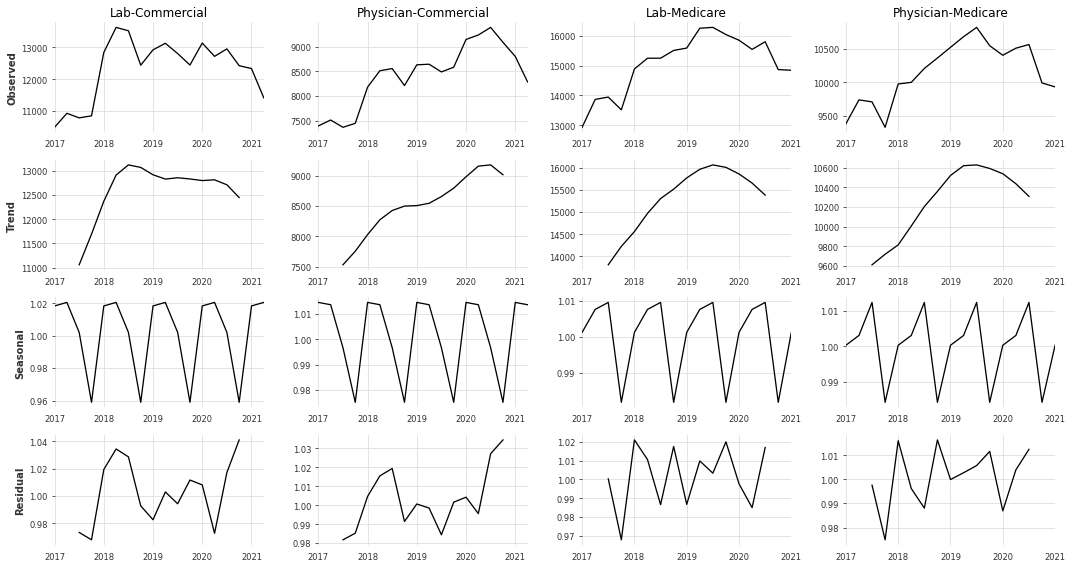

In [41]:
# Data Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

def plotseasonal(res, axes,title ):
    axes[0].set_title(title)
    res.observed.plot(ax=axes[0], legend=False)
    res.trend.plot(ax=axes[1], legend=False)
    res.seasonal.plot(ax=axes[2], legend=False)
    res.resid.plot(ax=axes[3], legend=False)
    if title == "Lab-Commercial":
        axes[0].set_ylabel('Observed')
        axes[1].set_ylabel('Trend')
        axes[2].set_ylabel('Seasonal')
        axes[3].set_ylabel('Residual')


def dataDecomposition(data_copy):
  result1 = seasonal_decompose(data_copy[(data_copy.type == 'C') & (data_copy.source=='L')]['volume'].resample('Q').sum(),model='mul')
  result2 = seasonal_decompose(data_copy[(data_copy.type == 'M') & (data_copy.source=='L')]['volume'].resample('Q').sum(),model='mul')
  result3 = seasonal_decompose(data_copy[(data_copy.type == 'C') & (data_copy.source=='P')]['volume'].resample('Q').sum(),model='mul')
  result4 = seasonal_decompose(data_copy[(data_copy.type == 'M') & (data_copy.source=='P')]['volume'].resample('Q').sum(),model='mul')
  fig, axes = plt.subplots(ncols=4, nrows=4,  figsize=(15,8))
  plotseasonal(result1,axes[:,0],"Lab-Commercial")
  plotseasonal(result3,axes[:,1],"Physician-Commercial")
  plotseasonal(result2,axes[:,2],"Lab-Medicare")
  plotseasonal(result4,axes[:,3],"Physician-Medicare")
  plt.tight_layout()
   
dataDecomposition(data_copy4)

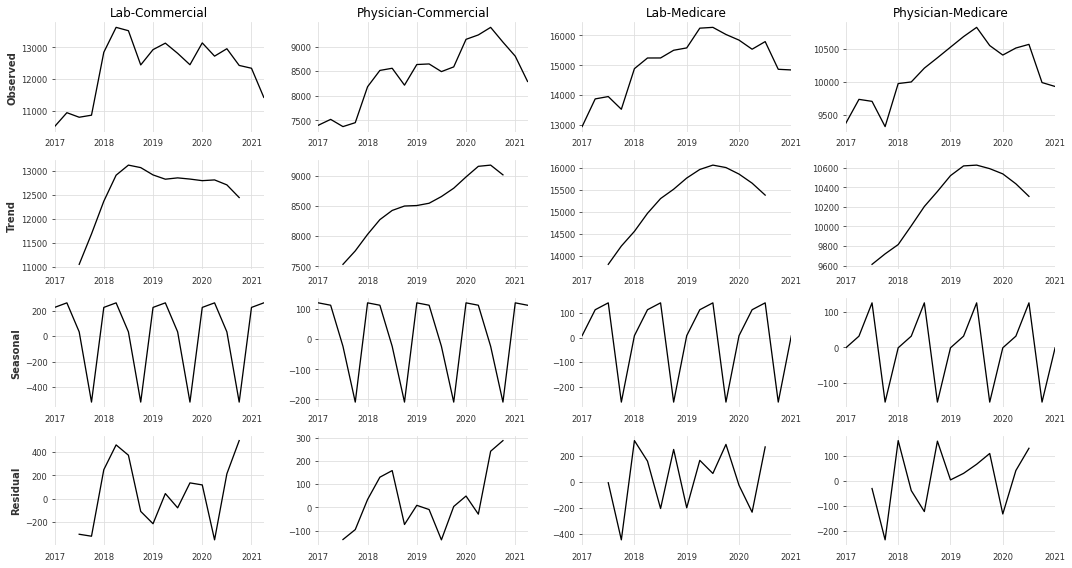

In [42]:
# Data Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

def plotseasonal(res, axes,title ):
    axes[0].set_title(title)
    res.observed.plot(ax=axes[0], legend=False)
    res.trend.plot(ax=axes[1], legend=False)
    res.seasonal.plot(ax=axes[2], legend=False)
    res.resid.plot(ax=axes[3], legend=False)
    if title == "Lab-Commercial":
        axes[0].set_ylabel('Observed')
        axes[1].set_ylabel('Trend')
        axes[2].set_ylabel('Seasonal')
        axes[3].set_ylabel('Residual')


def dataDecomposition(data_copy):
  result1 = seasonal_decompose(data_copy[(data_copy.type == 'C') & (data_copy.source=='L')]['volume'].resample('Q').sum(),model='add')
  result2 = seasonal_decompose(data_copy[(data_copy.type == 'M') & (data_copy.source=='L')]['volume'].resample('Q').sum(),model='add')
  result3 = seasonal_decompose(data_copy[(data_copy.type == 'C') & (data_copy.source=='P')]['volume'].resample('Q').sum(),model='add')
  result4 = seasonal_decompose(data_copy[(data_copy.type == 'M') & (data_copy.source=='P')]['volume'].resample('Q').sum(),model='add')
  fig, axes = plt.subplots(ncols=4, nrows=4,  figsize=(15,8))
  plotseasonal(result1,axes[:,0],"Lab-Commercial")
  plotseasonal(result3,axes[:,1],"Physician-Commercial")
  plotseasonal(result2,axes[:,2],"Lab-Medicare")
  plotseasonal(result4,axes[:,3],"Physician-Medicare")
  plt.tight_layout()
   
dataDecomposition(data_copy4)

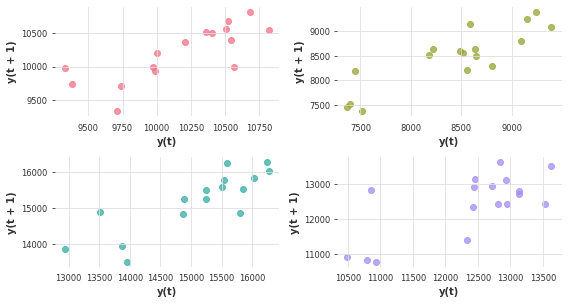

In [32]:
# Lag Plot Creation
lab_comm=data_copy4[(data_copy4['type']=='C') & (data_copy4['source'] == 'L')][['volume']].resample('Q').sum()
lab_medi=data_copy4[(data_copy4['type']=='M') & (data_copy4['source'] == 'L')][['volume']].resample('Q').sum()
phy_comm=data_copy4[(data_copy4['type']=='C') & (data_copy4['source'] == 'P')][['volume']].resample('Q').sum()
phy_medi=data_copy4[(data_copy4['type']=='M') & (data_copy4['source'] == 'P')][['volume']].resample('Q').sum()
data = [phy_medi,phy_comm,lab_medi,lab_comm]
co = sns.color_palette("husl", 4)

def lag_plot():
  ax = [plt.subplot2grid((3,2), (0,0)),
        plt.subplot2grid((3,2), (0,1)),
        plt.subplot2grid((3,2), (1,0)),
        plt.subplot2grid((3,2), (1,1))]
  for d,c,a in zip(data,co,ax):
      pd.plotting.lag_plot(d['volume'].resample('Q').sum(),ax=a, c = c, alpha=0.75)
  plt.tight_layout()

lag_plot()

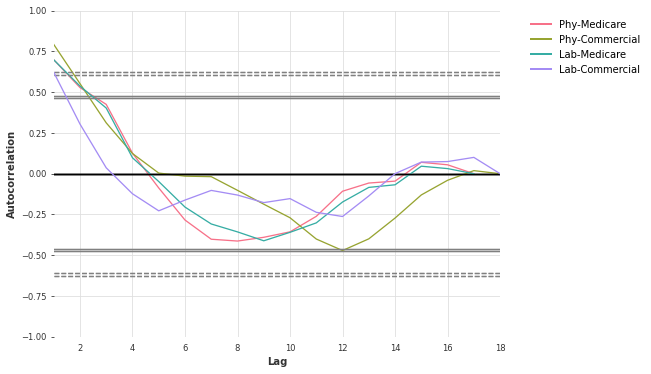

In [33]:
# Auto correlation
from matplotlib.lines import Line2D
plot_color = []
data = [phy_medi,lab_medi]
data = [phy_medi,phy_comm,lab_medi,lab_comm]
for d,c in zip(data,co):
  ax = pd.plotting.autocorrelation_plot(d['volume'].resample('q').mean(),c=c)
  plot_color.append((ax.get_lines()[-1].get_color()))


custom_lines = [Line2D([0],[0], color=plot_color [0], lw=2),
                Line2D([0],[0], color=plot_color [1], lw=2),
                Line2D([0],[0], color=plot_color [2], lw=2),
                Line2D([0],[0], color=plot_color [3], lw=2)]
ax.legend(custom_lines, 
          ['Phy-Medicare', 'Phy-Commercial', 'Lab-Medicare','Lab-Commercial'],
          bbox_to_anchor=(1.05, 1.0))


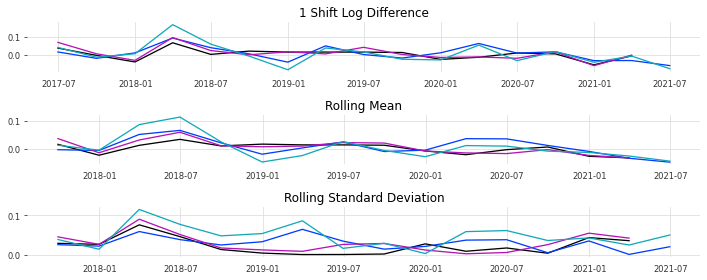

In [43]:
# Stationary to non Stationary
updated_data = pd.DataFrame()
for s in np.unique(data_copy.source):
    for t in np.unique(data_copy.type):
        sample = data_copy[(data_copy.type == t) & (data_copy.source==s)][['volume']].resample('Q').sum()
        sample['diff1_volume'] = sample['volume'] - sample['volume'].shift(1)
        #sample['diff4_volume'] = sample['volume'] - sample['volume'].shift(4)
        updated_data = updated_data.append(sample)
updated_data = updated_data.dropna()

## Stationary to non Stationary
plt.figure(figsize=(10,4))
for d in data:
    plt.subplot(311)
    log_volume = np.log(d['volume'])
    # log_volume = d['volume']
    diff1_volume = log_volume - log_volume.shift(1)
    diff1_volume = diff1_volume.dropna()
    plt.plot(diff1_volume)
    plt.title("1 Shift Log Difference")
    plt.subplot(312)
    roll_mean = diff1_volume.rolling(2).mean()
    roll_mean = roll_mean.dropna()
    plt.plot(roll_mean)
    plt.title("Rolling Mean")
    plt.subplot(313)
    roll_std = diff1_volume.rolling(2).std()
    roll_std = roll_std.dropna()
    plt.plot(roll_std)
    plt.title("Rolling Standard Deviation")
    
plt.tight_layout()
    

In [35]:
### Verifying if the Time series is now Stationary
stats,p,lags,critical_values = kpss(diff1_volume, 'c')
print(f'Test statistics: {stats}')
print(f'p Value: {p}')
print(f'Critical Value: {critical_values}')
if p<0.05:
    print("Series is not Stationary")
else:
    print("Series is Stationary")
    

result = adfuller(diff1_volume)
print(f'Test statistics: {result[0]}')
print(f'p Value: {result[1]}')
print(f'Critical Value: {result[4]}')
if result[1]>0.05:
    print("Series is not Stationary")
else:
    print("Series is Stationary")

Test statistics: 0.3556866928591242
p Value: 0.0962557358365844
Critical Value: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Series is Stationary
Test statistics: -3.243738449310239
p Value: 0.017588473924629696
Critical Value: {'1%': -3.9240193847656246, '5%': -3.0684982031250003, '10%': -2.67389265625}
Series is Stationary


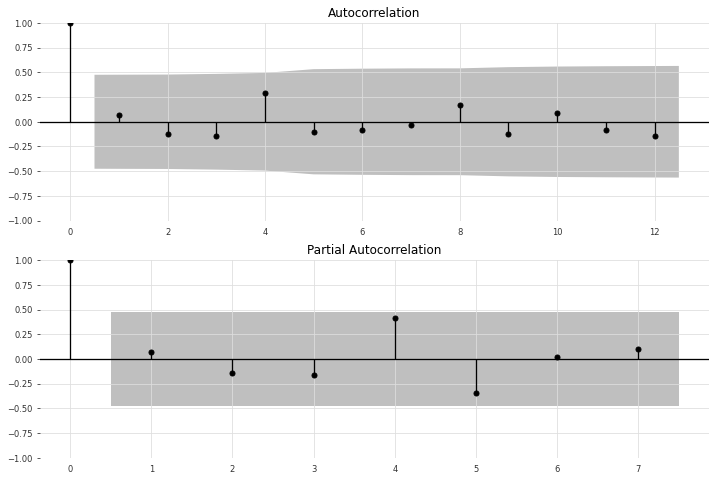

In [36]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot
fig =  plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff1_volume,lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff1_volume,lags=7,ax=ax2)

In [41]:
# Saving the data
data_copy4 = pd.read_csv("./data/data_copy4.csv",header=0,index_col=0)
data_copy3 = pd.read_csv("./data/data_copy3.csv",header=0,index_col=0)
data_copy2 = pd.read_csv("./data/data_copy2.csv",header=0,index_col=0)
data_copy1 = pd.read_csv("./data/data_copy1.csv",header=0,index_col=0)
count_data = pd.read_csv("./data/count_data.csv",header=0,index_col=0)
data_copy4 = data_copy4.sort_index()

# Modelling
## Dividing the data

In [42]:
# Verification
lc=data_copy4[(data_copy4.source=='L')&(data_copy4.type=='C')]['id']
pc=data_copy4[(data_copy4.source=='P')&(data_copy4.type=='C')]['id']
lm=data_copy4[(data_copy4.source=='L')&(data_copy4.type=='M')]['id']
pm=data_copy4[(data_copy4.source=='P')&(data_copy4.type=='M')]['id']
lc_list,pc_list,lm_list,pm_list=[],[],[],[]
lm_with_lc,pm_with_pc,only_lc,only_pc,only_lm,only_pm=[],[],[],[],[],[]
# for a,b,c,d in zip(lc,pc,lm,pm):
#   lc_list.extend(a)
#   pc_list.extend(b)
#   lm_list.extend(c)
#   pm_list.extend(d)
print(len(np.unique(lc)))
print(len(np.unique(pc)))
print(len(np.unique(lm)))
print(len(np.unique(pm))) 

lm_with_lc = set(lm).intersection(lc)
pm_with_pc = set(pm).intersection(pc)
only_lc = set(lc) - set(lm)
only_lm = set(lm) - set(lc)
only_pc = set(pc) - set(pm)
only_pm = set(pm) - set(pc)

# Verification of id length
print(len(lm_with_lc) + len(pm_with_pc) + len(only_lc) + len(only_lm) + len(only_pc) + len(only_pm))


q=final_count[(final_count.source=='L')&(final_count.type=='M')&(final_count.Q_info==100)]['id']
for i in q:
  r = i[0]
lm_with_lc_100=set(r).intersection(lm_with_lc)

q=final_count[(final_count.source=='L')&(final_count.type=='M')&(final_count.Q_info==100)]['id']
for i in q:
  r = i[0]
only_lm_100=set(r).intersection(only_lm)

q=final_count[(final_count.source=='P')&(final_count.type=='M')&(final_count.Q_info==100)]['id']
for i in q:
  r = i[0]
only_pm_100=set(r).intersection(only_pm)

q=final_count[(final_count.source=='L')&(final_count.type=='M')&(final_count.Q_info==50)]['id']
for i in q:
  r = i[0]
lm_with_lc_50=set(r).intersection(lm_with_lc)

q=final_count[(final_count.source=='L')&(final_count.type=='M')&(final_count.Q_info==75)]['id']
for i in q:
  r = i[0]
lm_with_lc_75=set(r).intersection(lm_with_lc)

x=final_count[(final_count.source=='P')&(final_count.type=='M')&(final_count.Q_info==100)]['id']
for i in x:
  y = i[0]
pm_with_pc_100=set(y).intersection(pm_with_pc)

x=final_count[(final_count.source=='P')&(final_count.type=='M')&(final_count.Q_info==50)]['id']
for i in x:
  y = i[0]
pm_with_pc_50=set(y).intersection(pm_with_pc)

x=final_count[(final_count.source=='P')&(final_count.type=='M')&(final_count.Q_info==75)]['id']
for i in x:
  y = i[0]
pm_with_pc_75=set(y).intersection(pm_with_pc)

336
3123
570
4343
6031


In [43]:
print(len(lm_with_lc))
print(len(pm_with_pc))
print(len(only_lm))
print(len(only_pm))
print(len(only_lc))
print(len(only_pc))

213
2128
357
2215
123
995


In [62]:
data_copy4[(data_copy4.id==56209)&(data_copy4.type=='M')][['id','volume']]

id  volume
2017-01-01  56209       4
2017-04-01  56209       4
2017-07-01  56209       1
2017-10-01  56209       3
2018-01-01  56209      11
2018-04-01  56209      14
2018-07-01  56209       9
2018-10-01  56209      12
2019-01-01  56209      12
2019-04-01  56209      15
2019-07-01  56209      18
2019-10-01  56209      13
2020-01-01  56209       9
2020-04-01  56209      12
2020-07-01  56209       8
2020-10-01  56209       6
2021-01-01  56209       7

# UTIL METHODS

In [17]:
# Getting Medicare and Commercial data for a given ID
def getMedCommData(id):
    med=data_copy4[(data_copy4.id==id)&(data_copy4.type=='M')]['volume']
    com=data_copy4[(data_copy4.id==id)&(data_copy4.type=='C')]['volume'].astype('int')[:-1]
    return med,com

def test_train_split(data):
    size=np.ceil(data.shape[0]*0.70).astype('int')
    train = data[:size]
    test = data[size:]
    return train, test

def getDataForGridSearch():
    grid_count = 20
    data_id = {'LMC': list(np.random.choice(list(lm_with_lc),grid_count)),
               'PMC': list(np.random.choice(list(pm_with_pc),grid_count)),
               'LM': list(np.random.choice(list(only_lm),grid_count)),
               'PM': list(np.random.choice(list(only_pm),grid_count))}
    return data_id

def showMessage1(key):
    if key == 'LMC':
        info = "Grid search for Lab ID's with both Medicare and Commercial Volumes"
    elif key == 'PMC':
        info = "Grid search for Physician ID's with both Medicare and Commercial Volumes"
    elif key == 'LM':
        info = "Grid search for Lab ID's with only Medicare"
    else :
        info = "Grid search for Physician ID's with only Medicare"
    print(info)
    
def showMessage2(key):
    print("***********************************************************")
    if key == 'LMC':
        info = "Lab ID's with both Medicare and Commercial Volumes"
    elif key == 'PMC':
        info = "Physician ID's with both Medicare and Commercial Volumes"
    elif key == 'LM':
        info = "Lab ID's with only Medicare"
    else :
        info = "Physician ID's with only Medicare"
    print(info)
    print("***********************************************************")

mts_dict,cts_dict,mts_train_dict,cts_train_dict,mts_test_dict,cts_test_dict = {},{},{},{},{},{}
mts_list,cts_list,mts_train_list,cts_train_list,mts_test_list,cts_test_list = [],[],[],[],[],[]

def cerateTSDict(id,type):
    id_data = data_copy4[(data_copy4.id == id) & (data_copy4.type == type)]['volume']
    id_ts = TimeSeries.from_dataframe(id_data.reset_index(), 'index', 'volume')
    train_med,test_med = train_test_split(id_ts,test_size=0.30)
    if type == 'M':
        global mts_dict
        mts_dict[id] = id_ts
        global mts_train_dict
        mts_train_dict[id] = train_med
        global mts_test_dict
        mts_test_dict[id] = test_med
        
    else:
        global cts_dict
        cts_dict[id] = id_ts
        global cts_train_dict
        cts_train_dict[id] = train_med
        global cts_test_dict
        cts_test_dict[id] = test_med
        
    
def convertToTimeSeries():
    id_dict = {'LMC':lm_with_lc,'PMC':pm_with_pc,'LM':only_lm,'PM':only_pm}
    for key,id_list in id_dict.items():
        for id in id_list:
            print(id)
            cerateTSDict(id,'M')
            if key not in ['LM','PM']:
                cerateTSDict(id,'C')
    global mts_list
    mts_list = list(mts_dict.values())
    global mts_train_list
    mts_train_list =  list(mts_train_dict.values())
    global mts_test_list
    mts_test_list =  list(mts_test_dict.values())
    global cts_list
    cts_list =  list(cts_dict.values())
    global cts_train_list
    cts_train_list =  list(cts_train_dict.values())
    global cts_test_list
    cts_test_list = list(cts_test_dict.values())


In [18]:
convertToTimeSeries()

59393
61953
65029
59909
67087
65041
59409
65557
57881
58905
58910
62503
68136
66599
62504
58412
61485
65071
65585
67637
60983
62014
68162
61508
68165
66118
59465
63050
63563
62028
56400
65616
67155
58967
65113
58969
68702
58975
66663
56426
61549
63598
57455
64621
65652
65142
67191
58489
66683
59005
64638
66174
59518
63618
56965
63622
68235
64144
63126
63128
60060
60578
59042
57508
60583
64169
62636
57526
56503
65720
63674
56508
57533
63676
56512
63684
65220
64712
66250
57547
57549
59598
60623
65743
57041
65234
64720
66264
67289
64728
68315
59097
62169
65759
62176
67809
65250
57059
61674
67820
67822
59632
58611
60149
64762
65276
65790
67329
63746
61699
68356
58125
62222
56591
57616
64784
63252
58644
67864
58648
63774
58147
67876
65317
116517
57126
57639
64804
67884
59693
56622
59183
58672
59698
66869
65845
56631
59705
64825
62267
59721
61258
67402
58701
65870
68434
68954
59741
57182
64861
68960
65377
125277
58212
57192
63850
64370
58227
60276
59252
63864
62332
67453
60284
67966
57725
57

1780631911
1083746671
1609984368
1518160241
1851320691
1508051319
1538165113
1538566526
1518922111
1942464896
1740466564
1336379783
1275783565
1558563213
1508870544
1821043092
1629047196
1245481381
1124198833
1376553396
1710188990
1750370755
1730161092
1962478024
1588906457
1629268453
1780623850
1922034156
1205996014
1124125174
1740286459
1275734527
1124092432
1699727891
1598728727
1417923095
1841482270
1639262751
1467689505
1588644389
1669474870
1265429047
1437116985
1538460225
1346284098
1437370947
1710197314
1528056389
1457556037
1235364423
1699883595
1013107275
1881803344
1235356247
1437289048
1770523227
1851394662
1558358630
1245211242
1790773877
1295714939
1447201405
1114999422
1457334914
1639115397
1558325894
1043352198
1124231816
1316022924
1528105616
1124297361
1164413589
1851312789
1841277589
1124002456
1538198171
1023085214
1669409439
1538321054
1932339876
1134135973
1114974888
1003031212
1356638894
1023093432
1154304699
1104874171
1528228541
1568434876
1356335814
1538149067

1730147596
1578505483
1053390096
1194022160
1417114901
1689867541
1679578389
1356526883
1215083811
1295979813
1285633321
1891775789
1578628400
1467569459
1750357299
1659458867
1407890742
1871590711
1386698041
1679684922
1043215676
1659352383
1821070657
1932195138
1568552263
1982674248
1821070665
1629377874
1689654618
1528059227
1548367204
1346229606
1215976816
1760458103
1194751354
1134237050
1629074810
1033123195
1619973500
1346270592
1528296837
1841223047
1538258314
1871680918
1164465563
1659483550
1437341096
1306867114
1831171511
1821267386
1669404091
1649210816
1023276490
1285830091
1205859790
1699821009
1942418900
1740395995
1376736736
1184921058
1528124898
1063409126
1427011048
1245435379
1376507384
1508087297
1902876162
1679529473
1700984325
1306826250
1508865551
1225029143
1548400161
1962604066
1689654824
1720071731
1962497594
1275704892
1356559934
1629075007
1104025154
1417991746
1407858244
1538397765
1760622153
1851389514
1235113556
1003828823
1295930972
1518155357
1083618912

63626
63635
65686
59545
61594
57514
59563
57520
63668
57542
57548
65746
57556
57560
65757
67814
57576
57628
59677
61729
59682
59683
63783
67880
59691
65843
59701
65848
67898
63807
67905
61764
63815
61815
67959
65917
57731
65943
59800
68000
68003
61869
68019
61877
61879
63937
61902
68049
63953
59868
63972
59880
68072
68075
57864
66060
59926
64023
59939
57893
59943
68135
66087
64047
68150
59965
68173
66129
64082
66136
62042
62046
64103
62059
57965
57966
66159
60016
66163
62080
64134
68233
66188
68245
62103
64157
66225
68292
60100
58066
64212
58077
60131
58088
68329
58090
66284
68341
64247
64256
64265
60173
64270
64277
60191
58144
56123
56126
68415
66367
60225
64329
66379
62303
64369
56184
66443
56209
68504
56222
58273
62374
68519
66472
58278
66478
56239
60335
64432
66482
60338
60344
64448
68546
56260
62406
60359
60360
60363
64462
60372
56277
60374
62421
66522
66524
64479
68575
68579
66532
60390
56297
58348
62445
56305
66553
62458
62459
62481
56344
62491
68639
56354
60456
56361
58414
6865

1093797987
1336133735
1043286123
1700800620
1982695540
1174726780
1295812733
1407174782
1568581759
1689766016
1518168202
1730168972
1194715276
1275799694
1720010895
1003980947
1861437592
1215907993
1447233689
1770547358
1497835680
1982703781
1922001064
1427007657
1497933998
1619945649
1609967793
1457555641
1669785788
1013196989
1033300157
1023043775
1588758718
1710942396
1104849090
1225091267
1336436930
1942292677
1619101896
1144555723
1760667851
1568622801
1871538389
1467435222
1952344277
1275832537
1245227230
1497745632
1891084513
1184737504
1376741603
1558391011
1184631012
1174866149
1770629354
1538197744
1992755441
1245219062
1952303356
1598761215
1285630210
1518127364
1700849924
1891805446
1205848330
1538328844
1992927503
1144244500
1699064089
1093912859
1851525406
1376520478
1306855713
1912949033
1508813098
1508804907
1528293677
1457580334
1376528687
1447203054
1255442737
1417922865
1851681076
1982826806
1487653176
1275767097
1003079997
1689864522
1447405899
1902979404
1275521361

1407111776
1033302625
1699934828
1447547500
1528386158
1750512240
1790759538
1891848818
1710142070
1194799742
1538134655
1760432769
1003852419
1366446726
1073607305
1275540106
1205817996
1457336976
1699738260
1558336149
1710076567
1639494297
1730237082
1962799775
1699852962
1629205158
1700803244
1306817200
1417917105
1568453298
1215189683
1689662132
1861464760
1992700611
1528050374
1114010311
1356395214
1699967695
1972802262
1376514778
1306825435
1285796573
1629270749
1184608994
1598739179
1396011755
1467552497
1790874360
1912181496
1689850620
1003991811
1104040708
1679807242
1356477194
1285780239
1205056272
1881641744
1265513238
1508029208
1760793368
1881682714
1871557405
1043280670
1093006116
1063760676
1154380582
1952445223
1114977071
1225044787
1922003763
1922069301
1265472310
1902080823
1669493573
1295717189
1275597650
1922364249
1134154594
1215066980
1124012901
1447269220
1356313449
1346401130
1083741037
1215943535
1619956596
1356395388
1831121789
1679684476
1003852674
1184756611

1427234277
1487609319
1255390696
1982692851
1720376825
1861475840
1760689665
1780784645
1093934598
1740340744
1265417737
1821203977
1508818444
1760640536
1225301534
1508187683
1184661027
1831370279
1871519272
1568423465
1134272040
1285996082
1881751097
1255652921
1467629113
1053318717
1033182787
1588616783
1962507863
1679662688
1396735585
1861647968
1699765859
1609801315
1417248360
1265630826
1770593899
1336295021
1760534127
1700011632
1740316272
1245527670
1972543114
1609932433
1255308946
1306828447
1649286816
1104813732
1740398262
1023016631
1265786552
1225031354
1346248382
1396981445
1386708683
1538334420
1780670166
1780973271
1285742296
1437449949
1962499806
1952349920
1356357347
1619959525
1225236201
1568431849
1053376251
1821138686
1841200896
1881849602
1962483461
1558380295
1922064138
1578852109
1154383636
1457487639
1043267354
1639399199
1366687519
1487871786
1073667887
1255374641
1831247667
1609031475
1114185527
1942282041
1417068347
1821261629
1417994047
1154563906
1235386178

# AUTO ARIMA

In [19]:
# Auto Arima Utils
model_autoArima = {}

def autoArimaProcessing(id,method,key,hyperTuning=True):
    med,com=getMedCommData(id)
    train_med,test_med = model_selection.train_test_split(med,test_size=0.25)
    if key in ['LM','PM']:
        train_com = None
        test_com = test_med
    else:
        train_com,test_com = model_selection.train_test_split(com,test_size=0.25)
        train_com=train_com.values.reshape(-1, 1)
    best_model= pmd.auto_arima(y=train_med,X=train_com,
                              start_p=1,max_p=4,
                              start_q=1,max_q=4,
                              start_P=0,max_P=1,
                              start_Q=0,max_Q=1,
                              d=None,stationary=False,m=4,seasonal=False,
                              n_jobs=-1,trace=False,method = method,test='kpss',
                              stepwise=True,with_intercept=False,suppress_warnings=True,
                              error_action='ignore')
    predict = pd.DataFrame(best_model.predict(X=pd.DataFrame(test_com),
                                              n_periods=len(test_com)), 
                                              index= test_com.index,
                                              columns = ['yhat'])
    mape = np.round(mean_absolute_percentage_error(predict,test_med),3)
    if (hyperTuning == True):
        return mape
    else:
        return train_med,test_med,train_com,test_com,best_model,predict,mape

In [26]:
# Step 1:Grid Search
def autoArimaGridSearch():
    print("STEP 1: PERFORMING PROPHET GRID SEARCH")
    method_list = ['nm','bfgs','lbfgs','cg']
    data_id = getDataForGridSearch()
    data_method = pd.DataFrame(columns=['id','method','score'])

    for key,id_list in data_id.items():
        showMessage1(key)
        for method in method_list:
            for id in id_list:
                mape = autoArimaProcessing(id,method,key,True)
                data_method = data_method.append({'id': id,'method':method,'score': mape}, ignore_index=True)
    print("Sucessfull......")
    return np.min(data_method.groupby('method').mean('dcore').reset_index(drop=False))

In [27]:
# Step 2:Model Building

def runAutoArima(key,id_list,method):
        count=0
        showMessage2(key)
        for id in id_list:
            count=count+1
            model_autoArima[id] = {}
            train_med,test_med,train_com,test_com,best_model,predict,mape = autoArimaProcessing(id,method,key,False)
            model_autoArima[id]['train_com'] = train_com
            model_autoArima[id]['test_com'] = test_com
            model_autoArima[id]['best_model'] = best_model
            model_autoArima[id]['train_med'] = train_med
            model_autoArima[id]['test_med'] = test_med
            predict['yhat'] = np.round(predict['yhat']).astype('int')
            predict[predict['yhat'] < 0 ] = 1
            model_autoArima[id]['predict'] = predict
            model_autoArima[id]['best_mape'] = mape
            model_autoArima[id]['best_mse'] = np.round(mean_squared_error(predict,test_med),3)
            print(f"({count}) Model Fitting for {id}: MAPE --> {model_autoArima[id]['best_mape']} | MSE --> {model_autoArima[id]['best_mse']}")
            
def autoArimaModelBuilding(method): 
    print("STEP 2: PERFORMING AUTO ARIMA MODEL BUILDING")
    id_dict = {'LMC':lm_with_lc,'PMC':pm_with_pc,'LM':only_lm,'PM':only_pm}
    for key,id_list in id_dict.items():
        runAutoArima(key,id_list,method)
    print("Sucessfull......")

In [28]:
# Step 3:Pickling the models
def autoArimaPickle():
    print("STEP 3: SAVING AUTO ARIMA MODELS IN ./pickle/autoArima_dict.pkl")
    pickle_file = open("./pickle/autoArima_dict.pkl", "wb")
    pickle.dump(model_autoArima, pickle_file)
    pickle_file.close()
    print("Sucessfull......")

In [29]:
# Final: Initiating the Model
def autoArimaInitiate():
    autoArimaModelBuilding(autoArimaGridSearch()[0])
    autoArimaPickle()
    
autoArimaInitiate()

STEP 1: PERFORMING PROPHET GRID SEARCH
Grid search for Lab ID's with both Medicare and Commercial Volumes
Grid search for Physician ID's with both Medicare and Commercial Volumes
Grid search for Lab ID's with only Medicare
Grid search for Physician ID's with only Medicare
Sucessfull......
STEP 2: PERFORMING AUTO ARIMA MODEL BUILDING
***********************************************************
Lab ID's with both Medicare and Commercial Volumes
***********************************************************
(1) Model Fitting for 59393: MAPE --> 1.092 | MSE --> 44.4
(2) Model Fitting for 61953: MAPE --> 0.326 | MSE --> 51.0
(3) Model Fitting for 65029: MAPE --> 0.086 | MSE --> 27.8
(4) Model Fitting for 59909: MAPE --> 0.279 | MSE --> 42.0
(5) Model Fitting for 67087: MAPE --> 0.472 | MSE --> 0.8
(6) Model Fitting for 65041: MAPE --> 0.505 | MSE --> 1.0
(7) Model Fitting for 59409: MAPE --> 0.958 | MSE --> 20.2
(8) Model Fitting for 65557: MAPE --> 0.327 | MSE --> 0.4
(9) Model Fitting for 578

(129) Model Fitting for 67884: MAPE --> 1.283 | MSE --> 2.6
(130) Model Fitting for 59693: MAPE --> 0.27 | MSE --> 2475.6
(131) Model Fitting for 56622: MAPE --> 0.668 | MSE --> 10.6
(132) Model Fitting for 59183: MAPE --> 0.176 | MSE --> 127.8
(133) Model Fitting for 58672: MAPE --> 1.231 | MSE --> 6.0
(134) Model Fitting for 59698: MAPE --> 0.908 | MSE --> 2.6
(135) Model Fitting for 66869: MAPE --> 0.07 | MSE --> 38.0
(136) Model Fitting for 65845: MAPE --> 0.092 | MSE --> 63.0
(137) Model Fitting for 56631: MAPE --> 0.472 | MSE --> 17.4
(138) Model Fitting for 59705: MAPE --> 0.344 | MSE --> 340.2
(139) Model Fitting for 64825: MAPE --> 2.383 | MSE --> 11.8
(140) Model Fitting for 62267: MAPE --> 0.277 | MSE --> 1.4
(141) Model Fitting for 59721: MAPE --> 0.85 | MSE --> 21.4
(142) Model Fitting for 61258: MAPE --> 0.205 | MSE --> 195.0
(143) Model Fitting for 67402: MAPE --> 0.277 | MSE --> 5.2
(144) Model Fitting for 58701: MAPE --> 2.399 | MSE --> 1.2
(145) Model Fitting for 6587

(46) Model Fitting for 1326014622: MAPE --> 0.42 | MSE --> 11.6
(47) Model Fitting for 1275551913: MAPE --> 3.532 | MSE --> 1.2
(48) Model Fitting for 1295909034: MAPE --> 0.471 | MSE --> 36.4
(49) Model Fitting for 1598881963: MAPE --> 5.617 | MSE --> 0.8
(50) Model Fitting for 1851564207: MAPE --> 0.287 | MSE --> 0.2
(51) Model Fitting for 1386684603: MAPE --> 0.367 | MSE --> 1.0
(52) Model Fitting for 1154326718: MAPE --> 0.664 | MSE --> 3.6
(53) Model Fitting for 1952637118: MAPE --> 0.628 | MSE --> 7.8
(54) Model Fitting for 1932198082: MAPE --> 0.462 | MSE --> 1.4
(55) Model Fitting for 1881702595: MAPE --> 3.273 | MSE --> 2.4
(56) Model Fitting for 1386750149: MAPE --> 0.404 | MSE --> 4.2
(57) Model Fitting for 1649492166: MAPE --> 0.123 | MSE --> 0.0
(58) Model Fitting for 1619034311: MAPE --> 0.324 | MSE --> 0.4
(59) Model Fitting for 1467441352: MAPE --> 0.587 | MSE --> 3.6
(60) Model Fitting for 1154302156: MAPE --> 1.06 | MSE --> 4.2
(61) Model Fitting for 1144332495: MAPE 

(173) Model Fitting for 1215038112: MAPE --> 0.351 | MSE --> 0.6
(174) Model Fitting for 1427268259: MAPE --> 0.47 | MSE --> 3.8
(175) Model Fitting for 1992925861: MAPE --> 0.375 | MSE --> 3.2
(176) Model Fitting for 1164477097: MAPE --> 0.401 | MSE --> 20.8
(177) Model Fitting for 1356399281: MAPE --> 0.426 | MSE --> 6.2
(178) Model Fitting for 1871545012: MAPE --> 0.68 | MSE --> 2.6
(179) Model Fitting for 1255310017: MAPE --> 0.452 | MSE --> 5.2
(180) Model Fitting for 1598702284: MAPE --> 0.778 | MSE --> 0.4
(181) Model Fitting for 1831191246: MAPE --> 1.427 | MSE --> 2.2
(182) Model Fitting for 1376740050: MAPE --> 0.146 | MSE --> 7.6
(183) Model Fitting for 1386693331: MAPE --> 0.387 | MSE --> 0.2
(184) Model Fitting for 1942209234: MAPE --> 1.021 | MSE --> 4.4
(185) Model Fitting for 1154302677: MAPE --> 0.765 | MSE --> 1.8
(186) Model Fitting for 1164583639: MAPE --> 0.491 | MSE --> 2.4
(187) Model Fitting for 1699889881: MAPE --> 0.547 | MSE --> 4.2
(188) Model Fitting for 13

(300) Model Fitting for 1336460435: MAPE --> 0.467 | MSE --> 1.2
(301) Model Fitting for 1639154834: MAPE --> 0.282 | MSE --> 0.4
(302) Model Fitting for 1639163033: MAPE --> 0.269 | MSE --> 1.2
(303) Model Fitting for 1861461147: MAPE --> 0.3 | MSE --> 0.0
(304) Model Fitting for 1730151580: MAPE --> 0.285 | MSE --> 2.6
(305) Model Fitting for 1831109792: MAPE --> 0.348 | MSE --> 2.8
(306) Model Fitting for 1750303905: MAPE --> 0.323 | MSE --> 5.4
(307) Model Fitting for 1407804578: MAPE --> 0.261 | MSE --> 0.4
(308) Model Fitting for 1568457893: MAPE --> 0.329 | MSE --> 0.0
(309) Model Fitting for 1285727404: MAPE --> 0.577 | MSE --> 1.2
(310) Model Fitting for 1124132014: MAPE --> 0.446 | MSE --> 14.6
(311) Model Fitting for 1205839024: MAPE --> 0.355 | MSE --> 2.0
(312) Model Fitting for 1215939764: MAPE --> 0.404 | MSE --> 0.6
(313) Model Fitting for 1285637314: MAPE --> 0.117 | MSE --> 0.0
(314) Model Fitting for 1356326086: MAPE --> 0.187 | MSE --> 2.0
(315) Model Fitting for 15

(427) Model Fitting for 1942210117: MAPE --> 0.729 | MSE --> 87.4
(428) Model Fitting for 1174595144: MAPE --> 0.697 | MSE --> 1.2
(429) Model Fitting for 1780663880: MAPE --> 0.452 | MSE --> 5.6
(430) Model Fitting for 1871537738: MAPE --> 0.571 | MSE --> 6.0
(431) Model Fitting for 1679689301: MAPE --> 0.613 | MSE --> 47.4
(432) Model Fitting for 1962501718: MAPE --> 0.245 | MSE --> 0.2
(433) Model Fitting for 1306003033: MAPE --> 6.087 | MSE --> 13.4
(434) Model Fitting for 1184843369: MAPE --> 0.541 | MSE --> 1.4
(435) Model Fitting for 1871767152: MAPE --> 0.385 | MSE --> 2.2
(436) Model Fitting for 1477625465: MAPE --> 0.33 | MSE --> 0.8
(437) Model Fitting for 1043474042: MAPE --> 0.176 | MSE --> 1.2
(438) Model Fitting for 1528030848: MAPE --> 0.426 | MSE --> 0.8
(439) Model Fitting for 1023149697: MAPE --> 0.419 | MSE --> 1.8
(440) Model Fitting for 1962706564: MAPE --> 0.117 | MSE --> 0.4
(441) Model Fitting for 1245324938: MAPE --> 0.585 | MSE --> 0.8
(442) Model Fitting for

(553) Model Fitting for 1437165610: MAPE --> 0.545 | MSE --> 3.8
(554) Model Fitting for 1407060015: MAPE --> 1.362 | MSE --> 23.4
(555) Model Fitting for 1790969905: MAPE --> 1.943 | MSE --> 3.0
(556) Model Fitting for 1295829042: MAPE --> 0.591 | MSE --> 1.4
(557) Model Fitting for 1437460532: MAPE --> 1.734 | MSE --> 17.4
(558) Model Fitting for 1407199284: MAPE --> 0.275 | MSE --> 2.4
(559) Model Fitting for 1497778229: MAPE --> 0.678 | MSE --> 1.2
(560) Model Fitting for 1376520254: MAPE --> 0.785 | MSE --> 7.0
(561) Model Fitting for 1043204159: MAPE --> 0.797 | MSE --> 2.2
(562) Model Fitting for 1427294271: MAPE --> 0.204 | MSE --> 0.4
(563) Model Fitting for 1225001027: MAPE --> 0.728 | MSE --> 1.2
(564) Model Fitting for 1376561225: MAPE --> 0.2 | MSE --> 0.4
(565) Model Fitting for 1598752842: MAPE --> 0.615 | MSE --> 6.0
(566) Model Fitting for 1417144395: MAPE --> 4.841 | MSE --> 5.0
(567) Model Fitting for 1801857099: MAPE --> 0.485 | MSE --> 14.6
(568) Model Fitting for 

(680) Model Fitting for 1346284098: MAPE --> 0.558 | MSE --> 2.2
(681) Model Fitting for 1437370947: MAPE --> 0.537 | MSE --> 7.4
(682) Model Fitting for 1710197314: MAPE --> 0.41 | MSE --> 1.4
(683) Model Fitting for 1528056389: MAPE --> 0.329 | MSE --> 0.6
(684) Model Fitting for 1457556037: MAPE --> 0.222 | MSE --> 1.2
(685) Model Fitting for 1235364423: MAPE --> 0.708 | MSE --> 7.0
(686) Model Fitting for 1699883595: MAPE --> 0.562 | MSE --> 1.0
(687) Model Fitting for 1013107275: MAPE --> 0.448 | MSE --> 2.2
(688) Model Fitting for 1881803344: MAPE --> 0.431 | MSE --> 2.4
(689) Model Fitting for 1235356247: MAPE --> 2.643 | MSE --> 2.6
(690) Model Fitting for 1437289048: MAPE --> 0.404 | MSE --> 7.2
(691) Model Fitting for 1770523227: MAPE --> 0.479 | MSE --> 1.4
(692) Model Fitting for 1851394662: MAPE --> 0.498 | MSE --> 14.2
(693) Model Fitting for 1558358630: MAPE --> 0.466 | MSE --> 0.6
(694) Model Fitting for 1245211242: MAPE --> 1.339 | MSE --> 4.6
(695) Model Fitting for 1

(807) Model Fitting for 1528294436: MAPE --> 1.573 | MSE --> 0.8
(808) Model Fitting for 1477512234: MAPE --> 2.461 | MSE --> 5.6
(809) Model Fitting for 1043655723: MAPE --> 0.524 | MSE --> 2.6
(810) Model Fitting for 1003883562: MAPE --> 0.053 | MSE --> 0.0
(811) Model Fitting for 1518922814: MAPE --> 0.307 | MSE --> 1.4
(812) Model Fitting for 1619930195: MAPE --> 0.369 | MSE --> 2.6
(813) Model Fitting for 1184861270: MAPE --> 0.639 | MSE --> 1.4
(814) Model Fitting for 1528269917: MAPE --> 0.256 | MSE --> 3.2
(815) Model Fitting for 1902988389: MAPE --> 0.223 | MSE --> 0.2
(816) Model Fitting for 1427008622: MAPE --> 0.552 | MSE --> 2.0
(817) Model Fitting for 1023003761: MAPE --> 0.107 | MSE --> 1.6
(818) Model Fitting for 1154411635: MAPE --> 0.391 | MSE --> 1.0
(819) Model Fitting for 1194986612: MAPE --> 0.823 | MSE --> 34.4
(820) Model Fitting for 1659505782: MAPE --> 2.143 | MSE --> 5.2
(821) Model Fitting for 1518980218: MAPE --> 0.468 | MSE --> 1.0
(822) Model Fitting for 

(934) Model Fitting for 1871678961: MAPE --> 0.294 | MSE --> 0.6
(935) Model Fitting for 1780674036: MAPE --> 0.04 | MSE --> 0.0
(936) Model Fitting for 1942588918: MAPE --> 0.67 | MSE --> 1.2
(937) Model Fitting for 1972506111: MAPE --> 0.419 | MSE --> 2.0
(938) Model Fitting for 1750380036: MAPE --> 0.846 | MSE --> 3.2
(939) Model Fitting for 1881845253: MAPE --> 0.337 | MSE --> 0.2
(940) Model Fitting for 1700990470: MAPE --> 0.088 | MSE --> 0.0
(941) Model Fitting for 1982656005: MAPE --> 0.2 | MSE --> 0.0
(942) Model Fitting for 1750601225: MAPE --> 0.119 | MSE --> 0.2
(943) Model Fitting for 1760448013: MAPE --> 0.282 | MSE --> 1.2
(944) Model Fitting for 1609854488: MAPE --> 0.286 | MSE --> 0.6
(945) Model Fitting for 1134202393: MAPE --> 0.348 | MSE --> 0.8
(946) Model Fitting for 1649405473: MAPE --> 0.154 | MSE --> 1.2
(947) Model Fitting for 1083887137: MAPE --> 0.574 | MSE --> 11.6
(948) Model Fitting for 1275538985: MAPE --> 0.258 | MSE --> 0.8
(949) Model Fitting for 1992

(1060) Model Fitting for 1548226541: MAPE --> 0.479 | MSE --> 3.2
(1061) Model Fitting for 1720193006: MAPE --> 0.301 | MSE --> 0.8
(1062) Model Fitting for 1598828527: MAPE --> 0.352 | MSE --> 6.8
(1063) Model Fitting for 1952403438: MAPE --> 0.463 | MSE --> 0.8
(1064) Model Fitting for 1336160241: MAPE --> 0.645 | MSE --> 1.4
(1065) Model Fitting for 1841254406: MAPE --> 0.311 | MSE --> 0.4
(1066) Model Fitting for 1285689356: MAPE --> 0.498 | MSE --> 11.6
(1067) Model Fitting for 1821192204: MAPE --> 0.76 | MSE --> 1.6
(1068) Model Fitting for 1871532051: MAPE --> 0.434 | MSE --> 0.8
(1069) Model Fitting for 1326338070: MAPE --> 0.408 | MSE --> 10.2
(1070) Model Fitting for 1346293784: MAPE --> 0.718 | MSE --> 3.4
(1071) Model Fitting for 1699729434: MAPE --> 0.66 | MSE --> 1.0
(1072) Model Fitting for 1114058781: MAPE --> 0.373 | MSE --> 1.2
(1073) Model Fitting for 1801834528: MAPE --> 0.673 | MSE --> 25.2
(1074) Model Fitting for 1245499425: MAPE --> 0.565 | MSE --> 3.2
(1075) Mo

(1185) Model Fitting for 1538281928: MAPE --> 0.406 | MSE --> 2.0
(1186) Model Fitting for 1831178698: MAPE --> 0.3 | MSE --> 0.6
(1187) Model Fitting for 1649275355: MAPE --> 0.383 | MSE --> 0.6
(1188) Model Fitting for 1932235231: MAPE --> 0.833 | MSE --> 0.8
(1189) Model Fitting for 1366536674: MAPE --> 0.132 | MSE --> 0.0
(1190) Model Fitting for 1700991460: MAPE --> 0.211 | MSE --> 0.4
(1191) Model Fitting for 1992020457: MAPE --> 0.972 | MSE --> 10.8
(1192) Model Fitting for 1437102571: MAPE --> 1.056 | MSE --> 13.4
(1193) Model Fitting for 1952313850: MAPE --> 0.475 | MSE --> 0.6
(1194) Model Fitting for 1659343358: MAPE --> 0.52 | MSE --> 1.0
(1195) Model Fitting for 1467453951: MAPE --> 0.303 | MSE --> 0.6
(1196) Model Fitting for 1730343427: MAPE --> 0.338 | MSE --> 0.4
(1197) Model Fitting for 1053397513: MAPE --> 0.421 | MSE --> 0.6
(1198) Model Fitting for 1174532618: MAPE --> 0.442 | MSE --> 2.2
(1199) Model Fitting for 1134178833: MAPE --> 0.652 | MSE --> 5.8
(1200) Mode

(1309) Model Fitting for 1336120336: MAPE --> 0.364 | MSE --> 1.4
(1310) Model Fitting for 1861506065: MAPE --> 1.25 | MSE --> 3.8
(1311) Model Fitting for 1598911505: MAPE --> 1.031 | MSE --> 14.2
(1312) Model Fitting for 1710027792: MAPE --> 0.131 | MSE --> 0.0
(1313) Model Fitting for 1639109648: MAPE --> 1.069 | MSE --> 3.4
(1314) Model Fitting for 1073574935: MAPE --> 0.726 | MSE --> 9.0
(1315) Model Fitting for 1134212129: MAPE --> 0.376 | MSE --> 6.0
(1316) Model Fitting for 1114002466: MAPE --> 0.343 | MSE --> 0.6
(1317) Model Fitting for 1912124454: MAPE --> 0.241 | MSE --> 0.4
(1318) Model Fitting for 1942369319: MAPE --> 1.3 | MSE --> 8.4
(1319) Model Fitting for 1922044973: MAPE --> 0.349 | MSE --> 0.6
(1320) Model Fitting for 1194734640: MAPE --> 0.627 | MSE --> 1.2
(1321) Model Fitting for 1306866736: MAPE --> 0.35 | MSE --> 1.2
(1322) Model Fitting for 1548268592: MAPE --> 0.238 | MSE --> 0.4
(1323) Model Fitting for 1467659318: MAPE --> 0.265 | MSE --> 0.2
(1324) Model 

(1434) Model Fitting for 1306867114: MAPE --> 0.491 | MSE --> 1.4
(1435) Model Fitting for 1831171511: MAPE --> 0.53 | MSE --> 2.0
(1436) Model Fitting for 1821267386: MAPE --> 0.383 | MSE --> 0.8
(1437) Model Fitting for 1669404091: MAPE --> 0.317 | MSE --> 0.6
(1438) Model Fitting for 1649210816: MAPE --> 0.521 | MSE --> 1.6
(1439) Model Fitting for 1023276490: MAPE --> 0.52 | MSE --> 7.8
(1440) Model Fitting for 1285830091: MAPE --> 0.273 | MSE --> 0.6
(1441) Model Fitting for 1205859790: MAPE --> 0.481 | MSE --> 17.4
(1442) Model Fitting for 1699821009: MAPE --> 0.575 | MSE --> 7.8
(1443) Model Fitting for 1942418900: MAPE --> 0.284 | MSE --> 12.2
(1444) Model Fitting for 1740395995: MAPE --> 0.188 | MSE --> 2.8
(1445) Model Fitting for 1376736736: MAPE --> 0.587 | MSE --> 0.6
(1446) Model Fitting for 1184921058: MAPE --> 0.416 | MSE --> 2.2
(1447) Model Fitting for 1528124898: MAPE --> 0.541 | MSE --> 2.2
(1448) Model Fitting for 1063409126: MAPE --> 0.552 | MSE --> 2.2
(1449) Mod

(1560) Model Fitting for 1346336617: MAPE --> 0.403 | MSE --> 6.4
(1561) Model Fitting for 1689876328: MAPE --> 0.389 | MSE --> 0.8
(1562) Model Fitting for 1710192489: MAPE --> 0.433 | MSE --> 0.4
(1563) Model Fitting for 1255593836: MAPE --> 0.487 | MSE --> 1.8
(1564) Model Fitting for 1730164591: MAPE --> 1.17 | MSE --> 4.4
(1565) Model Fitting for 1033287537: MAPE --> 0.619 | MSE --> 2.6
(1566) Model Fitting for 1598871410: MAPE --> 0.111 | MSE --> 0.0
(1567) Model Fitting for 1245288315: MAPE --> 0.332 | MSE --> 10.2
(1568) Model Fitting for 1033189246: MAPE --> 0.453 | MSE --> 0.6
(1569) Model Fitting for 1427339134: MAPE --> 0.604 | MSE --> 9.2
(1570) Model Fitting for 1043273600: MAPE --> 0.241 | MSE --> 0.2
(1571) Model Fitting for 1952331654: MAPE --> 4.98 | MSE --> 16.8
(1572) Model Fitting for 1023055761: MAPE --> 0.631 | MSE --> 17.2
(1573) Model Fitting for 1285830554: MAPE --> 0.535 | MSE --> 2.2
(1574) Model Fitting for 1467455386: MAPE --> 0.985 | MSE --> 2.8
(1575) Mo

(1685) Model Fitting for 1457404279: MAPE --> 3.163 | MSE --> 7.6
(1686) Model Fitting for 1316944259: MAPE --> 0.272 | MSE --> 0.4
(1687) Model Fitting for 1972640134: MAPE --> 0.469 | MSE --> 1.4
(1688) Model Fitting for 1316927882: MAPE --> 0.232 | MSE --> 0.2
(1689) Model Fitting for 1417927054: MAPE --> 0.915 | MSE --> 5.4
(1690) Model Fitting for 1700960655: MAPE --> 5.209 | MSE --> 2.2
(1691) Model Fitting for 1629280656: MAPE --> 0.604 | MSE --> 0.4
(1692) Model Fitting for 1558534545: MAPE --> 0.435 | MSE --> 0.8
(1693) Model Fitting for 1316903321: MAPE --> 0.614 | MSE --> 5.2
(1694) Model Fitting for 1972509081: MAPE --> 0.163 | MSE --> 0.2
(1695) Model Fitting for 1841494432: MAPE --> 0.421 | MSE --> 0.8
(1696) Model Fitting for 1013012897: MAPE --> 0.433 | MSE --> 8.2
(1697) Model Fitting for 1245272483: MAPE --> 1.881 | MSE --> 15.8
(1698) Model Fitting for 1881897379: MAPE --> 2.661 | MSE --> 2.2
(1699) Model Fitting for 1669790119: MAPE --> 0.469 | MSE --> 1.4
(1700) Mo

(1810) Model Fitting for 1588648786: MAPE --> 0.187 | MSE --> 0.4
(1811) Model Fitting for 1598757718: MAPE --> 0.344 | MSE --> 0.4
(1812) Model Fitting for 1659534170: MAPE --> 0.401 | MSE --> 5.8
(1813) Model Fitting for 1295760221: MAPE --> 0.253 | MSE --> 0.2
(1814) Model Fitting for 1487633251: MAPE --> 0.822 | MSE --> 2.2
(1815) Model Fitting for 1063680882: MAPE --> 0.703 | MSE --> 0.6
(1816) Model Fitting for 1982823290: MAPE --> 0.357 | MSE --> 1.0
(1817) Model Fitting for 1083857791: MAPE --> 0.223 | MSE --> 3.6
(1818) Model Fitting for 1437383551: MAPE --> 0.236 | MSE --> 0.2
(1819) Model Fitting for 1740249986: MAPE --> 0.347 | MSE --> 0.8
(1820) Model Fitting for 1477557122: MAPE --> 1.753 | MSE --> 5.0
(1821) Model Fitting for 1942223748: MAPE --> 1.542 | MSE --> 2.0
(1822) Model Fitting for 1295727493: MAPE --> 0.344 | MSE --> 0.4
(1823) Model Fitting for 1508973447: MAPE --> 0.707 | MSE --> 4.0
(1824) Model Fitting for 1497783179: MAPE --> 0.418 | MSE --> 0.8
(1825) Mod

(1935) Model Fitting for 1427217645: MAPE --> 1.334 | MSE --> 1.6
(1936) Model Fitting for 1780612333: MAPE --> 0.316 | MSE --> 1.0
(1937) Model Fitting for 1619156205: MAPE --> 0.053 | MSE --> 0.0
(1938) Model Fitting for 1609809136: MAPE --> 2.573 | MSE --> 5.2
(1939) Model Fitting for 1124293873: MAPE --> 0.41 | MSE --> 50.2
(1940) Model Fitting for 1427291384: MAPE --> 0.105 | MSE --> 0.0
(1941) Model Fitting for 1073569018: MAPE --> 0.116 | MSE --> 0.0
(1942) Model Fitting for 1205804283: MAPE --> 0.482 | MSE --> 1.8
(1943) Model Fitting for 1659387132: MAPE --> 0.434 | MSE --> 16.6
(1944) Model Fitting for 1588698369: MAPE --> 0.341 | MSE --> 0.4
(1945) Model Fitting for 1710071048: MAPE --> 0.8 | MSE --> 1.2
(1946) Model Fitting for 1518132489: MAPE --> 0.364 | MSE --> 1.2
(1947) Model Fitting for 1124334859: MAPE --> 0.7 | MSE --> 0.8
(1948) Model Fitting for 1629297932: MAPE --> 0.745 | MSE --> 1.8
(1949) Model Fitting for 1437474061: MAPE --> 1.246 | MSE --> 1.6
(1950) Model 

(2060) Model Fitting for 1639259872: MAPE --> 0.681 | MSE --> 15.8
(2061) Model Fitting for 1518165729: MAPE --> 0.39 | MSE --> 0.6
(2062) Model Fitting for 1497956072: MAPE --> 1.653 | MSE --> 36.6
(2063) Model Fitting for 1790729960: MAPE --> 0.127 | MSE --> 1.0
(2064) Model Fitting for 1730133737: MAPE --> 0.682 | MSE --> 4.0
(2065) Model Fitting for 1225268972: MAPE --> 1.39 | MSE --> 1.8
(2066) Model Fitting for 1659535086: MAPE --> 0.9 | MSE --> 4.6
(2067) Model Fitting for 1417010927: MAPE --> 0.987 | MSE --> 40.8
(2068) Model Fitting for 1295711984: MAPE --> 0.349 | MSE --> 0.6
(2069) Model Fitting for 1588977391: MAPE --> 0.742 | MSE --> 4.2
(2070) Model Fitting for 1952358129: MAPE --> 0.93 | MSE --> 2.4
(2071) Model Fitting for 1154326262: MAPE --> 0.664 | MSE --> 1.2
(2072) Model Fitting for 1548263163: MAPE --> 0.743 | MSE --> 2.2
(2073) Model Fitting for 1669414652: MAPE --> 0.339 | MSE --> 0.0
(2074) Model Fitting for 1386635019: MAPE --> 0.386 | MSE --> 1.8
(2075) Model

(61) Model Fitting for 63937: MAPE --> 6.2 | MSE --> 149.8
(62) Model Fitting for 61902: MAPE --> 0.388 | MSE --> 0.8
(63) Model Fitting for 68049: MAPE --> 0.307 | MSE --> 0.4
(64) Model Fitting for 63953: MAPE --> 0.712 | MSE --> 1.2
(65) Model Fitting for 59868: MAPE --> 0.289 | MSE --> 0.4
(66) Model Fitting for 63972: MAPE --> 0.498 | MSE --> 5.6
(67) Model Fitting for 59880: MAPE --> 0.44 | MSE --> 0.8
(68) Model Fitting for 68072: MAPE --> 0.392 | MSE --> 1.4
(69) Model Fitting for 68075: MAPE --> 0.267 | MSE --> 0.4
(70) Model Fitting for 57864: MAPE --> 0.421 | MSE --> 0.8
(71) Model Fitting for 66060: MAPE --> 0.537 | MSE --> 2.8
(72) Model Fitting for 59926: MAPE --> 0.291 | MSE --> 54.8
(73) Model Fitting for 64023: MAPE --> 0.244 | MSE --> 0.6
(74) Model Fitting for 59939: MAPE --> 0.609 | MSE --> 9.8
(75) Model Fitting for 57893: MAPE --> 0.453 | MSE --> 1.2
(76) Model Fitting for 59943: MAPE --> 0.443 | MSE --> 4.6
(77) Model Fitting for 68135: MAPE --> 0.59 | MSE --> 2.

(198) Model Fitting for 66681: MAPE --> 0.366 | MSE --> 1.8
(199) Model Fitting for 64652: MAPE --> 0.964 | MSE --> 3.6
(200) Model Fitting for 58514: MAPE --> 0.25 | MSE --> 0.0
(201) Model Fitting for 56470: MAPE --> 0.382 | MSE --> 0.6
(202) Model Fitting for 56475: MAPE --> 0.474 | MSE --> 8.6
(203) Model Fitting for 68774: MAPE --> 0.465 | MSE --> 19.0
(204) Model Fitting for 66729: MAPE --> 0.333 | MSE --> 0.8
(205) Model Fitting for 64682: MAPE --> 0.36 | MSE --> 0.8
(206) Model Fitting for 58539: MAPE --> 0.231 | MSE --> 0.2
(207) Model Fitting for 60588: MAPE --> 0.638 | MSE --> 4.0
(208) Model Fitting for 56497: MAPE --> 0.6 | MSE --> 7.0
(209) Model Fitting for 68787: MAPE --> 0.321 | MSE --> 13.2
(210) Model Fitting for 66742: MAPE --> 0.382 | MSE --> 0.8
(211) Model Fitting for 64696: MAPE --> 0.61 | MSE --> 3.4
(212) Model Fitting for 66746: MAPE --> 0.292 | MSE --> 9.4
(213) Model Fitting for 60609: MAPE --> 0.143 | MSE --> 0.0
(214) Model Fitting for 64708: MAPE --> 0.6

(335) Model Fitting for 63376: MAPE --> 0.431 | MSE --> 8.2
(336) Model Fitting for 61329: MAPE --> 0.665 | MSE --> 3.2
(337) Model Fitting for 61331: MAPE --> 0.497 | MSE --> 2.4
(338) Model Fitting for 59283: MAPE --> 0.4 | MSE --> 0.6
(339) Model Fitting for 65425: MAPE --> 1.508 | MSE --> 4.8
(340) Model Fitting for 65431: MAPE --> 0.2 | MSE --> 0.4
(341) Model Fitting for 67481: MAPE --> 0.482 | MSE --> 1.0
(342) Model Fitting for 61341: MAPE --> 4503599627370496.0 | MSE --> 1.0
(343) Model Fitting for 67488: MAPE --> 1.144 | MSE --> 10.4
(344) Model Fitting for 61345: MAPE --> 1.055 | MSE --> 9.6
(345) Model Fitting for 59301: MAPE --> 0.474 | MSE --> 0.8
(346) Model Fitting for 65447: MAPE --> 0.476 | MSE --> 14.2
(347) Model Fitting for 61353: MAPE --> 0.52 | MSE --> 1.0
(348) Model Fitting for 67514: MAPE --> 0.65 | MSE --> 4.4
(349) Model Fitting for 67521: MAPE --> 0.435 | MSE --> 2.4
(350) Model Fitting for 63435: MAPE --> 0.464 | MSE --> 7.4
(351) Model Fitting for 59340: 

(106) Model Fitting for 1336107424: MAPE --> 0.217 | MSE --> 0.4
(107) Model Fitting for 1811095979: MAPE --> 0.393 | MSE --> 1.8
(108) Model Fitting for 1124008370: MAPE --> 0.92 | MSE --> 9.8
(109) Model Fitting for 1861493173: MAPE --> 0.293 | MSE --> 0.0
(110) Model Fitting for 1689846198: MAPE --> 0.467 | MSE --> 0.4
(111) Model Fitting for 1366639031: MAPE --> 0.25 | MSE --> 0.2
(112) Model Fitting for 1457611196: MAPE --> 0.314 | MSE --> 0.6
(113) Model Fitting for 1467670984: MAPE --> 0.756 | MSE --> 2.8
(114) Model Fitting for 1003954637: MAPE --> 0.609 | MSE --> 2.2
(115) Model Fitting for 1164624334: MAPE --> 0.385 | MSE --> 0.4
(116) Model Fitting for 1659380178: MAPE --> 0.327 | MSE --> 0.4
(117) Model Fitting for 1588625875: MAPE --> 0.382 | MSE --> 0.8
(118) Model Fitting for 1902879190: MAPE --> 0.331 | MSE --> 2.4
(119) Model Fitting for 1437123031: MAPE --> 0.312 | MSE --> 1.0
(120) Model Fitting for 1356489181: MAPE --> 0.941 | MSE --> 5.2
(121) Model Fitting for 174

(233) Model Fitting for 1992991657: MAPE --> 0.267 | MSE --> 0.8
(234) Model Fitting for 1336247212: MAPE --> 0.371 | MSE --> 0.4
(235) Model Fitting for 1497883565: MAPE --> 0.188 | MSE --> 0.0
(236) Model Fitting for 1801020334: MAPE --> 0.28 | MSE --> 0.2
(237) Model Fitting for 1720263601: MAPE --> 0.537 | MSE --> 2.8
(238) Model Fitting for 1164469169: MAPE --> 0.2 | MSE --> 0.6
(239) Model Fitting for 1811973043: MAPE --> 0.624 | MSE --> 1.2
(240) Model Fitting for 1962836916: MAPE --> 0.526 | MSE --> 3.6
(241) Model Fitting for 1285743542: MAPE --> 0.53 | MSE --> 1.4
(242) Model Fitting for 1063470011: MAPE --> 0.472 | MSE --> 1.0
(243) Model Fitting for 1821017021: MAPE --> 0.723 | MSE --> 1.2
(244) Model Fitting for 1457357758: MAPE --> 0.538 | MSE --> 1.6
(245) Model Fitting for 1629365184: MAPE --> 0.273 | MSE --> 0.4
(246) Model Fitting for 1225245640: MAPE --> 0.76 | MSE --> 2.2
(247) Model Fitting for 1174725584: MAPE --> 0.252 | MSE --> 0.4
(248) Model Fitting for 187189

(360) Model Fitting for 1598727570: MAPE --> 0.25 | MSE --> 0.0
(361) Model Fitting for 1366492563: MAPE --> 0.36 | MSE --> 0.4
(362) Model Fitting for 1659340180: MAPE --> 0.154 | MSE --> 0.0
(363) Model Fitting for 1578550679: MAPE --> 0.771 | MSE --> 2.4
(364) Model Fitting for 1427154327: MAPE --> 0.25 | MSE --> 0.0
(365) Model Fitting for 1518167451: MAPE --> 0.538 | MSE --> 1.0
(366) Model Fitting for 1124230560: MAPE --> 0.285 | MSE --> 1.6
(367) Model Fitting for 1255343521: MAPE --> 0.487 | MSE --> 1.0
(368) Model Fitting for 1881712032: MAPE --> 0.318 | MSE --> 0.2
(369) Model Fitting for 1518134691: MAPE --> 2.197 | MSE --> 9.6
(370) Model Fitting for 1265427876: MAPE --> 0.257 | MSE --> 0.2
(371) Model Fitting for 1164469672: MAPE --> 0.448 | MSE --> 3.8
(372) Model Fitting for 1558349225: MAPE --> 0.477 | MSE --> 1.0
(373) Model Fitting for 1013990829: MAPE --> 0.233 | MSE --> 1.2
(374) Model Fitting for 1346282928: MAPE --> 0.294 | MSE --> 0.0
(375) Model Fitting for 1588

(485) Model Fitting for 1104824150: MAPE --> 0.53 | MSE --> 1.2
(486) Model Fitting for 1205954393: MAPE --> 1.179 | MSE --> 3.8
(487) Model Fitting for 1710983002: MAPE --> 0.3 | MSE --> 0.2
(488) Model Fitting for 1053345629: MAPE --> 0.447 | MSE --> 2.2
(489) Model Fitting for 1497909089: MAPE --> 0.726 | MSE --> 2.6
(490) Model Fitting for 1134364516: MAPE --> 0.555 | MSE --> 1.0
(491) Model Fitting for 1437149028: MAPE --> 0.373 | MSE --> 6.0
(492) Model Fitting for 1669474151: MAPE --> 0.795 | MSE --> 3.6
(493) Model Fitting for 1902856040: MAPE --> 0.521 | MSE --> 2.0
(494) Model Fitting for 1912080235: MAPE --> 0.143 | MSE --> 0.0
(495) Model Fitting for 1740572528: MAPE --> 0.92 | MSE --> 2.4
(496) Model Fitting for 1184606071: MAPE --> 0.314 | MSE --> 2.6
(497) Model Fitting for 1992771448: MAPE --> 0.544 | MSE --> 1.0
(498) Model Fitting for 1629030267: MAPE --> 0.391 | MSE --> 0.4
(499) Model Fitting for 1831233410: MAPE --> 0.625 | MSE --> 4.0
(500) Model Fitting for 13069

(611) Model Fitting for 1891084513: MAPE --> 0.313 | MSE --> 0.6
(612) Model Fitting for 1184737504: MAPE --> 0.483 | MSE --> 2.8
(613) Model Fitting for 1376741603: MAPE --> 0.371 | MSE --> 0.6
(614) Model Fitting for 1558391011: MAPE --> 0.4 | MSE --> 0.8
(615) Model Fitting for 1184631012: MAPE --> 0.271 | MSE --> 0.8
(616) Model Fitting for 1174866149: MAPE --> 1.259 | MSE --> 7.0
(617) Model Fitting for 1770629354: MAPE --> 0.292 | MSE --> 3.4
(618) Model Fitting for 1538197744: MAPE --> 0.496 | MSE --> 0.6
(619) Model Fitting for 1992755441: MAPE --> 0.56 | MSE --> 1.0
(620) Model Fitting for 1245219062: MAPE --> 0.767 | MSE --> 1.2
(621) Model Fitting for 1952303356: MAPE --> 0.486 | MSE --> 0.6
(622) Model Fitting for 1598761215: MAPE --> 0.647 | MSE --> 1.8
(623) Model Fitting for 1285630210: MAPE --> 0.482 | MSE --> 1.0
(624) Model Fitting for 1518127364: MAPE --> 0.318 | MSE --> 0.2
(625) Model Fitting for 1700849924: MAPE --> 0.346 | MSE --> 2.8
(626) Model Fitting for 1891

(737) Model Fitting for 1770580565: MAPE --> 0.357 | MSE --> 1.8
(738) Model Fitting for 1962601047: MAPE --> 0.347 | MSE --> 0.8
(739) Model Fitting for 1356335707: MAPE --> 0.326 | MSE --> 0.6
(740) Model Fitting for 1538189915: MAPE --> 0.231 | MSE --> 0.2
(741) Model Fitting for 1033374301: MAPE --> 0.385 | MSE --> 0.4
(742) Model Fitting for 1982728796: MAPE --> 0.211 | MSE --> 1.0
(743) Model Fitting for 1851386460: MAPE --> 0.36 | MSE --> 0.4
(744) Model Fitting for 1831357029: MAPE --> 0.538 | MSE --> 0.6
(745) Model Fitting for 1083951719: MAPE --> 0.295 | MSE --> 0.2
(746) Model Fitting for 1215924840: MAPE --> 0.28 | MSE --> 0.4
(747) Model Fitting for 1245219435: MAPE --> 0.333 | MSE --> 0.6
(748) Model Fitting for 1578773099: MAPE --> 0.35 | MSE --> 0.4
(749) Model Fitting for 1700801131: MAPE --> 0.489 | MSE --> 1.0
(750) Model Fitting for 1619954286: MAPE --> 0.343 | MSE --> 0.4
(751) Model Fitting for 1356352116: MAPE --> 0.333 | MSE --> 0.2
(752) Model Fitting for 1174

(864) Model Fitting for 1689635856: MAPE --> 0.379 | MSE --> 0.8
(865) Model Fitting for 1003850769: MAPE --> 0.629 | MSE --> 3.8
(866) Model Fitting for 1750559761: MAPE --> 0.467 | MSE --> 1.0
(867) Model Fitting for 1760644116: MAPE --> 0.405 | MSE --> 0.6
(868) Model Fitting for 1376537621: MAPE --> 0.379 | MSE --> 1.8
(869) Model Fitting for 1205832730: MAPE --> 0.339 | MSE --> 0.6
(870) Model Fitting for 1003097114: MAPE --> 0.3 | MSE --> 0.6
(871) Model Fitting for 1386744860: MAPE --> 0.478 | MSE --> 1.0
(872) Model Fitting for 1164643359: MAPE --> 0.317 | MSE --> 0.8
(873) Model Fitting for 1225034788: MAPE --> 0.217 | MSE --> 0.4
(874) Model Fitting for 1790725158: MAPE --> 0.707 | MSE --> 4.0
(875) Model Fitting for 1356786727: MAPE --> 0.304 | MSE --> 0.6
(876) Model Fitting for 1801006119: MAPE --> 0.482 | MSE --> 1.0
(877) Model Fitting for 1720241201: MAPE --> 0.7 | MSE --> 2.2
(878) Model Fitting for 1639115827: MAPE --> 0.228 | MSE --> 0.2
(879) Model Fitting for 16896

(990) Model Fitting for 1851387310: MAPE --> 0.347 | MSE --> 0.6
(991) Model Fitting for 1346334125: MAPE --> 7205759403792794.0 | MSE --> 2.8
(992) Model Fitting for 1225002413: MAPE --> 0.371 | MSE --> 0.6
(993) Model Fitting for 1013018035: MAPE --> 0.84 | MSE --> 2.0
(994) Model Fitting for 1124167093: MAPE --> 0.369 | MSE --> 5.8
(995) Model Fitting for 1033383351: MAPE --> 0.467 | MSE --> 0.8
(996) Model Fitting for 1326149048: MAPE --> 0.257 | MSE --> 0.2
(997) Model Fitting for 1144278458: MAPE --> 0.25 | MSE --> 0.0
(998) Model Fitting for 1962593731: MAPE --> 0.68 | MSE --> 3.8
(999) Model Fitting for 1124076997: MAPE --> 1.133 | MSE --> 4.2
(1000) Model Fitting for 1578790341: MAPE --> 1.089 | MSE --> 2.8
(1001) Model Fitting for 1659399624: MAPE --> 0.5 | MSE --> 1.0
(1002) Model Fitting for 1386622413: MAPE --> 0.5 | MSE --> 1.0
(1003) Model Fitting for 1629236690: MAPE --> 1.117 | MSE --> 6.2
(1004) Model Fitting for 1891880407: MAPE --> 0.556 | MSE --> 1.0
(1005) Model F

(1114) Model Fitting for 1982640009: MAPE --> 0.251 | MSE --> 0.2
(1115) Model Fitting for 1437159316: MAPE --> 0.461 | MSE --> 9.2
(1116) Model Fitting for 1164414868: MAPE --> 0.247 | MSE --> 0.6
(1117) Model Fitting for 1003089814: MAPE --> 0.283 | MSE --> 0.2
(1118) Model Fitting for 1750355871: MAPE --> 0.558 | MSE --> 0.8
(1119) Model Fitting for 1184911265: MAPE --> 0.366 | MSE --> 2.0
(1120) Model Fitting for 1164406690: MAPE --> 0.657 | MSE --> 1.4
(1121) Model Fitting for 1710141346: MAPE --> 0.28 | MSE --> 0.8
(1122) Model Fitting for 1922101161: MAPE --> 0.231 | MSE --> 0.4
(1123) Model Fitting for 1417908138: MAPE --> 0.235 | MSE --> 0.4
(1124) Model Fitting for 1891774378: MAPE --> 0.37 | MSE --> 0.2
(1125) Model Fitting for 1528164282: MAPE --> 0.538 | MSE --> 1.0
(1126) Model Fitting for 1043533755: MAPE --> 0.346 | MSE --> 0.6
(1127) Model Fitting for 1760423867: MAPE --> 0.116 | MSE --> 0.0
(1128) Model Fitting for 1750585287: MAPE --> 0.694 | MSE --> 4.0
(1129) Model

(1239) Model Fitting for 1437323557: MAPE --> 0.2 | MSE --> 0.0
(1240) Model Fitting for 1306005798: MAPE --> 0.72 | MSE --> 1.4
(1241) Model Fitting for 1194725671: MAPE --> 0.252 | MSE --> 0.8
(1242) Model Fitting for 1851412779: MAPE --> 5404319552844595.0 | MSE --> 1.6
(1243) Model Fitting for 1770680621: MAPE --> 0.538 | MSE --> 1.0
(1244) Model Fitting for 1205023025: MAPE --> 0.459 | MSE --> 2.6
(1245) Model Fitting for 1194783027: MAPE --> 0.347 | MSE --> 0.8
(1246) Model Fitting for 1063457075: MAPE --> 0.36 | MSE --> 1.0
(1247) Model Fitting for 1962701110: MAPE --> 0.52 | MSE --> 1.0
(1248) Model Fitting for 1851380026: MAPE --> 0.347 | MSE --> 0.8
(1249) Model Fitting for 1528000833: MAPE --> 0.409 | MSE --> 0.8
(1250) Model Fitting for 1558384966: MAPE --> 0.743 | MSE --> 2.0
(1251) Model Fitting for 1811001670: MAPE --> 0.243 | MSE --> 1.0
(1252) Model Fitting for 1184813388: MAPE --> 0.564 | MSE --> 1.0
(1253) Model Fitting for 1699778894: MAPE --> 0.371 | MSE --> 0.8
(1

(1364) Model Fitting for 1790874360: MAPE --> 0.5 | MSE --> 1.0
(1365) Model Fitting for 1912181496: MAPE --> 0.241 | MSE --> 0.0
(1366) Model Fitting for 1689850620: MAPE --> 1.35 | MSE --> 6.0
(1367) Model Fitting for 1003991811: MAPE --> 0.6 | MSE --> 3.4
(1368) Model Fitting for 1104040708: MAPE --> 0.491 | MSE --> 1.0
(1369) Model Fitting for 1679807242: MAPE --> 1.119 | MSE --> 1.4
(1370) Model Fitting for 1356477194: MAPE --> 0.441 | MSE --> 1.6
(1371) Model Fitting for 1285780239: MAPE --> 0.488 | MSE --> 14.8
(1372) Model Fitting for 1205056272: MAPE --> 0.52 | MSE --> 1.2
(1373) Model Fitting for 1881641744: MAPE --> 0.37 | MSE --> 6.2
(1374) Model Fitting for 1265513238: MAPE --> 0.313 | MSE --> 0.2
(1375) Model Fitting for 1508029208: MAPE --> 9907919180215092.0 | MSE --> 8.6
(1376) Model Fitting for 1760793368: MAPE --> 0.238 | MSE --> 0.4
(1377) Model Fitting for 1881682714: MAPE --> 0.143 | MSE --> 0.0
(1378) Model Fitting for 1871557405: MAPE --> 0.642 | MSE --> 1.4
(13

(1487) Model Fitting for 1215329529: MAPE --> 0.077 | MSE --> 0.0
(1488) Model Fitting for 1841345790: MAPE --> 0.28 | MSE --> 0.2
(1489) Model Fitting for 1093072134: MAPE --> 0.436 | MSE --> 1.8
(1490) Model Fitting for 1275516171: MAPE --> 0.4 | MSE --> 0.6
(1491) Model Fitting for 1467438358: MAPE --> 0.52 | MSE --> 1.0
(1492) Model Fitting for 1730245911: MAPE --> 0.436 | MSE --> 0.8
(1493) Model Fitting for 1134228760: MAPE --> 0.474 | MSE --> 1.2
(1494) Model Fitting for 1396954392: MAPE --> 0.533 | MSE --> 3.2
(1495) Model Fitting for 1295775005: MAPE --> 0.714 | MSE --> 1.6
(1496) Model Fitting for 1710183710: MAPE --> 0.566 | MSE --> 1.2
(1497) Model Fitting for 1679881502: MAPE --> 6305039478318694.0 | MSE --> 2.2
(1498) Model Fitting for 1720071459: MAPE --> 0.306 | MSE --> 0.2
(1499) Model Fitting for 1538331939: MAPE --> 0.609 | MSE --> 1.6
(1500) Model Fitting for 1700197670: MAPE --> 0.43 | MSE --> 1.0
(1501) Model Fitting for 1801868583: MAPE --> 0.304 | MSE --> 0.6
(1

(1611) Model Fitting for 1952323271: MAPE --> 0.333 | MSE --> 2.6
(1612) Model Fitting for 1225127624: MAPE --> 0.458 | MSE --> 0.8
(1613) Model Fitting for 1447270087: MAPE --> 1.0 | MSE --> 4.2
(1614) Model Fitting for 1376589515: MAPE --> 0.231 | MSE --> 0.2
(1615) Model Fitting for 1609070283: MAPE --> 2.538 | MSE --> 11.6
(1616) Model Fitting for 1255642831: MAPE --> 0.569 | MSE --> 1.0
(1617) Model Fitting for 1588688592: MAPE --> 0.356 | MSE --> 1.0
(1618) Model Fitting for 1346311891: MAPE --> 0.977 | MSE --> 2.6
(1619) Model Fitting for 1770550998: MAPE --> 0.363 | MSE --> 0.4
(1620) Model Fitting for 1992758999: MAPE --> 0.339 | MSE --> 0.4
(1621) Model Fitting for 1851348700: MAPE --> 0.316 | MSE --> 0.6
(1622) Model Fitting for 1396782827: MAPE --> 0.48 | MSE --> 0.6
(1623) Model Fitting for 1871705848: MAPE --> 1.08 | MSE --> 2.8
(1624) Model Fitting for 1427027713: MAPE --> 0.284 | MSE --> 0.2
(1625) Model Fitting for 1639175938: MAPE --> 0.429 | MSE --> 0.8
(1626) Model 

(1736) Model Fitting for 1588836548: MAPE --> 1.36 | MSE --> 10.6
(1737) Model Fitting for 1821063363: MAPE --> 0.252 | MSE --> 0.4
(1738) Model Fitting for 1265637573: MAPE --> 6305039478318694.0 | MSE --> 2.6
(1739) Model Fitting for 1306892484: MAPE --> 0.418 | MSE --> 1.6
(1740) Model Fitting for 1316092109: MAPE --> 0.665 | MSE --> 1.2
(1741) Model Fitting for 1194801357: MAPE --> 0.333 | MSE --> 1.0
(1742) Model Fitting for 1013086420: MAPE --> 4503599627370496.0 | MSE --> 1.0
(1743) Model Fitting for 1184635096: MAPE --> 0.36 | MSE --> 0.4
(1744) Model Fitting for 1801050331: MAPE --> 0.208 | MSE --> 0.4
(1745) Model Fitting for 1902860513: MAPE --> 0.467 | MSE --> 0.8
(1746) Model Fitting for 1245247717: MAPE --> 0.286 | MSE --> 0.2
(1747) Model Fitting for 1114028271: MAPE --> 0.077 | MSE --> 0.0
(1748) Model Fitting for 1497708788: MAPE --> 0.392 | MSE --> 0.8
(1749) Model Fitting for 1457322232: MAPE --> 0.161 | MSE --> 0.0
(1750) Model Fitting for 1174903033: MAPE --> 0.2 |

(1860) Model Fitting for 1407843022: MAPE --> 0.411 | MSE --> 1.6
(1861) Model Fitting for 1265490643: MAPE --> 0.415 | MSE --> 0.8
(1862) Model Fitting for 1275787988: MAPE --> 0.257 | MSE --> 0.4
(1863) Model Fitting for 1891744470: MAPE --> 1.343 | MSE --> 6.8
(1864) Model Fitting for 1114938081: MAPE --> 0.231 | MSE --> 0.8
(1865) Model Fitting for 1316174568: MAPE --> 0.709 | MSE --> 5.0
(1866) Model Fitting for 1568717544: MAPE --> 0.474 | MSE --> 0.8
(1867) Model Fitting for 1184602856: MAPE --> 0.367 | MSE --> 0.8
(1868) Model Fitting for 1528232683: MAPE --> 0.444 | MSE --> 0.6
(1869) Model Fitting for 1144290032: MAPE --> 0.2 | MSE --> 1.2
(1870) Model Fitting for 1023015674: MAPE --> 0.308 | MSE --> 0.0
(1871) Model Fitting for 1023212289: MAPE --> 0.371 | MSE --> 0.4
(1872) Model Fitting for 1336253186: MAPE --> 0.286 | MSE --> 1.0
(1873) Model Fitting for 1497938690: MAPE --> 0.175 | MSE --> 3.8
(1874) Model Fitting for 1932360450: MAPE --> 0.31 | MSE --> 1.0
(1875) Model 

(1984) Model Fitting for 1275509937: MAPE --> 1.138 | MSE --> 4.4
(1985) Model Fitting for 1891089587: MAPE --> 0.27 | MSE --> 0.4
(1986) Model Fitting for 1306942644: MAPE --> 0.231 | MSE --> 0.2
(1987) Model Fitting for 1154489524: MAPE --> 0.441 | MSE --> 0.8
(1988) Model Fitting for 1942281399: MAPE --> 0.216 | MSE --> 0.4
(1989) Model Fitting for 1467694265: MAPE --> 0.484 | MSE --> 2.6
(1990) Model Fitting for 1699929281: MAPE --> 0.384 | MSE --> 0.8
(1991) Model Fitting for 1679957187: MAPE --> 0.2 | MSE --> 0.0
(1992) Model Fitting for 1841372356: MAPE --> 0.077 | MSE --> 0.0
(1993) Model Fitting for 1629248711: MAPE --> 0.4 | MSE --> 1.0
(1994) Model Fitting for 1932278983: MAPE --> 0.64 | MSE --> 3.4
(1995) Model Fitting for 1902951627: MAPE --> 0.193 | MSE --> 0.2
(1996) Model Fitting for 1710333133: MAPE --> 0.385 | MSE --> 0.4
(1997) Model Fitting for 1295899854: MAPE --> 0.421 | MSE --> 0.8
(1998) Model Fitting for 1972591824: MAPE --> 1.452 | MSE --> 2.4
(1999) Model Fit

(2108) Model Fitting for 1699765859: MAPE --> 0.5 | MSE --> 1.4
(2109) Model Fitting for 1609801315: MAPE --> 0.453 | MSE --> 1.0
(2110) Model Fitting for 1417248360: MAPE --> 0.8 | MSE --> 5.2
(2111) Model Fitting for 1265630826: MAPE --> 0.257 | MSE --> 0.2
(2112) Model Fitting for 1770593899: MAPE --> 0.326 | MSE --> 0.2
(2113) Model Fitting for 1336295021: MAPE --> 0.523 | MSE --> 1.0
(2114) Model Fitting for 1760534127: MAPE --> 0.432 | MSE --> 0.6
(2115) Model Fitting for 1700011632: MAPE --> 1.057 | MSE --> 3.6
(2116) Model Fitting for 1740316272: MAPE --> 0.28 | MSE --> 0.4
(2117) Model Fitting for 1245527670: MAPE --> 0.228 | MSE --> 0.2
(2118) Model Fitting for 1972543114: MAPE --> 0.931 | MSE --> 2.8
(2119) Model Fitting for 1609932433: MAPE --> 0.482 | MSE --> 2.0
(2120) Model Fitting for 1255308946: MAPE --> 0.187 | MSE --> 0.4
(2121) Model Fitting for 1306828447: MAPE --> 0.333 | MSE --> 1.0
(2122) Model Fitting for 1649286816: MAPE --> 0.231 | MSE --> 0.2
(2123) Model Fi

# PROPHET

In [21]:
# Prophet Utils

model_prophet = {}

def getProphetData(key,med,com):
    if key in ['LM','PM']:
        prophet_data = med.reset_index()
        prophet_data.columns = ['ds','y'] 
    else:
        prophet_data = pd.concat([med,com], axis=1).reset_index()
        prophet_data.columns = ['ds','y','C_volume']
    return prophet_data

def getBestDeepModel(model_parameters):
    parameters = model_parameters.sort_values(by=['MAPE'])
    parameters = parameters.reset_index(drop=True)
    best_mape=parameters['MAPE'][0]
    best_params= parameters['Parameters'][0]
    return best_mape,best_params

def prophetProcessing(id,params,key,hyperTuning):
    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    med,com= getMedCommData(id)
    data = getProphetData(key,med,com)
    train,test = test_train_split(data)
    if (hyperTuning == True):
        param_grid  = {'changepoint_prior_scale': [0.001, 0.01, 0.1,0.5],
                       'seasonality_prior_scale': [0.01, 0.1, 1.0],
                       'seasonality_mode':('multiplicative','additive')}
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    else:
        all_params = params
        
    for p in all_params:
        train_model = Prophet(**p,weekly_seasonality=False,daily_seasonality=False)
        if key not in ['LM','PM']:
            train_model.add_regressor('C_volume',standardize=False)
        train_model.fit(train)
        forecast = train_model.make_future_dataframe(periods=test.shape[0], 
                                                                   freq='Q',
                                                                   include_history = False)
        if key not in ['LM','PM']:
            forecast['C_volume']=test['C_volume'].reset_index(drop=True)
        predict = train_model.predict(forecast)
        mape = mean_absolute_percentage_error(test['y'],abs(predict['yhat']))
        model_parameters = model_parameters.append({'MAPE':mape,'Parameters':p},ignore_index=True)
        
    if (hyperTuning == True):
        return getBestDeepModel(model_parameters)
    else:
        return train,test,train_model,predict,mape


In [22]:
# Step 1:Grid Search

def prophetGridSearch():
    data_method = pd.DataFrame(columns=['key','params','score'])
    model_bestparams = pd.DataFrame(columns=['key','params'])
    print("STEP 1: PERFORMING PROPHET GRID SEARCH")
    data_id = getDataForGridSearch()
    for key,id_list in data_id.items():
        showMessage1(key)
        count=0
        for id in id_list:
            count=count+1
            print(f"({count}) Grid Search Fitting for {id}")
            mape,params = prophetProcessing(id,None,key,True)
            data_method = data_method.append({'key': key,'params':params,'score': mape}, ignore_index=True)
        model_bestparams = model_bestparams.append({'key': key,'params':data_method['params'].value_counts().index.tolist()[0]}, ignore_index=True)
    print("Sucessfull......")   
    return model_bestparams

In [24]:
# Step 2:Model Building

def runProphet(key,id_list,best_params):
        count=0
        showMessage2(key)
        param = best_params[best_params.key==key]['params']
        print(param)
        for id in id_list:
            count=count+1
            model_prophet[id] = {}
            train,test,train_model,predict,mape = prophetProcessing(id,param,key,False)
            model_prophet[id]['train'] = train
            model_prophet[id]['test'] = test
            model_prophet[id]['best_model'] = train_model
            model_prophet[id]['predict'] = predict
            model_prophet[id]['best_mape'] = mape
            predict['yhat'] = np.round(predict['yhat']).astype('int')
            predict['ds'] = test.ds.reset_index(drop=True)
            predict[predict['yhat'] < 0 ] = 1
            model_prophet[id]['predict'] = predict
            model_prophet[id]['best_mape'] = mape
            model_prophet[id]['best_mse'] = np.round(mean_squared_error(predict['yhat'],test['y']),3)
            print(f"({count}) Model Fitting for {id}: MAPE --> {model_prophet[id]['best_mape']} | MSE --> {model_prophet[id]['best_mse']}")
            
def prophetModelBuilding(model_bestparams): 
    print("STEP 2: PERFORMING PROPHET MODEL BUILDING")
    id_dict = {'LMC':lm_with_lc,'PMC':pm_with_pc,'LM':only_lm,'PM':only_pm}
    for key,id_list in id_dict.items():
        runProphet(key,id_list,model_bestparams)
    print("Sucessfull......")

In [25]:
# Step 3:Pickling the models
def prophetPickle():
    print("STEP 3: SAVING PROPHET MODELS IN ./pickle/prophet_dict.pkl")
    pickle_file = open("./pickle/prophet_dict.pkl", "wb")
    pickle.dump(model_prophet, pickle_file)
    pickle_file.close()
    print("Sucessfull......")

In [26]:
# Final: Initiating the Model
#
def prophetInitiate():
    prophetModelBuilding(prophetGridSearch())
    prophetPickle()
    
prophetInitiate()

STEP 1: PERFORMING PROPHET GRID SEARCH
Grid search for Lab ID's with both Medicare and Commercial Volumes
(1) Grid Search Fitting for 64712
(2) Grid Search Fitting for 61913
(3) Grid Search Fitting for 64861
(4) Grid Search Fitting for 60827
(5) Grid Search Fitting for 62928
(6) Grid Search Fitting for 67637
(7) Grid Search Fitting for 57278
(8) Grid Search Fitting for 65029
(9) Grid Search Fitting for 58611
(10) Grid Search Fitting for 60284
(11) Grid Search Fitting for 65234
(12) Grid Search Fitting for 56426
(13) Grid Search Fitting for 63883
(14) Grid Search Fitting for 66023
(15) Grid Search Fitting for 58611
(16) Grid Search Fitting for 64621
(17) Grid Search Fitting for 64621
(18) Grid Search Fitting for 61508
(19) Grid Search Fitting for 56512
(20) Grid Search Fitting for 60276
Grid search for Physician ID's with both Medicare and Commercial Volumes
(1) Grid Search Fitting for 1265435077
(2) Grid Search Fitting for 1588648786
(3) Grid Search Fitting for 1306040266
(4) Grid Sear

(65) Model Fitting for 60583: MAPE --> 2.5090941750031326 | MSE --> 260.4
(66) Model Fitting for 64169: MAPE --> 0.7639098899548877 | MSE --> 2270.2
(67) Model Fitting for 62636: MAPE --> 0.7749537180829483 | MSE --> 2.2
(68) Model Fitting for 57526: MAPE --> 1.162272422071322 | MSE --> 37.8
(69) Model Fitting for 56503: MAPE --> 0.3664680543156832 | MSE --> 593.6
(70) Model Fitting for 65720: MAPE --> 0.16599572344571473 | MSE --> 4.6
(71) Model Fitting for 63674: MAPE --> 2.688053312430701 | MSE --> 11.8
(72) Model Fitting for 56508: MAPE --> 0.2318838781839435 | MSE --> 0.8
(73) Model Fitting for 57533: MAPE --> 0.11270585729746903 | MSE --> 6.8
(74) Model Fitting for 63676: MAPE --> 0.2663254143528203 | MSE --> 15.4
(75) Model Fitting for 56512: MAPE --> 0.7277202815810307 | MSE --> 3.8
(76) Model Fitting for 63684: MAPE --> 0.1627398411818296 | MSE --> 20.0
(77) Model Fitting for 65220: MAPE --> 0.03345793300214063 | MSE --> 4580.0
(78) Model Fitting for 64712: MAPE --> 0.58353822

(176) Model Fitting for 65428: MAPE --> 0.14722006621585257 | MSE --> 11.6
(177) Model Fitting for 56214: MAPE --> 0.4208675893090133 | MSE --> 6.2
(178) Model Fitting for 60827: MAPE --> 0.5640066275929005 | MSE --> 4.2
(179) Model Fitting for 64928: MAPE --> 0.11469787530446758 | MSE --> 31.8
(180) Model Fitting for 56227: MAPE --> 0.15586842769926212 | MSE --> 164.4
(181) Model Fitting for 66468: MAPE --> 0.37425046358367314 | MSE --> 5.6
(182) Model Fitting for 65445: MAPE --> 0.5350039778495247 | MSE --> 11.4
(183) Model Fitting for 64428: MAPE --> 0.7841178420203079 | MSE --> 35.0
(184) Model Fitting for 59309: MAPE --> 1.1257041200290365 | MSE --> 27.6
(185) Model Fitting for 68542: MAPE --> 0.6025763443553964 | MSE --> 147.4
(186) Model Fitting for 60862: MAPE --> 0.6653744241727316 | MSE --> 51.0
(187) Model Fitting for 57278: MAPE --> 0.7069886311896646 | MSE --> 3.4
(188) Model Fitting for 60867: MAPE --> 0.3434433617078815 | MSE --> 0.8
(189) Model Fitting for 57795: MAPE -

(68) Model Fitting for 1497940191: MAPE --> 0.4581675744184355 | MSE --> 1.8
(69) Model Fitting for 1174700256: MAPE --> 0.3394054389881587 | MSE --> 1.4
(70) Model Fitting for 1467408609: MAPE --> 0.6112093482746752 | MSE --> 2.0
(71) Model Fitting for 1821073636: MAPE --> 0.901789514068188 | MSE --> 0.8
(72) Model Fitting for 1609015528: MAPE --> 0.376157738945578 | MSE --> 1.0
(73) Model Fitting for 1467482349: MAPE --> 0.7401811862931388 | MSE --> 1.2
(74) Model Fitting for 1952530677: MAPE --> 0.5694236204469665 | MSE --> 1.2
(75) Model Fitting for 1497080055: MAPE --> 0.2744875940570064 | MSE --> 7.8
(76) Model Fitting for 1063551240: MAPE --> 1.157459086616655 | MSE --> 12.8
(77) Model Fitting for 1801011473: MAPE --> 0.38357300949550266 | MSE --> 0.6
(78) Model Fitting for 1982644498: MAPE --> 0.5050388068155378 | MSE --> 3.8
(79) Model Fitting for 1083638035: MAPE --> 0.7948419287227628 | MSE --> 9.0
(80) Model Fitting for 1932411154: MAPE --> 0.4833333333333333 | MSE --> 3.0


(174) Model Fitting for 1427268259: MAPE --> 2.4107396479566567 | MSE --> 8.4
(175) Model Fitting for 1992925861: MAPE --> 0.5153436404388061 | MSE --> 1.0
(176) Model Fitting for 1164477097: MAPE --> 1.548105472225542 | MSE --> 63.2
(177) Model Fitting for 1356399281: MAPE --> 1.707647031351287 | MSE --> 39.8
(178) Model Fitting for 1871545012: MAPE --> 1.2445081867846155 | MSE --> 3.2
(179) Model Fitting for 1255310017: MAPE --> 1.3655009566436693 | MSE --> 5.6
(180) Model Fitting for 1598702284: MAPE --> 0.46190542374030824 | MSE --> 0.4
(181) Model Fitting for 1831191246: MAPE --> 0.48762128666888066 | MSE --> 2.0
(182) Model Fitting for 1376740050: MAPE --> 0.15212174274223333 | MSE --> 2.6
(183) Model Fitting for 1386693331: MAPE --> 0.4540120136760427 | MSE --> 0.8
(184) Model Fitting for 1942209234: MAPE --> 0.552688397146437 | MSE --> 5.4
(185) Model Fitting for 1154302677: MAPE --> 0.6534756431548984 | MSE --> 3.0
(186) Model Fitting for 1164583639: MAPE --> 0.947929238140230

(279) Model Fitting for 1942258751: MAPE --> 1.694095171527565 | MSE --> 13.2
(280) Model Fitting for 1740211275: MAPE --> 1.343560961490574 | MSE --> 5.8
(281) Model Fitting for 1306862669: MAPE --> 0.8771147191023523 | MSE --> 1.2
(282) Model Fitting for 1033184338: MAPE --> 0.3437343888253118 | MSE --> 0.0
(283) Model Fitting for 1235338328: MAPE --> 0.23911334892232922 | MSE --> 0.2
(284) Model Fitting for 1538376793: MAPE --> 0.2837440591205625 | MSE --> 1.6
(285) Model Fitting for 1992737886: MAPE --> 0.7315483745736959 | MSE --> 2.6
(286) Model Fitting for 1437140068: MAPE --> 0.45626486470277355 | MSE --> 3.6
(287) Model Fitting for 1194943589: MAPE --> 0.3548286997899296 | MSE --> 1.4
(288) Model Fitting for 1881629798: MAPE --> 0.46053444683167416 | MSE --> 1.0
(289) Model Fitting for 1245414507: MAPE --> 1.144747427791584 | MSE --> 2.6
(290) Model Fitting for 1518183532: MAPE --> 0.36258098638467284 | MSE --> 6.6
(291) Model Fitting for 1124123757: MAPE --> 1.690761012519491

(384) Model Fitting for 1316947385: MAPE --> 1.3967235116088879 | MSE --> 2.8
(385) Model Fitting for 1982784955: MAPE --> 0.2743695751046866 | MSE --> 0.2
(386) Model Fitting for 1639179708: MAPE --> 1.181183360795845 | MSE --> 2.0
(387) Model Fitting for 1639146939: MAPE --> 0.29247320449900116 | MSE --> 2.0
(388) Model Fitting for 1821058496: MAPE --> 0.5535566460058082 | MSE --> 7.2
(389) Model Fitting for 1750353348: MAPE --> 0.5365899355608741 | MSE --> 1.2
(390) Model Fitting for 1003136458: MAPE --> 0.38447180554476373 | MSE --> 0.2
(391) Model Fitting for 1164502480: MAPE --> 0.20324077405389024 | MSE --> 0.0
(392) Model Fitting for 1134388689: MAPE --> 2.8107384004268336 | MSE --> 16.4
(393) Model Fitting for 1639351760: MAPE --> 0.8046298696202298 | MSE --> 1.2
(394) Model Fitting for 1750590931: MAPE --> 0.9969916582045218 | MSE --> 2.2
(395) Model Fitting for 1205806551: MAPE --> 0.2598362041356795 | MSE --> 0.0
(396) Model Fitting for 1356482020: MAPE --> 0.41121327680293

(490) Model Fitting for 1013901131: MAPE --> 0.46971990780399075 | MSE --> 0.6
(491) Model Fitting for 1053419341: MAPE --> 0.7093951876983112 | MSE --> 5.2
(492) Model Fitting for 1255335758: MAPE --> 0.5360773610432041 | MSE --> 0.8
(493) Model Fitting for 1821222761: MAPE --> 0.8715860143658221 | MSE --> 3.0
(494) Model Fitting for 1154541423: MAPE --> 0.6492594827667195 | MSE --> 0.6
(495) Model Fitting for 1801963376: MAPE --> 0.994194633941943 | MSE --> 1.6
(496) Model Fitting for 1194887034: MAPE --> 0.4184567472596249 | MSE --> 17.4
(497) Model Fitting for 1477650299: MAPE --> 0.395932780662104 | MSE --> 0.6
(498) Model Fitting for 1558325118: MAPE --> 0.4853424272092609 | MSE --> 5.2
(499) Model Fitting for 1689675647: MAPE --> 0.9572937190490945 | MSE --> 2.8
(500) Model Fitting for 1003128703: MAPE --> 1.5178377490974213 | MSE --> 4.8
(501) Model Fitting for 1629235072: MAPE --> 0.43204292930915145 | MSE --> 0.2
(502) Model Fitting for 1700890498: MAPE --> 1.4627137989488284

(595) Model Fitting for 1760422117: MAPE --> 2.670379838819349 | MSE --> 8.8
(596) Model Fitting for 1538189543: MAPE --> 3.142942766576154 | MSE --> 18.8
(597) Model Fitting for 1023191277: MAPE --> 0.41283684865688003 | MSE --> 5.2
(598) Model Fitting for 1477658862: MAPE --> 0.19606889546064882 | MSE --> 0.0
(599) Model Fitting for 1215105267: MAPE --> 2.0683927321403717 | MSE --> 42.2
(600) Model Fitting for 1972537595: MAPE --> 0.2333333333333333 | MSE --> 1.0
(601) Model Fitting for 1326213372: MAPE --> 1.423972260883281 | MSE --> 2.2
(602) Model Fitting for 1386989820: MAPE --> 0.5997555062404747 | MSE --> 1.4
(603) Model Fitting for 1881811198: MAPE --> 0.3293132998509637 | MSE --> 2.4
(604) Model Fitting for 1164716296: MAPE --> 0.5800649715663274 | MSE --> 2.6
(605) Model Fitting for 1215981832: MAPE --> 0.18259403875080119 | MSE --> 0.2
(606) Model Fitting for 1245366541: MAPE --> 1.130111091163361 | MSE --> 4.6
(607) Model Fitting for 1437100302: MAPE --> 0.8352628124738402

(700) Model Fitting for 1639115397: MAPE --> 0.595114196410368 | MSE --> 8.2
(701) Model Fitting for 1558325894: MAPE --> 0.11272516424466819 | MSE --> 1.4
(702) Model Fitting for 1043352198: MAPE --> 1.9705744820389142 | MSE --> 7.8
(703) Model Fitting for 1124231816: MAPE --> 0.3949741340914642 | MSE --> 3.2
(704) Model Fitting for 1316022924: MAPE --> 0.41760094074206283 | MSE --> 20.6
(705) Model Fitting for 1528105616: MAPE --> 0.32950664968289534 | MSE --> 2.8
(706) Model Fitting for 1124297361: MAPE --> 0.21084927322497943 | MSE --> 0.2
(707) Model Fitting for 1164413589: MAPE --> 1.53300798179961 | MSE --> 11.2
(708) Model Fitting for 1851312789: MAPE --> 0.612633320350495 | MSE --> 2.0
(709) Model Fitting for 1841277589: MAPE --> 0.24678871981202102 | MSE --> 2.0
(710) Model Fitting for 1124002456: MAPE --> 0.3684394081649661 | MSE --> 1.4
(711) Model Fitting for 1538198171: MAPE --> 0.8550145924365522 | MSE --> 1.0
(712) Model Fitting for 1023085214: MAPE --> 3.92951384822607

(805) Model Fitting for 1457548307: MAPE --> 0.6030366018201109 | MSE --> 5.8
(806) Model Fitting for 1720273949: MAPE --> 2.5932183192881633 | MSE --> 21.4
(807) Model Fitting for 1528294436: MAPE --> 0.11136853348961026 | MSE --> 0.2
(808) Model Fitting for 1477512234: MAPE --> 0.8072246724624031 | MSE --> 7.8
(809) Model Fitting for 1043655723: MAPE --> 0.33854950155219016 | MSE --> 1.0
(810) Model Fitting for 1003883562: MAPE --> 0.24097657046445672 | MSE --> 0.4
(811) Model Fitting for 1518922814: MAPE --> 0.26663883009501543 | MSE --> 1.2
(812) Model Fitting for 1619930195: MAPE --> 0.5990513662322396 | MSE --> 4.6
(813) Model Fitting for 1184861270: MAPE --> 0.4244196294099566 | MSE --> 1.4
(814) Model Fitting for 1528269917: MAPE --> 0.8517599908557951 | MSE --> 16.6
(815) Model Fitting for 1902988389: MAPE --> 0.15707284323419002 | MSE --> 0.0
(816) Model Fitting for 1427008622: MAPE --> 0.37542927336304094 | MSE --> 2.6
(817) Model Fitting for 1023003761: MAPE --> 0.565363414

(911) Model Fitting for 1720241565: MAPE --> 0.9365716882767888 | MSE --> 1.6
(912) Model Fitting for 1366478240: MAPE --> 0.39713149671100634 | MSE --> 11.4
(913) Model Fitting for 1730153891: MAPE --> 0.24017320321907548 | MSE --> 3.2
(914) Model Fitting for 1861455271: MAPE --> 1.5539073728751673 | MSE --> 3.4
(915) Model Fitting for 1588612519: MAPE --> 0.4833333333333333 | MSE --> 3.0
(916) Model Fitting for 1770892713: MAPE --> 0.4147606489729105 | MSE --> 2.2
(917) Model Fitting for 1801809322: MAPE --> 0.32052619476019195 | MSE --> 0.6
(918) Model Fitting for 1548463532: MAPE --> 0.858400019896618 | MSE --> 2.0
(919) Model Fitting for 1619053998: MAPE --> 0.2965448191178849 | MSE --> 6.6
(920) Model Fitting for 1669475760: MAPE --> 1.59959704914973 | MSE --> 3.4
(921) Model Fitting for 1235398066: MAPE --> 0.24156439299727278 | MSE --> 0.2
(922) Model Fitting for 1073802674: MAPE --> 1.0340208011883543 | MSE --> 2.2
(923) Model Fitting for 1285639609: MAPE --> 0.615156700360126

(1016) Model Fitting for 1285697276: MAPE --> 0.1531777183372781 | MSE --> 0.4
(1017) Model Fitting for 1598992125: MAPE --> 0.6626101450184781 | MSE --> 0.6
(1018) Model Fitting for 1588817662: MAPE --> 0.7695785901149064 | MSE --> 0.6
(1019) Model Fitting for 1417940735: MAPE --> 0.8816680752631108 | MSE --> 2.0
(1020) Model Fitting for 1700826880: MAPE --> 0.693111976876412 | MSE --> 4.4
(1021) Model Fitting for 1295871747: MAPE --> 0.4805282466419964 | MSE --> 0.6
(1022) Model Fitting for 1982885646: MAPE --> 0.3560162363398506 | MSE --> 1.0
(1023) Model Fitting for 1942384417: MAPE --> 0.5746190705670168 | MSE --> 5.6
(1024) Model Fitting for 1639132962: MAPE --> 0.6347098577401614 | MSE --> 4.4
(1025) Model Fitting for 1104826148: MAPE --> 0.8900645433930057 | MSE --> 2.0
(1026) Model Fitting for 1548431141: MAPE --> 0.6481592700378216 | MSE --> 11.6
(1027) Model Fitting for 1073581864: MAPE --> 0.4681307676065057 | MSE --> 2.6
(1028) Model Fitting for 1386696490: MAPE --> 1.0826

(1120) Model Fitting for 1366741191: MAPE --> 0.40004985165431883 | MSE --> 1.0
(1121) Model Fitting for 1578569927: MAPE --> 0.378244861766771 | MSE --> 2.0
(1122) Model Fitting for 1750692042: MAPE --> 0.4186518740355645 | MSE --> 1.2
(1123) Model Fitting for 1063694552: MAPE --> 0.4572840168846257 | MSE --> 3.0
(1124) Model Fitting for 1922330844: MAPE --> 0.2501280072743385 | MSE --> 1.2
(1125) Model Fitting for 1518014695: MAPE --> 0.5071939908441377 | MSE --> 0.2
(1126) Model Fitting for 1053372649: MAPE --> 0.4734035319876061 | MSE --> 22.0
(1127) Model Fitting for 1326002411: MAPE --> 0.21023586728630148 | MSE --> 0.0
(1128) Model Fitting for 1295962348: MAPE --> 0.26413827484618385 | MSE --> 0.6
(1129) Model Fitting for 1649406190: MAPE --> 0.32404832033398917 | MSE --> 0.2
(1130) Model Fitting for 1861718256: MAPE --> 0.04541728350956176 | MSE --> 0.0
(1131) Model Fitting for 1588670707: MAPE --> 0.4976984386966798 | MSE --> 0.8
(1132) Model Fitting for 1659310332: MAPE --> 0

(1224) Model Fitting for 1952526972: MAPE --> 0.7082107384603629 | MSE --> 4.6
(1225) Model Fitting for 1013002880: MAPE --> 1.8730710636109584 | MSE --> 11.8
(1226) Model Fitting for 1831359108: MAPE --> 0.5397471526367708 | MSE --> 0.4
(1227) Model Fitting for 1568404101: MAPE --> 0.787606128126888 | MSE --> 2.8
(1228) Model Fitting for 1245393545: MAPE --> 0.3876026359021503 | MSE --> 1.0
(1229) Model Fitting for 1003049610: MAPE --> 0.11415570077171171 | MSE --> 0.0
(1230) Model Fitting for 1346458254: MAPE --> 0.9108738384616994 | MSE --> 10.2
(1231) Model Fitting for 1225093784: MAPE --> 0.6198447019289716 | MSE --> 2.4
(1232) Model Fitting for 1437446820: MAPE --> 0.6546614715552792 | MSE --> 11.8
(1233) Model Fitting for 1174565543: MAPE --> 0.4727217410581684 | MSE --> 3.6
(1234) Model Fitting for 1922069160: MAPE --> 1.0706218935566145 | MSE --> 2.0
(1235) Model Fitting for 1396724399: MAPE --> 1.4973813973523102 | MSE --> 2.8
(1236) Model Fitting for 1710912175: MAPE --> 1.0

(1328) Model Fitting for 1174533194: MAPE --> 0.5590105827043441 | MSE --> 2.2
(1329) Model Fitting for 1174590541: MAPE --> 1.2086918729178382 | MSE --> 3.4
(1330) Model Fitting for 1467413591: MAPE --> 0.7923173905780091 | MSE --> 0.8
(1331) Model Fitting for 1245320282: MAPE --> 1.7539976021766752 | MSE --> 5.6
(1332) Model Fitting for 1174590558: MAPE --> 0.23809210479239687 | MSE --> 0.0
(1333) Model Fitting for 1386722403: MAPE --> 0.5446252686722166 | MSE --> 6.6
(1334) Model Fitting for 1013216357: MAPE --> 0.6909954058934896 | MSE --> 1.6
(1335) Model Fitting for 1235399783: MAPE --> 0.31647669351510394 | MSE --> 5.2
(1336) Model Fitting for 1891857512: MAPE --> 0.8405514492243912 | MSE --> 2.0
(1337) Model Fitting for 1245221993: MAPE --> 0.3281575854138207 | MSE --> 4.4
(1338) Model Fitting for 1730262122: MAPE --> 0.8004824307473607 | MSE --> 2.6
(1339) Model Fitting for 1699755116: MAPE --> 0.665887837365202 | MSE --> 3.6
(1340) Model Fitting for 1326257262: MAPE --> 0.246

(1432) Model Fitting for 1659483550: MAPE --> 0.42331887333767726 | MSE --> 0.8
(1433) Model Fitting for 1437341096: MAPE --> 0.4231583558263443 | MSE --> 1.2
(1434) Model Fitting for 1306867114: MAPE --> 0.5330865568106542 | MSE --> 3.0
(1435) Model Fitting for 1831171511: MAPE --> 0.29711790114793946 | MSE --> 0.2
(1436) Model Fitting for 1821267386: MAPE --> 0.22670863473710093 | MSE --> 0.2
(1437) Model Fitting for 1669404091: MAPE --> 0.6133500624655334 | MSE --> 1.4
(1438) Model Fitting for 1649210816: MAPE --> 0.9459263950256755 | MSE --> 1.0
(1439) Model Fitting for 1023276490: MAPE --> 1.2562881331060396 | MSE --> 3.6
(1440) Model Fitting for 1285830091: MAPE --> 0.25386810733440285 | MSE --> 1.8
(1441) Model Fitting for 1205859790: MAPE --> 1.2157932868709809 | MSE --> 7.0
(1442) Model Fitting for 1699821009: MAPE --> 0.2511409336532723 | MSE --> 3.8
(1443) Model Fitting for 1942418900: MAPE --> 0.3203892333788625 | MSE --> 14.2
(1444) Model Fitting for 1740395995: MAPE --> 0

(1536) Model Fitting for 1447474978: MAPE --> 1.8389491675286063 | MSE --> 3.4
(1537) Model Fitting for 1508898594: MAPE --> 0.49817458346967386 | MSE --> 0.6
(1538) Model Fitting for 1417918244: MAPE --> 0.2490186944242605 | MSE --> 3.4
(1539) Model Fitting for 1679537955: MAPE --> 1.1156545460928255 | MSE --> 3.8
(1540) Model Fitting for 1316173610: MAPE --> 1.2798802357443446 | MSE --> 7.2
(1541) Model Fitting for 1265407787: MAPE --> 2.329947393544405 | MSE --> 6.4
(1542) Model Fitting for 1841239852: MAPE --> 0.6898767819977204 | MSE --> 1.0
(1543) Model Fitting for 1295709996: MAPE --> 1.3088427138587604 | MSE --> 5.0
(1544) Model Fitting for 1578882858: MAPE --> 0.3880527987561774 | MSE --> 6.6
(1545) Model Fitting for 1447548722: MAPE --> 0.22881848816617928 | MSE --> 0.2
(1546) Model Fitting for 1992759096: MAPE --> 1.1648411664333718 | MSE --> 4.4
(1547) Model Fitting for 1154512705: MAPE --> 0.30550226321334234 | MSE --> 3.4
(1548) Model Fitting for 1154365252: MAPE --> 0.71

(1640) Model Fitting for 1154373835: MAPE --> 1.0517675068263423 | MSE --> 2.0
(1641) Model Fitting for 1437268174: MAPE --> 0.42444213296388805 | MSE --> 0.0
(1642) Model Fitting for 1841453263: MAPE --> 0.30667585729112035 | MSE --> 1.0
(1643) Model Fitting for 1033189584: MAPE --> 0.22836937445905278 | MSE --> 1.2
(1644) Model Fitting for 1629288659: MAPE --> 2.999970502838875 | MSE --> 41.2
(1645) Model Fitting for 1316927700: MAPE --> 1.2570518420828873 | MSE --> 2.2
(1646) Model Fitting for 1669667028: MAPE --> 0.34103089449128643 | MSE --> 1.0
(1647) Model Fitting for 1437137114: MAPE --> 1.2139962628284564 | MSE --> 5.6
(1648) Model Fitting for 1558517987: MAPE --> 0.7096723773735196 | MSE --> 1.0
(1649) Model Fitting for 1881987303: MAPE --> 0.4944999618891572 | MSE --> 3.4
(1650) Model Fitting for 1952504045: MAPE --> 0.36030493083516235 | MSE --> 0.4
(1651) Model Fitting for 1578891503: MAPE --> 2.724268720022637 | MSE --> 27.0
(1652) Model Fitting for 1043560691: MAPE --> 0

(1744) Model Fitting for 1316919905: MAPE --> 0.2572419590630282 | MSE --> 0.0
(1745) Model Fitting for 1205860962: MAPE --> 0.6611819295970665 | MSE --> 5.4
(1746) Model Fitting for 1063492197: MAPE --> 0.43053958501837875 | MSE --> 1.4
(1747) Model Fitting for 1669634663: MAPE --> 0.8378357382133274 | MSE --> 3.8
(1748) Model Fitting for 1992702575: MAPE --> 0.5315744945754984 | MSE --> 4.2
(1749) Model Fitting for 1831115385: MAPE --> 0.4058935470559001 | MSE --> 13.0
(1750) Model Fitting for 1932139136: MAPE --> 0.3678471598311622 | MSE --> 3.8
(1751) Model Fitting for 1235458696: MAPE --> 0.7686653853799699 | MSE --> 5.2
(1752) Model Fitting for 1154579084: MAPE --> 0.8147131836151231 | MSE --> 1.0
(1753) Model Fitting for 1801829007: MAPE --> 0.06524977807489007 | MSE --> 0.0
(1754) Model Fitting for 1992997522: MAPE --> 0.63322682629481 | MSE --> 11.0
(1755) Model Fitting for 1164630679: MAPE --> 0.47790911709750394 | MSE --> 0.4
(1756) Model Fitting for 1437375128: MAPE --> 0.5

(1848) Model Fitting for 1922071497: MAPE --> 0.5697109721233841 | MSE --> 0.6
(1849) Model Fitting for 1366612939: MAPE --> 0.27789823268823255 | MSE --> 0.0
(1850) Model Fitting for 1316903883: MAPE --> 1.0472260824101198 | MSE --> 4.6
(1851) Model Fitting for 1215159249: MAPE --> 0.41395808875159784 | MSE --> 6.0
(1852) Model Fitting for 1457445843: MAPE --> 0.4225742115580731 | MSE --> 2.2
(1853) Model Fitting for 1912183765: MAPE --> 0.5345075348281361 | MSE --> 0.6
(1854) Model Fitting for 1609808856: MAPE --> 0.456985893395734 | MSE --> 1.2
(1855) Model Fitting for 1336196062: MAPE --> 1.2823944835963563 | MSE --> 2.6
(1856) Model Fitting for 1710029798: MAPE --> 0.814935435988567 | MSE --> 39.8
(1857) Model Fitting for 1720212467: MAPE --> 1.8433102871316496 | MSE --> 6.4
(1858) Model Fitting for 1295875060: MAPE --> 0.5499999999999999 | MSE --> 4.2
(1859) Model Fitting for 1366637563: MAPE --> 0.703792607010621 | MSE --> 0.6
(1860) Model Fitting for 1114151933: MAPE --> 0.5262

(1952) Model Fitting for 1700093218: MAPE --> 0.44587865628965273 | MSE --> 0.4
(1953) Model Fitting for 1093836066: MAPE --> 0.9280926166963619 | MSE --> 1.6
(1954) Model Fitting for 1184734501: MAPE --> 0.5959529763223292 | MSE --> 0.6
(1955) Model Fitting for 1063443752: MAPE --> 0.4666784614785528 | MSE --> 0.4
(1956) Model Fitting for 1376599340: MAPE --> 0.5613282640116005 | MSE --> 3.0
(1957) Model Fitting for 1609039148: MAPE --> 3.4073948011603976 | MSE --> 28.6
(1958) Model Fitting for 1326095662: MAPE --> 0.5763880513571895 | MSE --> 0.8
(1959) Model Fitting for 1518042415: MAPE --> 1.0505122305545245 | MSE --> 2.6
(1960) Model Fitting for 1730370875: MAPE --> 0.30256371875884613 | MSE --> 1.0
(1961) Model Fitting for 1396899134: MAPE --> 0.4442684557480622 | MSE --> 2.2
(1962) Model Fitting for 1336147263: MAPE --> 0.6851580505231784 | MSE --> 2.4
(1963) Model Fitting for 1881627966: MAPE --> 0.8080267581150291 | MSE --> 8.8
(1964) Model Fitting for 1194753350: MAPE --> 0.7

(2056) Model Fitting for 1417060054: MAPE --> 0.6774795851589512 | MSE --> 0.8
(2057) Model Fitting for 1093828311: MAPE --> 0.10395657575295829 | MSE --> 0.2
(2058) Model Fitting for 1558453977: MAPE --> 0.3461172647922853 | MSE --> 1.0
(2059) Model Fitting for 1942388442: MAPE --> 0.675097353914673 | MSE --> 1.0
(2060) Model Fitting for 1639259872: MAPE --> 0.5999467357466081 | MSE --> 12.6
(2061) Model Fitting for 1518165729: MAPE --> 0.8426037356614774 | MSE --> 0.8
(2062) Model Fitting for 1497956072: MAPE --> 0.47298038231971784 | MSE --> 11.8
(2063) Model Fitting for 1790729960: MAPE --> 0.46046834202199866 | MSE --> 3.8
(2064) Model Fitting for 1730133737: MAPE --> 0.4856653013889112 | MSE --> 0.4
(2065) Model Fitting for 1225268972: MAPE --> 0.5329197149743362 | MSE --> 2.4
(2066) Model Fitting for 1659535086: MAPE --> 0.6555920133692472 | MSE --> 2.8
(2067) Model Fitting for 1417010927: MAPE --> 0.2183067002321512 | MSE --> 7.2
(2068) Model Fitting for 1295711984: MAPE --> 0.

(32) Model Fitting for 57576: MAPE --> 1.1396193699398476 | MSE --> 4.6
(33) Model Fitting for 57628: MAPE --> 0.4190546205453572 | MSE --> 1.0
(34) Model Fitting for 59677: MAPE --> 0.7019926794074567 | MSE --> 2.0
(35) Model Fitting for 61729: MAPE --> 0.6132497784960674 | MSE --> 3.2
(36) Model Fitting for 59682: MAPE --> 0.9788538589230473 | MSE --> 2.0
(37) Model Fitting for 59683: MAPE --> 0.9633585160220818 | MSE --> 1.8
(38) Model Fitting for 63783: MAPE --> 0.6172128207504777 | MSE --> 0.6
(39) Model Fitting for 67880: MAPE --> 0.4928839097248451 | MSE --> 1.4
(40) Model Fitting for 59691: MAPE --> 0.2593674083019929 | MSE --> 0.2
(41) Model Fitting for 65843: MAPE --> 0.5728139802831043 | MSE --> 1.8
(42) Model Fitting for 59701: MAPE --> 0.5890573863044588 | MSE --> 1.2
(43) Model Fitting for 65848: MAPE --> 0.7832165430548506 | MSE --> 7.4
(44) Model Fitting for 67898: MAPE --> 0.4630995358568912 | MSE --> 0.4
(45) Model Fitting for 63807: MAPE --> 0.2989866322517346 | MSE 

(145) Model Fitting for 66482: MAPE --> 5.618781106516437 | MSE --> 51.6
(146) Model Fitting for 60338: MAPE --> 0.5616251761343751 | MSE --> 3.4
(147) Model Fitting for 60344: MAPE --> 2.119883764321151 | MSE --> 10.2
(148) Model Fitting for 64448: MAPE --> 2.4069375539812174 | MSE --> 6.8
(149) Model Fitting for 68546: MAPE --> 0.26426610493743413 | MSE --> 0.4
(150) Model Fitting for 56260: MAPE --> 0.9415389460568319 | MSE --> 3.8
(151) Model Fitting for 62406: MAPE --> 1.7119073832112115 | MSE --> 9.8
(152) Model Fitting for 60359: MAPE --> 0.7495965170391806 | MSE --> 6.2
(153) Model Fitting for 60360: MAPE --> 1.4153799097467616 | MSE --> 2.8
(154) Model Fitting for 60363: MAPE --> 2.669533176013845 | MSE --> 7.4
(155) Model Fitting for 64462: MAPE --> 0.45389842758426047 | MSE --> 2.4
(156) Model Fitting for 60372: MAPE --> 0.0 | MSE --> 0.0
(157) Model Fitting for 56277: MAPE --> 3.5816205152469487 | MSE --> 54.8
(158) Model Fitting for 60374: MAPE --> 1.241684523464888 | MSE 

(258) Model Fitting for 56739: MAPE --> 0.7372847274619068 | MSE --> 0.8
(259) Model Fitting for 58793: MAPE --> 0.5973237146218884 | MSE --> 11.4
(260) Model Fitting for 58808: MAPE --> 3.071305655500536 | MSE --> 15.0
(261) Model Fitting for 67018: MAPE --> 0.3033944137991332 | MSE --> 1.8
(262) Model Fitting for 67020: MAPE --> 0.41174469097654826 | MSE --> 0.6
(263) Model Fitting for 58838: MAPE --> 1.274325510174245 | MSE --> 214.2
(264) Model Fitting for 58844: MAPE --> 0.7927848308288746 | MSE --> 0.8
(265) Model Fitting for 58846: MAPE --> 2.9097626246678248 | MSE --> 9.8
(266) Model Fitting for 64993: MAPE --> 1.3124120300894278 | MSE --> 4.2
(267) Model Fitting for 62951: MAPE --> 0.6639584772811877 | MSE --> 10.0
(268) Model Fitting for 60904: MAPE --> 0.40889178833601336 | MSE --> 1.0
(269) Model Fitting for 60909: MAPE --> 0.9429171823635214 | MSE --> 3.2
(270) Model Fitting for 60914: MAPE --> 0.34141933117401546 | MSE --> 1.2
(271) Model Fitting for 62963: MAPE --> 0.340

(10) Model Fitting for 1043267628: MAPE --> 0.1 | MSE --> 0.2
(11) Model Fitting for 1205092400: MAPE --> 0.3340516022224955 | MSE --> 4.8
(12) Model Fitting for 1417199670: MAPE --> 0.431570043196155 | MSE --> 3.0
(13) Model Fitting for 1861525560: MAPE --> 0.9792869847517378 | MSE --> 1.6
(14) Model Fitting for 1063608388: MAPE --> 0.35130085125059163 | MSE --> 3.2
(15) Model Fitting for 1326055500: MAPE --> 0.2954565047112688 | MSE --> 0.2
(16) Model Fitting for 1043488844: MAPE --> 0.6514645457362823 | MSE --> 1.4
(17) Model Fitting for 1952391252: MAPE --> 0.362091719601387 | MSE --> 0.6
(18) Model Fitting for 1629044821: MAPE --> 0.3492918765225631 | MSE --> 2.0
(19) Model Fitting for 1184923732: MAPE --> 0.3719298415299996 | MSE --> 0.4
(20) Model Fitting for 1912168535: MAPE --> 0.8536830956519843 | MSE --> 4.8
(21) Model Fitting for 1124032610: MAPE --> 0.5303948924973766 | MSE --> 1.8
(22) Model Fitting for 1588985956: MAPE --> 2.0311617734211698 | MSE --> 4.0
(23) Model Fitt

(117) Model Fitting for 1588625875: MAPE --> 0.921762675577036 | MSE --> 0.8
(118) Model Fitting for 1902879190: MAPE --> 0.7407360729912285 | MSE --> 5.8
(119) Model Fitting for 1437123031: MAPE --> 0.4260284804402136 | MSE --> 1.0
(120) Model Fitting for 1356489181: MAPE --> 1.0811439381783998 | MSE --> 5.0
(121) Model Fitting for 1740341726: MAPE --> 0.8584200217721925 | MSE --> 0.8
(122) Model Fitting for 1215226337: MAPE --> 0.9217969227398022 | MSE --> 3.0
(123) Model Fitting for 1326203365: MAPE --> 0.7223184518578887 | MSE --> 1.4
(124) Model Fitting for 1972896231: MAPE --> 1.6259135752877025 | MSE --> 10.4
(125) Model Fitting for 1992892905: MAPE --> 0.8356568789678647 | MSE --> 22.4
(126) Model Fitting for 1629061619: MAPE --> 0.35883353169940874 | MSE --> 0.8
(127) Model Fitting for 1023009271: MAPE --> 0.1 | MSE --> 0.2
(128) Model Fitting for 1366761975: MAPE --> 1.4571114485670045 | MSE --> 8.0
(129) Model Fitting for 1700946423: MAPE --> 1.5622956225896651 | MSE --> 4.8

(223) Model Fitting for 1942274956: MAPE --> 0.14841080578422955 | MSE --> 0.0
(224) Model Fitting for 1356571541: MAPE --> 0.5777602740197241 | MSE --> 0.8
(225) Model Fitting for 1366451098: MAPE --> 0.8946982083707187 | MSE --> 1.0
(226) Model Fitting for 1972601755: MAPE --> 0.1896847900330157 | MSE --> 0.0
(227) Model Fitting for 1063560092: MAPE --> 0.29352257763383294 | MSE --> 1.0
(228) Model Fitting for 1770767261: MAPE --> 3.225941409018688 | MSE --> 13.2
(229) Model Fitting for 1003807645: MAPE --> 1.13697074189697 | MSE --> 5.2
(230) Model Fitting for 1336247204: MAPE --> 0.6054597389408656 | MSE --> 0.6
(231) Model Fitting for 1649558438: MAPE --> 0.9817175375146594 | MSE --> 1.8
(232) Model Fitting for 1194943399: MAPE --> 0.2 | MSE --> 0.4
(233) Model Fitting for 1992991657: MAPE --> 0.7659451927696509 | MSE --> 11.8
(234) Model Fitting for 1336247212: MAPE --> 0.3230822139637241 | MSE --> 0.4
(235) Model Fitting for 1497883565: MAPE --> 0.4064519365156814 | MSE --> 0.2


(329) Model Fitting for 1407173941: MAPE --> 0.5942112695728469 | MSE --> 0.6
(330) Model Fitting for 1578714424: MAPE --> 0.42737261900389284 | MSE --> 0.6
(331) Model Fitting for 1306830138: MAPE --> 0.36559688885035796 | MSE --> 0.0
(332) Model Fitting for 1831118140: MAPE --> 0.5733432418497844 | MSE --> 50.2
(333) Model Fitting for 1427006782: MAPE --> 0.1875128538943425 | MSE --> 0.4
(334) Model Fitting for 1427047745: MAPE --> 0.08398319242349228 | MSE --> 0.0
(335) Model Fitting for 1154360642: MAPE --> 0.42144355571491887 | MSE --> 6.0
(336) Model Fitting for 1730176322: MAPE --> 0.7052204642645282 | MSE --> 0.6
(337) Model Fitting for 1124246855: MAPE --> 0.41431741080556905 | MSE --> 0.6
(338) Model Fitting for 1841284429: MAPE --> 0.15695452578590013 | MSE --> 0.2
(339) Model Fitting for 1689961807: MAPE --> 0.1257346523573833 | MSE --> 0.0
(340) Model Fitting for 1528161619: MAPE --> 2.193164185643977 | MSE --> 13.4
(341) Model Fitting for 1568843092: MAPE --> 0.3173318291

(435) Model Fitting for 1023043189: MAPE --> 0.7068612622152713 | MSE --> 7.0
(436) Model Fitting for 1659348597: MAPE --> 0.7753683109705003 | MSE --> 2.0
(437) Model Fitting for 1750320768: MAPE --> 0.5715087480308154 | MSE --> 2.4
(438) Model Fitting for 1568581254: MAPE --> 0.3966726397633727 | MSE --> 2.8
(439) Model Fitting for 1235101320: MAPE --> 0.5484263151911863 | MSE --> 2.8
(440) Model Fitting for 1982006920: MAPE --> 0.6430165949009605 | MSE --> 2.4
(441) Model Fitting for 1821075086: MAPE --> 1.3434812691550526 | MSE --> 3.2
(442) Model Fitting for 1376749234: MAPE --> 0.26200244328160394 | MSE --> 1.4
(443) Model Fitting for 1992025787: MAPE --> 2.027063905953937 | MSE --> 5.2
(444) Model Fitting for 1285654210: MAPE --> 1.9871712740777425 | MSE --> 3.4
(445) Model Fitting for 1316153034: MAPE --> 0.599787884944952 | MSE --> 33.4
(446) Model Fitting for 1225230030: MAPE --> 0.704822550869002 | MSE --> 1.6
(447) Model Fitting for 1053337295: MAPE --> 1.3970431322569585 |

(541) Model Fitting for 1447233549: MAPE --> 0.9610844022257032 | MSE --> 2.2
(542) Model Fitting for 1578502159: MAPE --> 0.2333333333333333 | MSE --> 1.0
(543) Model Fitting for 1619994639: MAPE --> 0.4807835723286845 | MSE --> 0.6
(544) Model Fitting for 1821067281: MAPE --> 0.90966108329647 | MSE --> 2.0
(545) Model Fitting for 1750419487: MAPE --> 0.34849336618024374 | MSE --> 0.0
(546) Model Fitting for 1962510370: MAPE --> 1.337832210636882 | MSE --> 3.4
(547) Model Fitting for 1639270440: MAPE --> 0.5226990172511544 | MSE --> 1.2
(548) Model Fitting for 1972774958: MAPE --> 0.8347618954776281 | MSE --> 1.8
(549) Model Fitting for 1164494902: MAPE --> 0.4627558029622693 | MSE --> 2.2
(550) Model Fitting for 1891747895: MAPE --> 0.7656782886144734 | MSE --> 1.6
(551) Model Fitting for 1275742264: MAPE --> 1.6811359738764284 | MSE --> 5.8
(552) Model Fitting for 1578551362: MAPE --> 0.48912697925292503 | MSE --> 0.4
(553) Model Fitting for 1558325316: MAPE --> 0.7794379031047143 |

(646) Model Fitting for 1982826806: MAPE --> 0.46729835832047417 | MSE --> 2.6
(647) Model Fitting for 1487653176: MAPE --> 0.1 | MSE --> 0.2
(648) Model Fitting for 1275767097: MAPE --> 0.13213083854281388 | MSE --> 0.2
(649) Model Fitting for 1003079997: MAPE --> 0.539385867689235 | MSE --> 0.6
(650) Model Fitting for 1689864522: MAPE --> 0.4694177863982916 | MSE --> 2.2
(651) Model Fitting for 1447405899: MAPE --> 0.4151725604529018 | MSE --> 0.6
(652) Model Fitting for 1902979404: MAPE --> 0.33841803319801655 | MSE --> 0.4
(653) Model Fitting for 1275521361: MAPE --> 0.1998402401701449 | MSE --> 0.4
(654) Model Fitting for 1356368211: MAPE --> 1.0267025451378156 | MSE --> 9.6
(655) Model Fitting for 1083697494: MAPE --> 0.29197194969927664 | MSE --> 0.2
(656) Model Fitting for 1467746651: MAPE --> 0.3816249419128566 | MSE --> 1.4
(657) Model Fitting for 1932192093: MAPE --> 0.439498885778925 | MSE --> 0.6
(658) Model Fitting for 1831143775: MAPE --> 0.700156061904435 | MSE --> 2.4


(752) Model Fitting for 1174522486: MAPE --> 0.2378308403402772 | MSE --> 0.2
(753) Model Fitting for 1770785404: MAPE --> 0.6073520976929262 | MSE --> 19.4
(754) Model Fitting for 1841220225: MAPE --> 0.8342607413076907 | MSE --> 3.2
(755) Model Fitting for 1932143237: MAPE --> 0.40808735159173637 | MSE --> 1.0
(756) Model Fitting for 1114172038: MAPE --> 0.4040936512931248 | MSE --> 1.2
(757) Model Fitting for 1992796817: MAPE --> 0.5294457344050392 | MSE --> 8.2
(758) Model Fitting for 1114106515: MAPE --> 0.32585978879388533 | MSE --> 0.6
(759) Model Fitting for 1215900311: MAPE --> 1.2364761123196364 | MSE --> 3.8
(760) Model Fitting for 1750510236: MAPE --> 0.036354288055380525 | MSE --> 0.0
(761) Model Fitting for 1659620003: MAPE --> 0.7341201681151055 | MSE --> 1.6
(762) Model Fitting for 1881631398: MAPE --> 0.6106256959479316 | MSE --> 0.8
(763) Model Fitting for 1831176874: MAPE --> 0.45299019659868184 | MSE --> 1.4
(764) Model Fitting for 1881696946: MAPE --> 0.11823482828

(858) Model Fitting for 1558686709: MAPE --> 0.9261320878524705 | MSE --> 0.8
(859) Model Fitting for 1932159993: MAPE --> 0.7631619638555394 | MSE --> 0.6
(860) Model Fitting for 1568459774: MAPE --> 0.4666666666666666 | MSE --> 2.0
(861) Model Fitting for 1538149380: MAPE --> 0.3712575402413998 | MSE --> 1.2
(862) Model Fitting for 1649429515: MAPE --> 0.3973626760014617 | MSE --> 1.0
(863) Model Fitting for 1710967823: MAPE --> 0.6850201926968398 | MSE --> 1.4
(864) Model Fitting for 1689635856: MAPE --> 0.18473465655796154 | MSE --> 0.2
(865) Model Fitting for 1003850769: MAPE --> 0.7407334439900015 | MSE --> 3.8
(866) Model Fitting for 1750559761: MAPE --> 1.0304847497745082 | MSE --> 2.4
(867) Model Fitting for 1760644116: MAPE --> 1.5112123106782378 | MSE --> 4.6
(868) Model Fitting for 1376537621: MAPE --> 0.377661049653664 | MSE --> 1.2
(869) Model Fitting for 1205832730: MAPE --> 0.2591741035285883 | MSE --> 0.4
(870) Model Fitting for 1003097114: MAPE --> 0.211156765769561 |

(964) Model Fitting for 1255329108: MAPE --> 0.9501485457869281 | MSE --> 1.2
(965) Model Fitting for 1922084185: MAPE --> 0.8797033914558169 | MSE --> 1.6
(966) Model Fitting for 1134161243: MAPE --> 0.30812291236739575 | MSE --> 0.2
(967) Model Fitting for 1548266844: MAPE --> 1.4263322711755637 | MSE --> 7.4
(968) Model Fitting for 1528393063: MAPE --> 2.4597613046233513 | MSE --> 8.4
(969) Model Fitting for 1790750057: MAPE --> 1.2552950771297862 | MSE --> 2.6
(970) Model Fitting for 1942293873: MAPE --> 0.6201729152272254 | MSE --> 8.6
(971) Model Fitting for 1538370929: MAPE --> 0.25196385850113534 | MSE --> 0.4
(972) Model Fitting for 1770548596: MAPE --> 0.28688772053546147 | MSE --> 0.2
(973) Model Fitting for 1962585463: MAPE --> 0.373137428915742 | MSE --> 0.0
(974) Model Fitting for 1205833084: MAPE --> 0.1410813712695997 | MSE --> 0.0
(975) Model Fitting for 1750601084: MAPE --> 0.30255635378622275 | MSE --> 0.4
(976) Model Fitting for 1417162108: MAPE --> 0.51616677201121

(1069) Model Fitting for 1184935652: MAPE --> 0.29083233496205424 | MSE --> 0.2
(1070) Model Fitting for 1760431845: MAPE --> 0.3503507435219475 | MSE --> 0.6
(1071) Model Fitting for 1912950502: MAPE --> 0.24800103260522888 | MSE --> 0.2
(1072) Model Fitting for 1689644775: MAPE --> 0.33752508940920933 | MSE --> 1.0
(1073) Model Fitting for 1386688232: MAPE --> 0.2565027088486279 | MSE --> 0.2
(1074) Model Fitting for 1659547370: MAPE --> 0.43965864317541953 | MSE --> 1.0
(1075) Model Fitting for 1134145261: MAPE --> 0.14841080578422955 | MSE --> 0.0
(1076) Model Fitting for 1356508915: MAPE --> 1.3401714072430468 | MSE --> 5.4
(1077) Model Fitting for 1710976758: MAPE --> 0.83980198361598 | MSE --> 0.6
(1078) Model Fitting for 1851412217: MAPE --> 2.1350709654705566 | MSE --> 9.8
(1079) Model Fitting for 1881788156: MAPE --> 0.4459238324594203 | MSE --> 10.8
(1080) Model Fitting for 1417105149: MAPE --> 1.0593707326801032 | MSE --> 2.2
(1081) Model Fitting for 1114926847: MAPE --> 0.

(1173) Model Fitting for 1437151347: MAPE --> 0.37019455845604143 | MSE --> 0.2
(1174) Model Fitting for 1013911668: MAPE --> 0.39159798179311844 | MSE --> 1.8
(1175) Model Fitting for 1841254521: MAPE --> 1.0822700269088532 | MSE --> 2.2
(1176) Model Fitting for 1417916537: MAPE --> 0.2787423815271597 | MSE --> 0.4
(1177) Model Fitting for 1679708283: MAPE --> 0.3647409035983759 | MSE --> 0.6
(1178) Model Fitting for 1982820478: MAPE --> 0.14841080578422955 | MSE --> 0.0
(1179) Model Fitting for 1528115334: MAPE --> 0.19786191343434628 | MSE --> 0.2
(1180) Model Fitting for 1215148168: MAPE --> 0.9519087615724768 | MSE --> 3.0
(1181) Model Fitting for 1427067024: MAPE --> 0.38521510945029114 | MSE --> 0.8
(1182) Model Fitting for 1639166101: MAPE --> 0.11142791569592041 | MSE --> 0.0
(1183) Model Fitting for 1518055573: MAPE --> 1.5234020705335387 | MSE --> 10.8
(1184) Model Fitting for 1114239126: MAPE --> 0.6696514930268865 | MSE --> 1.0
(1185) Model Fitting for 1427255447: MAPE -->

(1278) Model Fitting for 1538118070: MAPE --> 0.6438312965830181 | MSE --> 6.2
(1279) Model Fitting for 1548235195: MAPE --> 0.6759106993907404 | MSE --> 0.8
(1280) Model Fitting for 1962455485: MAPE --> 0.5650557668513818 | MSE --> 3.6
(1281) Model Fitting for 1639182785: MAPE --> 0.5611090524445703 | MSE --> 2.2
(1282) Model Fitting for 1578545612: MAPE --> 1.0397539868089765 | MSE --> 2.2
(1283) Model Fitting for 1003893199: MAPE --> 0.5461817554540288 | MSE --> 1.6
(1284) Model Fitting for 1780830679: MAPE --> 0.3873866723936063 | MSE --> 0.4
(1285) Model Fitting for 1013944792: MAPE --> 0.3670253808986358 | MSE --> 0.6
(1286) Model Fitting for 1346318813: MAPE --> 1.7580895505588277 | MSE --> 3.4
(1287) Model Fitting for 1679593966: MAPE --> 0.7663300646086009 | MSE --> 1.6
(1288) Model Fitting for 1407816176: MAPE --> 0.222282849415324 | MSE --> 0.4
(1289) Model Fitting for 1063449080: MAPE --> 0.5345623535723367 | MSE --> 0.8
(1290) Model Fitting for 1043509755: MAPE --> 0.27495

(1382) Model Fitting for 1154380582: MAPE --> 0.8976093164321295 | MSE --> 17.6
(1383) Model Fitting for 1952445223: MAPE --> 0.0 | MSE --> 0.0
(1384) Model Fitting for 1114977071: MAPE --> 3.6327521563521556 | MSE --> 17.2
(1385) Model Fitting for 1225044787: MAPE --> 0.0547207583505096 | MSE --> 0.0
(1386) Model Fitting for 1922003763: MAPE --> 0.611841948432316 | MSE --> 1.0
(1387) Model Fitting for 1922069301: MAPE --> 0.1444592938523976 | MSE --> 0.2
(1388) Model Fitting for 1265472310: MAPE --> 0.8312450690195007 | MSE --> 3.2
(1389) Model Fitting for 1902080823: MAPE --> 0.4122050256881698 | MSE --> 0.6
(1390) Model Fitting for 1669493573: MAPE --> 0.49075536542584397 | MSE --> 0.6
(1391) Model Fitting for 1295717189: MAPE --> 0.24774488236108133 | MSE --> 0.8
(1392) Model Fitting for 1275597650: MAPE --> 1.454066090189301 | MSE --> 3.4
(1393) Model Fitting for 1922364249: MAPE --> 0.5262022331901784 | MSE --> 0.6
(1394) Model Fitting for 1134154594: MAPE --> 0.7840050530840597 

(1487) Model Fitting for 1215329529: MAPE --> 0.2625329586626988 | MSE --> 0.0
(1488) Model Fitting for 1841345790: MAPE --> 0.3299497800144841 | MSE --> 0.2
(1489) Model Fitting for 1093072134: MAPE --> 0.6849485125163318 | MSE --> 2.0
(1490) Model Fitting for 1275516171: MAPE --> 0.7075134880885174 | MSE --> 1.6
(1491) Model Fitting for 1467438358: MAPE --> 0.49817922072005116 | MSE --> 0.8
(1492) Model Fitting for 1730245911: MAPE --> 0.6173499005710555 | MSE --> 0.8
(1493) Model Fitting for 1134228760: MAPE --> 0.4410646568738805 | MSE --> 1.2
(1494) Model Fitting for 1396954392: MAPE --> 0.3678398360664315 | MSE --> 3.2
(1495) Model Fitting for 1295775005: MAPE --> 0.3980371872894831 | MSE --> 1.6
(1496) Model Fitting for 1710183710: MAPE --> 0.47673941976197887 | MSE --> 1.2
(1497) Model Fitting for 1679881502: MAPE --> 0.2 | MSE --> 0.4
(1498) Model Fitting for 1720071459: MAPE --> 0.522751446925214 | MSE --> 1.0
(1499) Model Fitting for 1538331939: MAPE --> 0.35613195685719795 

(1592) Model Fitting for 1013053073: MAPE --> 0.43573458203939347 | MSE --> 1.2
(1593) Model Fitting for 1396709010: MAPE --> 0.3127226463917544 | MSE --> 0.4
(1594) Model Fitting for 1346262680: MAPE --> 0.9186965673620906 | MSE --> 1.2
(1595) Model Fitting for 1578555033: MAPE --> 0.6305516824026277 | MSE --> 0.6
(1596) Model Fitting for 1780799130: MAPE --> 0.13863580438006967 | MSE --> 0.0
(1597) Model Fitting for 1700927142: MAPE --> 0.7729104829291671 | MSE --> 2.2
(1598) Model Fitting for 1982625448: MAPE --> 3.5584609532480926 | MSE --> 19.0
(1599) Model Fitting for 1932326568: MAPE --> 0.6512553660355058 | MSE --> 0.8
(1600) Model Fitting for 1811912363: MAPE --> 0.5747642019702749 | MSE --> 0.6
(1601) Model Fitting for 1548416688: MAPE --> 0.401229000634091 | MSE --> 0.0
(1602) Model Fitting for 1811060403: MAPE --> 0.35404902341831723 | MSE --> 0.6
(1603) Model Fitting for 1255560884: MAPE --> 0.0 | MSE --> 0.0
(1604) Model Fitting for 1316910771: MAPE --> 0.4055411670328844

(1696) Model Fitting for 1003927559: MAPE --> 0.32861618623927125 | MSE --> 0.2
(1697) Model Fitting for 1134499858: MAPE --> 1.2585571093296979 | MSE --> 15.8
(1698) Model Fitting for 1154611218: MAPE --> 2.9839148237845228 | MSE --> 18.8
(1699) Model Fitting for 1619130390: MAPE --> 0.4145779054373288 | MSE --> 0.4
(1700) Model Fitting for 1003182106: MAPE --> 0.17539323831243664 | MSE --> 1.0
(1701) Model Fitting for 1477711901: MAPE --> 0.27167644814454206 | MSE --> 0.4
(1702) Model Fitting for 1447483433: MAPE --> 0.2861857219121554 | MSE --> 0.2
(1703) Model Fitting for 1558411306: MAPE --> 0.42013393724477294 | MSE --> 2.2
(1704) Model Fitting for 1164752952: MAPE --> 0.29099439927385007 | MSE --> 0.4
(1705) Model Fitting for 1134540859: MAPE --> 0.5868549106178389 | MSE --> 2.0
(1706) Model Fitting for 1386805307: MAPE --> 0.870047718032535 | MSE --> 1.0
(1707) Model Fitting for 1629231170: MAPE --> 0.6789301993837344 | MSE --> 1.6
(1708) Model Fitting for 1013176387: MAPE --> 

(1800) Model Fitting for 1659304400: MAPE --> 0.623462280760529 | MSE --> 1.0
(1801) Model Fitting for 1659599314: MAPE --> 0.6334698646244777 | MSE --> 2.6
(1802) Model Fitting for 1417132499: MAPE --> 0.4551873842384942 | MSE --> 3.8
(1803) Model Fitting for 1619073491: MAPE --> 0.4 | MSE --> 3.8
(1804) Model Fitting for 1417214420: MAPE --> 0.5036515163939708 | MSE --> 1.0
(1805) Model Fitting for 1831164375: MAPE --> 0.8210725627970576 | MSE --> 2.2
(1806) Model Fitting for 1821194713: MAPE --> 0.7462807803844095 | MSE --> 1.0
(1807) Model Fitting for 1588869598: MAPE --> 0.27481671457866647 | MSE --> 2.0
(1808) Model Fitting for 1245493733: MAPE --> 1.0264829084033564 | MSE --> 2.0
(1809) Model Fitting for 1275640294: MAPE --> 0.12736139393314988 | MSE --> 0.0
(1810) Model Fitting for 1316911605: MAPE --> 1.8571165430979086 | MSE --> 8.6
(1811) Model Fitting for 1043298805: MAPE --> 0.46819388946355484 | MSE --> 1.6
(1812) Model Fitting for 1649474040: MAPE --> 0.3468432797689266 

(1905) Model Fitting for 1336433549: MAPE --> 0.0 | MSE --> 0.0
(1906) Model Fitting for 1356430227: MAPE --> 0.3665750356392811 | MSE --> 2.0
(1907) Model Fitting for 1942477716: MAPE --> 0.3318512393022778 | MSE --> 0.0
(1908) Model Fitting for 1215159199: MAPE --> 0.5373742541744353 | MSE --> 5.4
(1909) Model Fitting for 1699789727: MAPE --> 0.31789264878962814 | MSE --> 0.2
(1910) Model Fitting for 1275648933: MAPE --> 0.24723092371538513 | MSE --> 0.2
(1911) Model Fitting for 1669569448: MAPE --> 0.6387117863051518 | MSE --> 8.4
(1912) Model Fitting for 1003076522: MAPE --> 1.7413377005748387 | MSE --> 13.8
(1913) Model Fitting for 1316920234: MAPE --> 0.7140182777519688 | MSE --> 0.8
(1914) Model Fitting for 1427323823: MAPE --> 0.4948552604413319 | MSE --> 18.0
(1915) Model Fitting for 1619901360: MAPE --> 0.7865918627124117 | MSE --> 23.2
(1916) Model Fitting for 1609022383: MAPE --> 0.0 | MSE --> 0.0
(1917) Model Fitting for 1528052669: MAPE --> 0.11778810956913828 | MSE --> 0

(2010) Model Fitting for 1396825345: MAPE --> 0.25996215700410497 | MSE --> 0.2
(2011) Model Fitting for 1962581249: MAPE --> 0.2362889435065585 | MSE --> 0.2
(2012) Model Fitting for 1629060355: MAPE --> 0.4914088994802781 | MSE --> 0.4
(2013) Model Fitting for 1770601734: MAPE --> 1.0492908587080527 | MSE --> 1.8
(2014) Model Fitting for 1467489542: MAPE --> 0.45632429884715686 | MSE --> 2.2
(2015) Model Fitting for 1497783567: MAPE --> 0.42878014064904946 | MSE --> 2.0
(2016) Model Fitting for 1932492048: MAPE --> 1.2828695001835964 | MSE --> 5.8
(2017) Model Fitting for 1982643474: MAPE --> 1.560529347978124 | MSE --> 4.6
(2018) Model Fitting for 1376869651: MAPE --> 1.5411637659458084 | MSE --> 13.4
(2019) Model Fitting for 1346534674: MAPE --> 0.3333333333333333 | MSE --> 1.2
(2020) Model Fitting for 1811922198: MAPE --> 1.0270747513976284 | MSE --> 0.8
(2021) Model Fitting for 1538268438: MAPE --> 0.3611046216596355 | MSE --> 1.4
(2022) Model Fitting for 1881816346: MAPE --> 0.5

(2114) Model Fitting for 1760534127: MAPE --> 1.0102695222112252 | MSE --> 2.0
(2115) Model Fitting for 1700011632: MAPE --> 0.37284353276254223 | MSE --> 3.6
(2116) Model Fitting for 1740316272: MAPE --> 0.3791075549937199 | MSE --> 0.6
(2117) Model Fitting for 1245527670: MAPE --> 0.21456577069569568 | MSE --> 0.2
(2118) Model Fitting for 1972543114: MAPE --> 0.5252691256474348 | MSE --> 1.4
(2119) Model Fitting for 1609932433: MAPE --> 0.5678195594228963 | MSE --> 1.0
(2120) Model Fitting for 1255308946: MAPE --> 0.4244080566204785 | MSE --> 1.4
(2121) Model Fitting for 1306828447: MAPE --> 0.7705187732349795 | MSE --> 1.0
(2122) Model Fitting for 1649286816: MAPE --> 0.20177186968204114 | MSE --> 0.2
(2123) Model Fitting for 1104813732: MAPE --> 0.1939918137503332 | MSE --> 0.0
(2124) Model Fitting for 1740398262: MAPE --> 0.6121175110109196 | MSE --> 2.2
(2125) Model Fitting for 1023016631: MAPE --> 0.41296472003410256 | MSE --> 1.2
(2126) Model Fitting for 1265786552: MAPE --> 1.

# NBEATS - MULTIPLE MODEL

In [21]:
# Nbeats Individual Utils

model_nbeatsI = {}
def convertTsToDf(ts):
    df = TimeSeries.pd_dataframe(ts)
    df['volume'] = np.round(df['volume']).astype('int')
    df[df['volume'] < 0] = 1
    return df

def nbeatsIProcessing(id,key,hyperTuning,model):
    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    train_med,test_med,actual_med = mts_train_dict[id],mts_test_dict[id],mts_dict[id]
    if key in ['LM','PM']:
        train_com,test_com,actual_com = None,None,None
        pred_len = len(test_med)
    else:
        train_com,test_com,actual_com = cts_train_dict[id],cts_test_dict[id],cts_dict[id]
        pred_len=len(test_com)
        
    if hyperTuning == True:
        parameter = {'input_chunk_length':[2,3],
                     'output_chunk_length':[1],
                     'n_epochs':[10,35]}
        best_model = NBEATSModel.gridsearch(parameter,series=train_med,past_covariates=train_com,start=0.50,
                                        stride=1,verbose=False,forecast_horizon=1,n_jobs=-1)
        model = best_model[0]
        
    model.fit(series = train_med,past_covariates = train_com)
    predict = model.predict(n=pred_len,
                           series = train_med,
                           past_covariates=actual_com,
                           verbose=False,
                           n_jobs=-1)
    
    predict_df = convertTsToDf(predict)
    test_med_df = convertTsToDf(test_med)
    mape = mean_absolute_percentage_error(test_med_df['volume'],predict_df['volume'])
    if (hyperTuning == True):
        model_parameters = model_parameters.append({'MAPE':mape,'Parameters':best_model[1]},ignore_index=True)
        return getBestDeepModel(model_parameters)
    else:
        return train_med,test_med_df,predict_df,mape,model

def nbeatskeyModel(params):
    model = NBEATSModel(input_chunk_length=params['input_chunk_length'],
                                output_chunk_length=params['output_chunk_length'],
                                n_epochs=params['n_epochs'])
    return model

In [21]:
# Step 1:Grid Search

model_bestparams = pd.DataFrame(columns=['key','params']) 
model_nbeatsGrid = pd.DataFrame()
def nbeatsIGridSearch():
    data_method = pd.DataFrame(columns=['key','params','score'])
    print("STEP 1: PERFORMING NBEATS INDIVIDUAL GRID SEARCH")
    data_id = getDataForGridSearch()
    for key,id_list in data_id.items():
        showMessage1(key)
        count=0
        for id in id_list:
            count=count+1
            print(f"({count}) Grid Search Fitting for {id}")
            mape,params = nbeatsIProcessing(id,key,True,None)
            data_method = data_method.append({'key': key,'params':params,'score': mape}, ignore_index=True)
        global model_bestparams
        model_bestparams = model_bestparams.append({'key': key,'params':data_method['params'].value_counts().index.tolist()[0]}, ignore_index=True)
    global model_nbeatsGrid
    model_nbeatsGrid = model_bestparams
    print("Sucessfull......")   
    return model_bestparams


In [122]:
# Step 2:Model Building

def runNbeatsI(key,id_list,best_params):
        showMessage2(key)
        param = best_params[best_params.key==key]['params']
        param = param.reset_index(drop=True)[0]
        model = nbeatskeyModel(param)
        count=0
        for id in id_list:
            count=count+1
            model_nbeatsI[id] = {}
            train,test,predict,mape,model = nbeatsIProcessing(id,key,False,model)
            model_nbeatsI[id]["best_params"] = param
            model_nbeatsI[id]['train'] = train
            model_nbeatsI[id]['test'] = test
            model_nbeatsI[id]["best_model"] = model
            model_nbeatsI[id]['predict'] = predict
            model_nbeatsI[id]['best_mape'] = mape
            model_nbeatsI[id]['best_mse'] = np.round(mean_squared_error(predict['volume'],test['volume']),3)
            print(f"({count}) Model Fitting for {id}: MAPE --> {model_nbeatsI[id]['best_mape']} | MSE --> {model_nbeatsI[id]['best_mse']}") 
            
def nbeatsIModelBuilding(model_bestparams): 
    print("STEP 2: PERFORMING NBEATS INDIVIDUAL MODEL BUILDING")
    id_dict = {'LMC':lm_with_lc,'PMC':pm_with_pc,'LM':only_lm,'PM':only_pm}
    for key,id_list in id_dict.items():
        runNbeatsI(key,id_list,model_bestparams)
    print("Sucessfull......")

In [53]:
# Step 3:Pickling the models

def nbeatsIPickle():
    print("STEP 3: SAVING NBEATS INDIVIDUAL MODELS IN ./pickle/nbeatsI_dict.pkl")
    pickle_file = open("./pickle/nbeatsI_dict.pkl", "wb")
    pickle.dump(model_nbeatsI, pickle_file)
    pickle_file.close()
    print("Sucessfull......")

In [24]:
#Final: Initiating the Model

def nbeatsIInitiate():
    nbeatsIModelBuilding(nbeatsIGridSearch())
    nbeatsIPickle()
    
nbeatsIInitiate()

STEP 1: PERFORMING NBEATS INDIVIDUAL GRID SEARCH
Grid search for Lab ID's with both Medicare and Commercial Volumes
(1) Grid Search Fitting for 58314
(2) Grid Search Fitting for 62423
(3) Grid Search Fitting for 68954
(4) Grid Search Fitting for 63850
(5) Grid Search Fitting for 68434
(6) Grid Search Fitting for 57549
(7) Grid Search Fitting for 64144
(8) Grid Search Fitting for 68356
(9) Grid Search Fitting for 64784
(10) Grid Search Fitting for 58147
(11) Grid Search Fitting for 58672
(12) Grid Search Fitting for 57320
(13) Grid Search Fitting for 65250
(14) Grid Search Fitting for 67191
(15) Grid Search Fitting for 125277
(16) Grid Search Fitting for 63850
(17) Grid Search Fitting for 56503
(18) Grid Search Fitting for 116517
(19) Grid Search Fitting for 62636
(20) Grid Search Fitting for 65652
Grid search for Physician ID's with both Medicare and Commercial Volumes
(1) Grid Search Fitting for 1700865920
(2) Grid Search Fitting for 1316258148
(3) Grid Search Fitting for 1093918617
(

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


# NBEATS - SINGLE MODEL

In [26]:
# NBEATS Single model processing

def getTimeSeriesList(id_list,key):
    train_med_ts = list((mts_train_dict[k]) for k in id_list)
    test_med_ts = list((mts_test_dict[k]) for k in id_list)
    if key in ['LM','PM']:
        train_com_ts,test_com_ts,actual_com_ts = None,None,None
    else:
        actual_com_ts = list((cts_dict[k]) for k in id_list)
        train_com_ts = list((cts_train_dict[k]) for k in id_list)
        test_com_ts = list((cts_test_dict[k]) for k in id_list)
    return actual_com_ts,train_med_ts,test_med_ts,train_com_ts,test_com_ts

def getTimeSeriesNoList(id,key):
    train_med_ts = mts_train_dict[id]
    test_med_ts = mts_test_dict[id]
    if key in ['LM','PM']:
        train_com_ts,test_com_ts,actual_com_ts = None,None,None
        pred_len = len(test_med_ts)
    else:
        actual_com_ts = cts_dict[id]
        train_com_ts = cts_train_dict[id]
        test_com_ts = cts_test_dict[id]
        pred_len = len(test_com_ts)
    return actual_com_ts,train_med_ts,test_med_ts,train_com_ts,test_com_ts,pred_len

def fitNbeatsSingleModel(id_list,param,key):
    print("Fitting the model")
    actual_com_ts,train_med_ts,test_med_ts,train_com_ts,test_com_ts = getTimeSeriesList(id_list,key)
    model = NBEATSModel(input_chunk_length=param['input_chunk_length'],
                             output_chunk_length=param['output_chunk_length'],
                             n_epochs=param['n_epochs'])
    model.fit(series = train_med_ts,past_covariates = train_com_ts)
    return model
    
def nbeatsSinglePredict(id,key,model):
    actual_com_ts,train_med_ts,test_med_ts,train_com_ts,test_com_ts,pred_len = getTimeSeriesNoList(id,key)
    predict = model.predict(n=pred_len,
                           series = train_med_ts,
                           past_covariates=actual_com_ts,
                           verbose=False,
                           n_jobs=-1)
    predict_df = convertTsToDf(predict)
    test_med_df = convertTsToDf(test_med_ts)
    mape = mean_absolute_percentage_error(test_med_df['volume'],predict_df['volume'])
    return train_med_ts,test_med_df,predict_df,mape
        

In [31]:
# Step 2:Model Building

model_nbeatsMul = {}
def runNbeatsSingle(key,id_list,best_params):
        count=0
        showMessage2(key)
        param = best_params[best_params.key==key]['params']
        param = param.reset_index(drop=True)[0]
        model = fitNbeatsSingleModel(id_list,param,key)
        model_nbeatsMul[f"model_{key}"] = model
        for id in id_list:
            model_nbeatsMul[id]={}
            train_med_ts,test_med_df,predict_df,mape = nbeatsSinglePredict(id,key,model)
            model_nbeatsMul[id]["best_model"] = f"model_{key}"
            model_nbeatsMul[id]['predict'] = predict_df
            model_nbeatsMul[id]['best_mape'] = mape
            model_nbeatsMul[id]['best_mse'] = np.round(mean_squared_error(predict_df['volume'],test_med_df['volume']),3)
            print(f"({count}) Model Fitting for {id}: MAPE --> {model_nbeatsMul[id]['best_mape']} | MSE --> {model_nbeatsMul[id]['best_mse']}")  
            
            
def nbeatsSingleModelBuilding(model_nbeatsGrid): 
    print("STEP 2: PERFORMING NBEATS SINGLE MODEL BUILDING")
    id_dict = {'LMC':lm_with_lc,'PMC':pm_with_pc,'LM':only_lm,'PM':only_pm}
    for key,id_list in id_dict.items():
        runNbeatsSingle(key,id_list,model_nbeatsGrid)
    print("Sucessfull......")
    


In [28]:
# Step 3:Pickling the models
def nbeatsSinglePickle():
    print("STEP 3: SAVING NBEATS SINGLE MODELS IN ./pickle/nbeatsSingle_dict.pkl")
    pickle_file = open("./pickle/nbeatsSingle_dict.pkl", "wb")
    pickle.dump(model_nbeatsMul, pickle_file)
    pickle_file.close()
    print("Sucessfull......")

In [32]:
# Final: Initiating the Model
#
def nbeatsSingleInitiate():
#     nbeatsSingleModelBuilding(model_nbeatsGrid)
    nbeatsSingleModelBuilding(bck1)
    nbeatsSinglePickle()
    
nbeatsSingleInitiate()

STEP 2: PERFORMING NBEATS SINGLE MODEL BUILDING
***********************************************************
Lab ID's with both Medicare and Commercial Volumes
***********************************************************
Fitting the model
(0) Model Fitting for 59393: MAPE --> 0.5313725490196078 | MSE --> 72.4
(0) Model Fitting for 61953: MAPE --> 0.3466666666666667 | MSE --> 22.8
(0) Model Fitting for 65029: MAPE --> 0.08232570806100217 | MSE --> 25.0
(0) Model Fitting for 59909: MAPE --> 0.3357178932178932 | MSE --> 19.8
(0) Model Fitting for 67087: MAPE --> 0.4333333333333333 | MSE --> 1.2
(0) Model Fitting for 65041: MAPE --> 0.7333333333333334 | MSE --> 1.0
(0) Model Fitting for 59409: MAPE --> 1.2584615384615385 | MSE --> 19.8
(0) Model Fitting for 65557: MAPE --> 0.9 | MSE --> 2.2
(0) Model Fitting for 57881: MAPE --> 0.32999999999999996 | MSE --> 1.6
(0) Model Fitting for 58905: MAPE --> 0.2716654885075938 | MSE --> 99.0
(0) Model Fitting for 58910: MAPE --> 0.2677786524038896 | M

(0) Model Fitting for 58644: MAPE --> 0.40913674560733393 | MSE --> 14.8
(0) Model Fitting for 67864: MAPE --> 0.3044782608695652 | MSE --> 46.2
(0) Model Fitting for 58648: MAPE --> 1.0205948702536698 | MSE --> 1889.4
(0) Model Fitting for 63774: MAPE --> 0.3857142857142857 | MSE --> 13.8
(0) Model Fitting for 58147: MAPE --> 11.546711366538952 | MSE --> 391.8
(0) Model Fitting for 67876: MAPE --> 0.3412698412698413 | MSE --> 10.2
(0) Model Fitting for 65317: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 116517: MAPE --> 0.40694805194805195 | MSE --> 27.0
(0) Model Fitting for 57126: MAPE --> 0.6219922969187675 | MSE --> 276.0
(0) Model Fitting for 57639: MAPE --> 0.7333333333333333 | MSE --> 1.8
(0) Model Fitting for 64804: MAPE --> 0.3 | MSE --> 0.4
(0) Model Fitting for 67884: MAPE --> 1.0866666666666667 | MSE --> 3.8
(0) Model Fitting for 59693: MAPE --> 0.4012677989065173 | MSE --> 2290.2
(0) Model Fitting for 56622: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 59183: MAPE

(0) Model Fitting for 1750392908: MAPE --> 1.1 | MSE --> 2.2
(0) Model Fitting for 1699881037: MAPE --> 0.7442857142857143 | MSE --> 6.8
(0) Model Fitting for 1962451021: MAPE --> 1.3 | MSE --> 2.2
(0) Model Fitting for 1033142351: MAPE --> 0.0 | MSE --> 0.0
(0) Model Fitting for 1700880465: MAPE --> 1.4 | MSE --> 2.8
(0) Model Fitting for 1487716437: MAPE --> 0.26666666666666666 | MSE --> 1.0
(0) Model Fitting for 1629282389: MAPE --> 0.2333333333333333 | MSE --> 0.6
(0) Model Fitting for 1083703383: MAPE --> 0.5707936507936509 | MSE --> 35.2
(0) Model Fitting for 1750589529: MAPE --> 0.18 | MSE --> 1.0
(0) Model Fitting for 1104879709: MAPE --> 0.8666666666666668 | MSE --> 2.4
(0) Model Fitting for 1114972254: MAPE --> 0.53 | MSE --> 1.6
(0) Model Fitting for 1124245618: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1710940275: MAPE --> 0.0 | MSE --> 0.0
(0) Model Fitting for 1477525624: MAPE --> 0.7666666666666667 | MSE --> 1.0
(0) Model Fitting for 1558544510: MAPE --> 0.6799999

(0) Model Fitting for 1902830045: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1952522732: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1457545709: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1457316341: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1639178742: MAPE --> 1.8 | MSE --> 6.0
(0) Model Fitting for 1770504698: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1831346683: MAPE --> 1.08 | MSE --> 3.2
(0) Model Fitting for 1851679237: MAPE --> 0.5950343773873186 | MSE --> 114.2
(0) Model Fitting for 1700872710: MAPE --> 0.21666666666666665 | MSE --> 0.6
(0) Model Fitting for 1902019078: MAPE --> 0.5 | MSE --> 1.0
(0) Model Fitting for 1053450767: MAPE --> 0.5 | MSE --> 1.2
(0) Model Fitting for 1750426128: MAPE --> 0.95 | MSE --> 2.0
(0) Model Fitting for 1558323758: MAPE --> 0.4 | MSE --> 1.4
(0) Model Fitting for 1174594113: MAPE --> 1.1199999999999999 | MSE --> 3.8
(0) Model Fitting for 1588814404: MAPE --> 0.33577533577533575 | MSE --> 26.6
(0

(0) Model Fitting for 1073808382: MAPE --> 0.7309523809523809 | MSE --> 4.6
(0) Model Fitting for 1588667398: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1659307015: MAPE --> 0.52 | MSE --> 2.2
(0) Model Fitting for 1164420105: MAPE --> 0.6 | MSE --> 1.2
(0) Model Fitting for 1487815692: MAPE --> 0.3466666666666667 | MSE --> 9.6
(0) Model Fitting for 1689961484: MAPE --> 0.18666666666666668 | MSE --> 2.0
(0) Model Fitting for 1700881422: MAPE --> 0.6916666666666667 | MSE --> 6.2
(0) Model Fitting for 1427096593: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1568441368: MAPE --> 0.6666666666666667 | MSE --> 2.2
(0) Model Fitting for 1982678041: MAPE --> 0.65 | MSE --> 1.2
(0) Model Fitting for 1881842722: MAPE --> 0.3333333333333333 | MSE --> 3.8
(0) Model Fitting for 1245545508: MAPE --> 0.7166666666666666 | MSE --> 3.2
(0) Model Fitting for 1356432421: MAPE --> 0.0 | MSE --> 0.0
(0) Model Fitting for 1689887788: MAPE --> 0.8666666666666666 | MSE --> 1.0
(0) Mod

(0) Model Fitting for 1740441005: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1316021678: MAPE --> 0.5166666666666666 | MSE --> 6.2
(0) Model Fitting for 1134142896: MAPE --> 1.7 | MSE --> 6.4
(0) Model Fitting for 1245234608: MAPE --> 0.43 | MSE --> 1.6
(0) Model Fitting for 1275643314: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1316947385: MAPE --> 1.4 | MSE --> 2.8
(0) Model Fitting for 1982784955: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1639179708: MAPE --> 0.6666666666666667 | MSE --> 0.8
(0) Model Fitting for 1639146939: MAPE --> 0.38 | MSE --> 2.6
(0) Model Fitting for 1821058496: MAPE --> 0.4333333333333333 | MSE --> 4.2
(0) Model Fitting for 1750353348: MAPE --> 0.8 | MSE --> 1.6
(0) Model Fitting for 1003136458: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1164502480: MAPE --> 0.0 | MSE --> 0.0
(0) Model Fitting for 1134388689: MAPE --> 0.9666666666666666 | MSE --> 2.0
(0) Model Fitting for 1639351760: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1

(0) Model Fitting for 1689675647: MAPE --> 1.08 | MSE --> 2.8
(0) Model Fitting for 1003128703: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1629235072: MAPE --> 1.4 | MSE --> 2.2
(0) Model Fitting for 1700890498: MAPE --> 0.8800000000000001 | MSE --> 2.4
(0) Model Fitting for 1700865920: MAPE --> 0.6533333333333333 | MSE --> 3.0
(0) Model Fitting for 1912350596: MAPE --> 0.175 | MSE --> 5.2
(0) Model Fitting for 1295771525: MAPE --> 0.6666666666666667 | MSE --> 0.8
(0) Model Fitting for 1588619142: MAPE --> 0.7 | MSE --> 0.8
(0) Model Fitting for 1225082761: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1780852624: MAPE --> 0.9166666666666667 | MSE --> 2.0
(0) Model Fitting for 1639286677: MAPE --> 0.18888888888888888 | MSE --> 4.6
(0) Model Fitting for 1003087768: MAPE --> 0.3942857142857143 | MSE --> 6.2
(0) Model Fitting for 1720067994: MAPE --> 0.45 | MSE --> 3.6
(0) Model Fitting for 1588692891: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1750501276: MA

(0) Model Fitting for 1174767917: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1710942511: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1114999091: MAPE --> 0.4 | MSE --> 1.4
(0) Model Fitting for 1437460789: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1033177399: MAPE --> 0.9 | MSE --> 1.8
(0) Model Fitting for 1902061880: MAPE --> 0.40499999999999997 | MSE --> 7.8
(0) Model Fitting for 1023109444: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1306937669: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1932183878: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1922246982: MAPE --> 0.469047619047619 | MSE --> 4.0
(0) Model Fitting for 1326278987: MAPE --> 1.0 | MSE --> 2.2
(0) Model Fitting for 1700047180: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1174522189: MAPE --> 0.3476190476190476 | MSE --> 7.4
(0) Model Fitting for 1356392781: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1235339599: MAPE --> 0.7333333333333334 | MSE --

(0) Model Fitting for 1598966509: MAPE --> 0.7333333333333333 | MSE --> 3.8
(0) Model Fitting for 1437158136: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1396959995: MAPE --> 0.1 | MSE --> 0.2
(0) Model Fitting for 1790733053: MAPE --> 0.5831318681318681 | MSE --> 38.2
(0) Model Fitting for 1699703553: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1295977221: MAPE --> 1.0 | MSE --> 2.6
(0) Model Fitting for 1326287624: MAPE --> 0.6666666666666667 | MSE --> 0.8
(0) Model Fitting for 1851427595: MAPE --> 2.05 | MSE --> 8.6
(0) Model Fitting for 1952344848: MAPE --> 0.25 | MSE --> 0.6
(0) Model Fitting for 1639181084: MAPE --> 0.3 | MSE --> 0.6
(0) Model Fitting for 1578724126: MAPE --> 0.15 | MSE --> 2.0
(0) Model Fitting for 1528023843: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1609976612: MAPE --> 0.16666666666666666 | MSE --> 0.4
(0) Model Fitting for 1184615205: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1538353958: MAPE --> 0.8984126984126984 | M

(0) Model Fitting for 1295953123: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1366420713: MAPE --> 0.7333333333333333 | MSE --> 1.0
(0) Model Fitting for 1861463275: MAPE --> 0.52 | MSE --> 2.6
(0) Model Fitting for 1194872051: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1922280692: MAPE --> 0.7 | MSE --> 4.6
(0) Model Fitting for 1164602611: MAPE --> 0.77 | MSE --> 3.0
(0) Model Fitting for 1598819575: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1659505915: MAPE --> 0.5071428571428571 | MSE --> 5.8
(0) Model Fitting for 1780632828: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1184713984: MAPE --> 1.5619047619047621 | MSE --> 6.0
(0) Model Fitting for 1306004742: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1811967243: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1508887829: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1578552600: MAPE --> 0.2833333333333333 | MSE --> 0.8
(0) Model Fitting for 1760595227: MAPE --> 0.78 | MSE --> 2.0
(0) Mo

(0) Model Fitting for 1700810371: MAPE --> 0.42952380952380953 | MSE --> 7.8
(0) Model Fitting for 1528090248: MAPE --> 0.26666666666666666 | MSE --> 3.6
(0) Model Fitting for 1083747976: MAPE --> 0.6666666666666667 | MSE --> 1.4
(0) Model Fitting for 1063792265: MAPE --> 0.4666666666666666 | MSE --> 3.8
(0) Model Fitting for 1194798736: MAPE --> 1.3 | MSE --> 2.6
(0) Model Fitting for 1649208976: MAPE --> 0.7 | MSE --> 1.4
(0) Model Fitting for 1841458833: MAPE --> 1.0 | MSE --> 2.0
(0) Model Fitting for 1235136151: MAPE --> 0.23611111111111108 | MSE --> 2.8
(0) Model Fitting for 1386679959: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1518997147: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1043631773: MAPE --> 1.1057442557442556 | MSE --> 19.0
(0) Model Fitting for 1174539936: MAPE --> 0.26 | MSE --> 1.8
(0) Model Fitting for 1811918501: MAPE --> 0.51 | MSE --> 13.4
(0) Model Fitting for 1497796262: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1952509606: 

(0) Model Fitting for 1699860585: MAPE --> 0.7666666666666666 | MSE --> 2.0
(0) Model Fitting for 1114181740: MAPE --> 0.19 | MSE --> 2.2
(0) Model Fitting for 1871540336: MAPE --> 0.3 | MSE --> 4.0
(0) Model Fitting for 1891979381: MAPE --> 0.4 | MSE --> 3.0
(0) Model Fitting for 1619030137: MAPE --> 0.42404761904761906 | MSE --> 5.4
(0) Model Fitting for 1053413500: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1154633857: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1215197314: MAPE --> 0.72 | MSE --> 2.4
(0) Model Fitting for 1932161155: MAPE --> 0.25 | MSE --> 1.0
(0) Model Fitting for 1851322499: MAPE --> 0.6333333333333333 | MSE --> 4.8
(0) Model Fitting for 1700991106: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1285877894: MAPE --> 0.35333333333333333 | MSE --> 3.0
(0) Model Fitting for 1154379915: MAPE --> 0.3098752228163993 | MSE --> 23.4
(0) Model Fitting for 1962684555: MAPE --> 1.3 | MSE --> 2.6
(0) Model Fitting for 1356329106: 

(0) Model Fitting for 1467617902: MAPE --> 0.7833333333333333 | MSE --> 6.8
(0) Model Fitting for 1023275633: MAPE --> 0.2333333333333333 | MSE --> 1.2
(0) Model Fitting for 1043272305: MAPE --> 0.35 | MSE --> 1.2
(0) Model Fitting for 1124053624: MAPE --> 1.3800000000000001 | MSE --> 3.4
(0) Model Fitting for 1184690810: MAPE --> 0.4533333333333333 | MSE --> 6.6
(0) Model Fitting for 1659368058: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1952526972: MAPE --> 0.1 | MSE --> 0.8
(0) Model Fitting for 1013002880: MAPE --> 0.6 | MSE --> 2.8
(0) Model Fitting for 1831359108: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1568404101: MAPE --> 0.6666666666666666 | MSE --> 3.0
(0) Model Fitting for 1245393545: MAPE --> 0.7 | MSE --> 0.8
(0) Model Fitting for 1003049610: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1346458254: MAPE --> 0.5955555555555556 | MSE --> 13.6
(0) Model Fitting for 1225093784: MAPE --> 0.5 | MSE --> 1.2
(0) Model Fitting for 1437446820: MAPE --> 0.564444444

(0) Model Fitting for 1699755116: MAPE --> 0.9 | MSE --> 1.6
(0) Model Fitting for 1326257262: MAPE --> 0.2833333333333333 | MSE --> 0.8
(0) Model Fitting for 1750365300: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1639224439: MAPE --> 0.3550757575757576 | MSE --> 21.8
(0) Model Fitting for 1467733113: MAPE --> 0.9800000000000001 | MSE --> 4.2
(0) Model Fitting for 1275769978: MAPE --> 0.6666666666666666 | MSE --> 0.8
(0) Model Fitting for 1427010685: MAPE --> 0.8 | MSE --> 2.2
(0) Model Fitting for 1134122112: MAPE --> 0.32571428571428573 | MSE --> 2.8
(0) Model Fitting for 1730180225: MAPE --> 1.4 | MSE --> 2.8
(0) Model Fitting for 1053340802: MAPE --> 0.3 | MSE --> 2.0
(0) Model Fitting for 1033106562: MAPE --> 0.7 | MSE --> 1.4
(0) Model Fitting for 1407841414: MAPE --> 0.36666666666666664 | MSE --> 4.4
(0) Model Fitting for 1629164678: MAPE --> 0.6799999999999999 | MSE --> 2.2
(0) Model Fitting for 1780880526: MAPE --> 0.3157142857142857 | MSE --> 3.0
(0) Model Fitting for 1

(0) Model Fitting for 1225029143: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1548400161: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1962604066: MAPE --> 0.34285714285714286 | MSE --> 5.2
(0) Model Fitting for 1689654824: MAPE --> 0.5650793650793651 | MSE --> 18.4
(0) Model Fitting for 1720071731: MAPE --> 1.0 | MSE --> 2.2
(0) Model Fitting for 1962497594: MAPE --> 0.44000000000000006 | MSE --> 3.8
(0) Model Fitting for 1275704892: MAPE --> 0.20555555555555555 | MSE --> 13.2
(0) Model Fitting for 1356559934: MAPE --> 1.34 | MSE --> 6.0
(0) Model Fitting for 1629075007: MAPE --> 0.3 | MSE --> 1.0
(0) Model Fitting for 1104025154: MAPE --> 0.8666666666666668 | MSE --> 1.0
(0) Model Fitting for 1417991746: MAPE --> 0.58 | MSE --> 1.8
(0) Model Fitting for 1407858244: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1538397765: MAPE --> 0.52 | MSE --> 2.2
(0) Model Fitting for 1760622153: MAPE --> 0.8 | MSE --> 2.6
(0) Model Fitting for 1851389514: MAPE --> 0.2 | MSE --> 0.2
(0

(0) Model Fitting for 1326053299: MAPE --> 0.9 | MSE --> 1.6
(0) Model Fitting for 1528068020: MAPE --> 0.6333333333333333 | MSE --> 8.2
(0) Model Fitting for 1033156534: MAPE --> 0.6954545454545455 | MSE --> 15.6
(0) Model Fitting for 1144281023: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1306818497: MAPE --> 0.5666666666666667 | MSE --> 0.8
(0) Model Fitting for 1578768321: MAPE --> 0.6666666666666667 | MSE --> 0.8
(0) Model Fitting for 1083643845: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1306040266: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1275631566: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1760786388: MAPE --> 0.5666666666666667 | MSE --> 2.8
(0) Model Fitting for 1003050972: MAPE --> 0.3 | MSE --> 3.6
(0) Model Fitting for 1053366237: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1821112293: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1376868331: MAPE --> 1.4552380952380952 | MSE --> 10.8
(0) Model Fitting for 1912002544: MAPE 

(0) Model Fitting for 1881897379: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1669790119: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1619941804: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1770584492: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1225095599: MAPE --> 1.0 | MSE --> 3.6
(0) Model Fitting for 1093810616: MAPE --> 0.9 | MSE --> 1.6
(0) Model Fitting for 1679899066: MAPE --> 0.4666666666666666 | MSE --> 1.0
(0) Model Fitting for 1003100603: MAPE --> 0.6 | MSE --> 1.2
(0) Model Fitting for 1033165246: MAPE --> 0.5666666666666667 | MSE --> 1.4
(0) Model Fitting for 1235450305: MAPE --> 1.4666666666666668 | MSE --> 4.4
(0) Model Fitting for 1609071042: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1679620553: MAPE --> 0.13166666666666665 | MSE --> 1.2
(0) Model Fitting for 1093753303: MAPE --> 14.2 | MSE --> 248.6
(0) Model Fitting for 1770592727: MAPE --> 2.9266666666666667 | MSE --> 23.2
(0) Model Fitting for 1144297946: MAPE --> 1.0 | MS

(0) Model Fitting for 1740249986: MAPE --> 0.9 | MSE --> 1.0
(0) Model Fitting for 1477557122: MAPE --> 1.58 | MSE --> 5.4
(0) Model Fitting for 1942223748: MAPE --> 0.36666666666666664 | MSE --> 0.6
(0) Model Fitting for 1295727493: MAPE --> 0.8666666666666666 | MSE --> 1.0
(0) Model Fitting for 1508973447: MAPE --> 0.2533333333333333 | MSE --> 5.0
(0) Model Fitting for 1497783179: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1881963403: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1972542348: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1467440016: MAPE --> 0.3333333333333333 | MSE --> 4.4
(0) Model Fitting for 1750367124: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1427053461: MAPE --> 0.3923809523809524 | MSE --> 3.6
(0) Model Fitting for 1952373656: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1568414621: MAPE --> 0.36666666666666664 | MSE --> 1.2
(0) Model Fitting for 1043258270: MAPE --> 0.3407142857142857 | MSE --> 7.8
(0) Model Fitting for 1

(0) Model Fitting for 1427291384: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1073569018: MAPE --> 1.5 | MSE --> 2.8
(0) Model Fitting for 1205804283: MAPE --> 0.9800000000000001 | MSE --> 2.6
(0) Model Fitting for 1659387132: MAPE --> 0.24 | MSE --> 1.8
(0) Model Fitting for 1588698369: MAPE --> 0.8 | MSE --> 1.2
(0) Model Fitting for 1710071048: MAPE --> 0.5333333333333333 | MSE --> 0.8
(0) Model Fitting for 1518132489: MAPE --> 1.0 | MSE --> 2.6
(0) Model Fitting for 1124334859: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1629297932: MAPE --> 0.39999999999999997 | MSE --> 0.8
(0) Model Fitting for 1437474061: MAPE --> 0.5333333333333333 | MSE --> 0.8
(0) Model Fitting for 1174560015: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1295932689: MAPE --> 1.1333333333333333 | MSE --> 3.8
(0) Model Fitting for 1700093218: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1093836066: MAPE --> 1.2 | MSE --> 2.0
(0) Model Fitting for 1184734501: MAPE --> 0.8 | MSE --> 0.8
(0) Mode

(0) Model Fitting for 1639259872: MAPE --> 0.5896969696969696 | MSE --> 8.2
(0) Model Fitting for 1518165729: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1497956072: MAPE --> 0.45999999999999996 | MSE --> 33.6
(0) Model Fitting for 1790729960: MAPE --> 0.06666666666666667 | MSE --> 0.2
(0) Model Fitting for 1730133737: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1225268972: MAPE --> 0.6 | MSE --> 1.0
(0) Model Fitting for 1659535086: MAPE --> 0.6166666666666667 | MSE --> 3.0
(0) Model Fitting for 1417010927: MAPE --> 0.40478632478632476 | MSE --> 29.8
(0) Model Fitting for 1295711984: MAPE --> 2.0 | MSE --> 4.0
(0) Model Fitting for 1588977391: MAPE --> 0.7066666666666668 | MSE --> 4.2
(0) Model Fitting for 1952358129: MAPE --> 0.36666666666666664 | MSE --> 1.2
(0) Model Fitting for 1154326262: MAPE --> 0.5333333333333333 | MSE --> 0.8
(0) Model Fitting for 1548263163: MAPE --> 0.5 | MSE --> 1.2
(0) Model Fitting for 1669414652: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting fo

(0) Model Fitting for 59800: MAPE --> 0.33999999999999997 | MSE --> 0.6
(0) Model Fitting for 68000: MAPE --> 0.8 | MSE --> 2.0
(0) Model Fitting for 68003: MAPE --> 0.7 | MSE --> 0.8
(0) Model Fitting for 61869: MAPE --> 0.40504329004329004 | MSE --> 12.6
(0) Model Fitting for 68019: MAPE --> 0.3 | MSE --> 0.6
(0) Model Fitting for 61877: MAPE --> 0.8 | MSE --> 1.0
(0) Model Fitting for 61879: MAPE --> 0.7 | MSE --> 1.4
(0) Model Fitting for 63937: MAPE --> 0.8874458874458874 | MSE --> 178.6
(0) Model Fitting for 61902: MAPE --> 0.8 | MSE --> 2.2
(0) Model Fitting for 68049: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 63953: MAPE --> 0.7333333333333333 | MSE --> 2.6
(0) Model Fitting for 59868: MAPE --> 0.6 | MSE --> 0.8
(0) Model Fitting for 63972: MAPE --> 0.36666666666666664 | MSE --> 1.2
(0) Model Fitting for 59880: MAPE --> 0.4 | MSE --> 2.0
(0) Model Fitting for 68072: MAPE --> 0.9 | MSE --> 5.2
(0) Model Fitting for 68075: MAPE --> 0.5333333333333333 | MSE --> 2.0
(0) Mode

(0) Model Fitting for 64560: MAPE --> 0.2333333333333333 | MSE --> 1.2
(0) Model Fitting for 62514: MAPE --> 0.8 | MSE --> 1.4
(0) Model Fitting for 58421: MAPE --> 0.5 | MSE --> 6.8
(0) Model Fitting for 68679: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 64595: MAPE --> 0.25 | MSE --> 2.0
(0) Model Fitting for 62550: MAPE --> 0.6033333333333333 | MSE --> 5.2
(0) Model Fitting for 58461: MAPE --> 1.1333333333333333 | MSE --> 4.8
(0) Model Fitting for 56418: MAPE --> 0.9 | MSE --> 2.2
(0) Model Fitting for 68707: MAPE --> 0.06666666666666667 | MSE --> 0.2
(0) Model Fitting for 60520: MAPE --> 0.6 | MSE --> 1.4
(0) Model Fitting for 66665: MAPE --> 1.05 | MSE --> 5.2
(0) Model Fitting for 62572: MAPE --> 0.49333333333333335 | MSE --> 5.0
(0) Model Fitting for 60527: MAPE --> 1.1 | MSE --> 2.8
(0) Model Fitting for 64624: MAPE --> 0.6333333333333333 | MSE --> 2.0
(0) Model Fitting for 68722: MAPE --> 0.05 | MSE --> 0.2
(0) Model Fitting for 66681: MAPE --> 0.1166666666

(0) Model Fitting for 61128: MAPE --> 0.9903407712830463 | MSE --> 144.0
(0) Model Fitting for 65227: MAPE --> 0.9 | MSE --> 1.6
(0) Model Fitting for 65238: MAPE --> 0.5 | MSE --> 0.6
(0) Model Fitting for 61155: MAPE --> 0.6 | MSE --> 0.8
(0) Model Fitting for 59124: MAPE --> 0.2982683982683983 | MSE --> 38.0
(0) Model Fitting for 61183: MAPE --> 0.9333333333333332 | MSE --> 2.2
(0) Model Fitting for 65286: MAPE --> 0.6466666666666667 | MSE --> 11.0
(0) Model Fitting for 67351: MAPE --> 0.86 | MSE --> 10.0
(0) Model Fitting for 65309: MAPE --> 0.7987363834422657 | MSE --> 338.8
(0) Model Fitting for 57118: MAPE --> 0.8292907092907094 | MSE --> 100.2
(0) Model Fitting for 57119: MAPE --> 0.66 | MSE --> 10.0
(0) Model Fitting for 63267: MAPE --> 0.45999999999999996 | MSE --> 3.6
(0) Model Fitting for 59173: MAPE --> 0.5355128205128205 | MSE --> 23.6
(0) Model Fitting for 63277: MAPE --> 0.6833333333333333 | MSE --> 20.6
(0) Model Fitting for 63279: MAPE --> 0.4833333333333333 | MSE -->

(0) Model Fitting for 1245495597: MAPE --> 0.7 | MSE --> 1.4
(0) Model Fitting for 1003077934: MAPE --> 0.4 | MSE --> 3.6
(0) Model Fitting for 1780687152: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1316020530: MAPE --> 0.5866666666666667 | MSE --> 5.6
(0) Model Fitting for 1194033464: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1700880697: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1609023803: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1114947900: MAPE --> 0.8666666666666666 | MSE --> 1.0
(0) Model Fitting for 1376633149: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1720049984: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1619198272: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1801830732: MAPE --> 0.0 | MSE --> 0.0
(0) Model Fitting for 1033232723: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1275502940: MAPE --> 0.7333333333333334 | MSE --> 1.4
(0) Model Fitting for 1609818467: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1467695460: MAPE -

(0) Model Fitting for 1417913146: MAPE --> 0.25666666666666665 | MSE --> 1.4
(0) Model Fitting for 1407877947: MAPE --> 0.6666666666666667 | MSE --> 0.8
(0) Model Fitting for 1124123450: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1215955786: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1457300303: MAPE --> 0.4666666666666666 | MSE --> 2.0
(0) Model Fitting for 1487881041: MAPE --> 0.44686147186147185 | MSE --> 10.4
(0) Model Fitting for 1760682835: MAPE --> 0.2533333333333333 | MSE --> 2.2
(0) Model Fitting for 1114014552: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1982604120: MAPE --> 0.3 | MSE --> 1.0
(0) Model Fitting for 1902068570: MAPE --> 0.2 | MSE --> 3.4
(0) Model Fitting for 1750524773: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1437156197: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1538368360: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1851499370: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1508000621: MAPE --> 0.26666666666666666 | MSE

(0) Model Fitting for 1639163165: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1063527711: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1790993699: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1245472042: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1730110768: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1407173941: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1578714424: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1306830138: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1831118140: MAPE --> 0.726984126984127 | MSE --> 39.0
(0) Model Fitting for 1427006782: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1427047745: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1154360642: MAPE --> 0.49428571428571433 | MSE --> 7.6
(0) Model Fitting for 1730176322: MAPE --> 0.8 | MSE --> 1.2
(0) Model Fitting for 1124246855: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1841284429: MAPE --> 0.8 | MSE --> 0.8
(0) Mod

(0) Model Fitting for 1053337295: MAPE --> 0.4 | MSE --> 0.8
(0) Model Fitting for 1184835282: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1295902419: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1679779540: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1518028505: MAPE --> 0.27999999999999997 | MSE --> 2.4
(0) Model Fitting for 1215203039: MAPE --> 0.7 | MSE --> 1.4
(0) Model Fitting for 1336370915: MAPE --> 0.7666666666666667 | MSE --> 1.6
(0) Model Fitting for 1861682916: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1609066216: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1558333161: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1962436329: MAPE --> 0.4809523809523809 | MSE --> 4.0
(0) Model Fitting for 1295935211: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1871857391: MAPE --> 0.6657142857142858 | MSE --> 25.4
(0) Model Fitting for 1063634673: MAPE --> 0.8666666666666668 | MSE --> 2.4
(0) Model Fitting for 1

(0) Model Fitting for 1568581759: MAPE --> 0.6866666666666668 | MSE --> 3.2
(0) Model Fitting for 1689766016: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1518168202: MAPE --> 0.6666666666666667 | MSE --> 0.8
(0) Model Fitting for 1730168972: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1194715276: MAPE --> 0.72 | MSE --> 2.4
(0) Model Fitting for 1275799694: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1720010895: MAPE --> 0.5666666666666667 | MSE --> 0.8
(0) Model Fitting for 1003980947: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1861437592: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1215907993: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1447233689: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1770547358: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1497835680: MAPE --> 0.4333333333333333 | MSE --> 0.8
(0) Model Fitting for 1982703781: MAPE --> 0.6666666666666667 | MSE --> 0.8
(0) Model Fitting for 1922001064: MAPE -

(0) Model Fitting for 1447422431: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1356491237: MAPE --> 0.5666666666666667 | MSE --> 2.8
(0) Model Fitting for 1114925542: MAPE --> 0.13333333333333333 | MSE --> 0.4
(0) Model Fitting for 1356302822: MAPE --> 0.5 | MSE --> 1.2
(0) Model Fitting for 1811122666: MAPE --> 0.38 | MSE --> 2.2
(0) Model Fitting for 1093765612: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1114180080: MAPE --> 0.5666666666666667 | MSE --> 0.8
(0) Model Fitting for 1881647600: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1932315124: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1629039094: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1770760704: MAPE --> 0.5 | MSE --> 1.2
(0) Model Fitting for 1811065345: MAPE --> 0.8 | MSE --> 1.4
(0) Model Fitting for 1134168578: MAPE --> 0.36666666666666664 | MSE --> 1.4
(0) Model Fitting for 1053387266: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1922083336: MAPE --> 0.2 | MSE 

(0) Model Fitting for 1750395745: MAPE --> 0.9 | MSE --> 1.6
(0) Model Fitting for 1245268838: MAPE --> 0.31999999999999995 | MSE --> 2.4
(0) Model Fitting for 1831357292: MAPE --> 0.3833333333333333 | MSE --> 0.8
(0) Model Fitting for 1376922476: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1700850542: MAPE --> 0.5428571428571429 | MSE --> 5.4
(0) Model Fitting for 1851452270: MAPE --> 0.34 | MSE --> 4.4
(0) Model Fitting for 1295862639: MAPE --> 0.31666666666666665 | MSE --> 5.4
(0) Model Fitting for 1760463731: MAPE --> 0.36666666666666664 | MSE --> 1.2
(0) Model Fitting for 1063775104: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1285835652: MAPE --> 0.8666666666666668 | MSE --> 1.0
(0) Model Fitting for 1144433541: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1356508048: MAPE --> 0.28714285714285714 | MSE --> 3.2
(0) Model Fitting for 1497926547: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1467427740: MAPE --> 0.7166666666666667 | MSE --> 1.4
(0) Mo

(0) Model Fitting for 1598762247: MAPE --> 0.06666666666666667 | MSE --> 0.2
(0) Model Fitting for 1043303688: MAPE --> 0.8800000000000001 | MSE --> 3.0
(0) Model Fitting for 1063537934: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 1326230798: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1265552657: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1992772891: MAPE --> 0.5 | MSE --> 1.2
(0) Model Fitting for 1780870428: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1093750051: MAPE --> 0.0 | MSE --> 0.0
(0) Model Fitting for 1922018605: MAPE --> 0.2 | MSE --> 0.6
(0) Model Fitting for 1609043249: MAPE --> 0.6416666666666666 | MSE --> 6.2
(0) Model Fitting for 1225018674: MAPE --> 0.5866666666666667 | MSE --> 2.4
(0) Model Fitting for 1508052275: MAPE --> 0.5422222222222223 | MSE --> 12.0
(0) Model Fitting for 1760570675: MAPE --> 0.72 | MSE --> 2.4
(0) Model Fitting for 1770695991: MAPE --> 0.5 | MSE --> 1.2
(0) Model Fitting for 1316056377: MAPE

(0) Model Fitting for 1598951105: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1356492482: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1639263940: MAPE --> 0.3 | MSE --> 1.0
(0) Model Fitting for 1215155908: MAPE --> 0.5066666666666666 | MSE --> 4.0
(0) Model Fitting for 1083789010: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1407028947: MAPE --> 0.26666666666666666 | MSE --> 0.4
(0) Model Fitting for 1912049362: MAPE --> 0.9 | MSE --> 1.4
(0) Model Fitting for 1184935652: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1760431845: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 1912950502: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1689644775: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1386688232: MAPE --> 1.2 | MSE --> 2.0
(0) Model Fitting for 1659547370: MAPE --> 0.0 | MSE --> 0.0
(0) Model Fitting for 1134145261: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1356508915: MAPE --> 0.7 | MSE --> 1.8
(0) Model Fitting for 1710976758: MAPE 

(0) Model Fitting for 1427255447: MAPE --> 1.0666666666666667 | MSE --> 2.8
(0) Model Fitting for 1902842008: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1548226723: MAPE --> 0.7666666666666666 | MSE --> 1.6
(0) Model Fitting for 1669656740: MAPE --> 0.7866666666666667 | MSE --> 2.6
(0) Model Fitting for 1104040104: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 1679773873: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1346277555: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1942384821: MAPE --> 0.4533333333333333 | MSE --> 5.2
(0) Model Fitting for 1942212790: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1528295607: MAPE --> 0.4333333333333333 | MSE --> 1.4
(0) Model Fitting for 1538126008: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1124159678: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1811976384: MAPE --> 0.5866666666666667 | MSE --> 2.4
(0) Model Fitting for 1124372677: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1073672390: MAPE --

(0) Model Fitting for 1013142082: MAPE --> 1.2 | MSE --> 3.2
(0) Model Fitting for 1669583431: MAPE --> 0.18666666666666668 | MSE --> 2.0
(0) Model Fitting for 1487827531: MAPE --> 0.7333333333333333 | MSE --> 1.0
(0) Model Fitting for 1679561294: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1497723472: MAPE --> 0.4 | MSE --> 4.4
(0) Model Fitting for 1306055249: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1396716114: MAPE --> 0.7 | MSE --> 1.4
(0) Model Fitting for 1902056021: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1649242710: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1407111776: MAPE --> 0.8666666666666668 | MSE --> 1.0
(0) Model Fitting for 1033302625: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1699934828: MAPE --> 0.8609523809523809 | MSE --> 6.0
(0) Model Fitting for 1447547500: MAPE --> 0.5142857142857143 | MSE --> 16.4
(0) Model Fitting for 1528386158: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1750512240: MAPE --> 0.4866666666666667 | MSE -

(0) Model Fitting for 1336112119: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1922266105: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1558418426: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1740215292: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1275663361: MAPE --> 0.44222222222222224 | MSE --> 12.0
(0) Model Fitting for 1629180930: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1306006531: MAPE --> 0.39999999999999997 | MSE --> 0.8
(0) Model Fitting for 1942647813: MAPE --> 0.7666666666666667 | MSE --> 1.6
(0) Model Fitting for 1477817351: MAPE --> 0.5666666666666667 | MSE --> 4.6
(0) Model Fitting for 1679504393: MAPE --> 0.26666666666666666 | MSE --> 1.8
(0) Model Fitting for 1326330895: MAPE --> 0.38666666666666666 | MSE --> 3.6
(0) Model Fitting for 1023022118: MAPE --> 0.29999999999999993 | MSE --> 1.4
(0) Model Fitting for 1811993652: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1255306296: MAPE --> 0.5666666666666667 | MSE --> 1.4
(0) Model Fitting fo

(0) Model Fitting for 1801885165: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 1699968503: MAPE --> 0.7333333333333333 | MSE --> 1.0
(0) Model Fitting for 1982666236: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1346311677: MAPE --> 0.4333333333333333 | MSE --> 1.4
(0) Model Fitting for 1598756363: MAPE --> 0.8666666666666668 | MSE --> 1.0
(0) Model Fitting for 1740256783: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1689736720: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1992783377: MAPE --> 0.2 | MSE --> 0.2
(0) Model Fitting for 1770870289: MAPE --> 0.5 | MSE --> 1.6
(0) Model Fitting for 1861449233: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1932310034: MAPE --> 0.35 | MSE --> 2.6
(0) Model Fitting for 1164637716: MAPE --> 0.5109523809523809 | MSE --> 4.6
(0) Model Fitting for 1649235474: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1518196245: MAPE --> 1.0 | MSE --> 1.6
(0) Model Fitting for 1932490265: MAPE --> 1.0 | MSE --

(0) Model Fitting for 1356527543: MAPE --> 0.6333333333333333 | MSE --> 1.4
(0) Model Fitting for 1598789562: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 1447499710: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1033230271: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1346222015: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1730279373: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1063417806: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1619154895: MAPE --> 0.5 | MSE --> 1.2
(0) Model Fitting for 1376507855: MAPE --> 0.5 | MSE --> 2.2
(0) Model Fitting for 1407850449: MAPE --> 1.0 | MSE --> 1.6
(0) Model Fitting for 1659369429: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 1508882390: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1114929114: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1366562779: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1518974948: MAPE --> 0.21428571428571427 | MSE --> 3.4
(0) Model Fitting for 11

(0) Model Fitting for 1659476430: MAPE --> 0.4 | MSE --> 0.8
(0) Model Fitting for 1659304400: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1659599314: MAPE --> 0.9199999999999999 | MSE --> 2.6
(0) Model Fitting for 1417132499: MAPE --> 0.2333333333333333 | MSE --> 1.2
(0) Model Fitting for 1619073491: MAPE --> 0.6 | MSE --> 2.0
(0) Model Fitting for 1417214420: MAPE --> 0.4333333333333333 | MSE --> 0.8
(0) Model Fitting for 1831164375: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1821194713: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1588869598: MAPE --> 0.23666666666666666 | MSE --> 1.4
(0) Model Fitting for 1245493733: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1275640294: MAPE --> 0.0 | MSE --> 0.0
(0) Model Fitting for 1316911605: MAPE --> 0.96 | MSE --> 3.6
(0) Model Fitting for 1043298805: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 1649474040: MAPE --> 0.42000000000000004 | MSE --> 4.8
(0) Model Fitting for 1215904248: MAPE --> 0.6 | MSE 

(0) Model Fitting for 1073716163: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1174518724: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1750670279: MAPE --> 0.7 | MSE --> 1.4
(0) Model Fitting for 1598790602: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1154440139: MAPE --> 1.2666666666666668 | MSE --> 3.2
(0) Model Fitting for 1861614539: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1285684175: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1356520399: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1073576922: MAPE --> 0.8222222222222223 | MSE --> 14.0
(0) Model Fitting for 1164401626: MAPE --> 0.62 | MSE --> 3.0
(0) Model Fitting for 1396816864: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1689820136: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1568488427: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1063705580: MAPE --> 0.6 | MSE --> 0.6
(0) Model Fitting for 1245338607: MAPE --> 0.43954248366013077 | MSE --> 85.2
(0) Model Fitting for

(0) Model Fitting for 1508834680: MAPE --> 0.5866666666666667 | MSE --> 2.4
(0) Model Fitting for 1518927227: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1538170238: MAPE --> 0.3333333333333333 | MSE --> 0.6
(0) Model Fitting for 1194704262: MAPE --> 0.7333333333333333 | MSE --> 1.0
(0) Model Fitting for 1780817288: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1457323404: MAPE --> 0.6666666666666666 | MSE --> 0.8
(0) Model Fitting for 1346248077: MAPE --> 0.4666666666666667 | MSE --> 0.6
(0) Model Fitting for 1689836942: MAPE --> 0.52 | MSE --> 2.2
(0) Model Fitting for 1730125204: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1477541274: MAPE --> 0.5428571428571428 | MSE --> 11.8
(0) Model Fitting for 1780612507: MAPE --> 0.36666666666666664 | MSE --> 1.2
(0) Model Fitting for 1831124379: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1720032675: MAPE --> 1.0 | MSE --> 1.0
(0) Model Fitting for 1548402084: MAPE --> 0.7 | MSE --> 10.6
(0) Model Fitting for 1114013091: MAP

(0) Model Fitting for 1235386178: MAPE --> 1.4 | MSE --> 3.4
(0) Model Fitting for 1386979144: MAPE --> 0.4600000000000001 | MSE --> 6.2
(0) Model Fitting for 1003011917: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1639137102: MAPE --> 0.8666666666666666 | MSE --> 1.0
(0) Model Fitting for 1649459033: MAPE --> 0.6 | MSE --> 1.0
(0) Model Fitting for 1699020636: MAPE --> 0.6333333333333333 | MSE --> 1.6
(0) Model Fitting for 1376657254: MAPE --> 0.2 | MSE --> 0.6
(0) Model Fitting for 1700847464: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1699741546: MAPE --> 0.4 | MSE --> 0.4
(0) Model Fitting for 1700028271: MAPE --> 0.13333333333333333 | MSE --> 0.4
(0) Model Fitting for 1356373872: MAPE --> 0.4666666666666666 | MSE --> 0.6
(0) Model Fitting for 1053310847: MAPE --> 0.52 | MSE --> 2.2
(0) Model Fitting for 1679515530: MAPE --> 1.0 | MSE --> 1.4
(0) Model Fitting for 1780637579: MAPE --> 0.8 | MSE --> 0.8
(0) Model Fitting for 1043218316: MAPE --> 0.4333333333333333 | MSE -

# RNN MODEL

In [38]:
# Nbeats Individual Utils
from darts.metrics import mape
from darts.models import RNNModel

def rnnProcessing(id,params,key,hyperTuning):
    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    parameters={'n_epochs' : [30,40,50],
                'hidden_dim':[10,20,30], 
                'input_chunk_length' :[3,4],
                'model':['LSTM','GRU'],
                'training_length':[1,2]}

    train_med,test_med,actual_med = mts_train_dict[id],mts_test_dict[id],mts_dict[id]       
    if key in ['LM','PM']:
        train_com,test_com,actual_com = None,None,None
        pred_len = len(test_med)
    else:
        train_com,test_com,actual_com = cts_train_dict[id],cts_test_dict[id],cts_dict[id]
        pred_len=len(test_com)
    
    if hyperTuning == True:
        best_model = RNNModel.gridsearch(parameters,series=train_med,future_covariates=train_com,start=0.50,
                                         metric=mape,stride=1,verbose=False,reduction=np.mean,
                                         forecast_horizon=1,n_jobs=-1)
        model = best_model[0]
    else:
        model = RNNModel(n_epochs=params['n_epochs'],hidden_dim=params['hidden_dim'],
                        input_chunk_length=params['input_chunk_length'],model=params['model'],
                        training_length=params['training_length'])
        
    model.fit(series = train_med,future_covariates = train_com)
    predict = model.predict(n=pred_len,
                           series = train_med,
                           future_covariates =actual_com,
                           verbose=False,
                           n_jobs=-1)
    
    predict_df = convertTsToDf(predict)
    test_med_df = convertTsToDf(test_med)
    mape_calc = mean_absolute_percentage_error(test_med_df['volume'],predict_df['volume'])
    
    if (hyperTuning == True): 
        model_parameters = model_parameters.append({'MAPE':mape_calc,'Parameters':best_model[1]},ignore_index=True)
        return getBestDeepModel(model_parameters)
    else:
        return train_med,test_med_df,model,predict_df,mape_calc


In [34]:
# Step 1:Grid Search

model_bestparams = pd.DataFrame(columns=['key','params']) 
def rnnGridSearch():
    data_method = pd.DataFrame(columns=['key','params','score'])
    print("STEP 1: PERFORMING RNN GRID SEARCH")
    data_id = getDataForGridSearch()
    for key,id_list in data_id.items():
        showMessage1(key)
        for id in id_list:
            mape,params = rnnProcessing(id,None,key,True)
            data_method = data_method.append({'key': key,'params':params,'score': mape}, ignore_index=True)
        
        global model_bestparams
        print(data_method['params'].value_counts())
        model_bestparams = model_bestparams.append({'key': key,'params':data_method['params'].value_counts().index.tolist()[0]}, ignore_index=True)
    global model_nbeatsGrid
    print("Sucessfull......")   
    return model_bestparams


In [35]:
# Step 2:Model Building
model_rnn={}
def runRnn(key,id_list,best_params):
        count=0
        showMessage2(key)
        param = best_params[best_params.key==key]['params']
        param = param.reset_index(drop=True)[0]
        for id in id_list:
            count=count+1
            model_rnn[id] = {}
            train,test,train_model,predict,mape = rnnProcessing(id,param,key,False)
            model_rnn[id]['train'] = train
            model_rnn[id]['test'] = test
            model_rnn[id]['best_model'] = train_model
            model_rnn[id]['predict'] = predict
            model_rnn[id]['best_mape'] = mape
            model_rnn[id]['best_mse'] = np.round(mean_squared_error(predict['volume'],test['volume']),3)
            print(f"({count}) Model Fitting for {id}: MAPE --> {model_rnn[id]['best_mape']} | MSE --> {model_rnn[id]['best_mse']}")
            
        
def rnnModelBuilding(model_bestparams): 
    print("STEP 2: PERFORMING RNN INDIVIDUAL MODEL BUILDING")
    id_dict = {'LMC':lm_with_lc,'PMC':pm_with_pc,'LM':only_lm,'PM':only_pm}
    for key,id_list in id_dict.items():
        runRnn(key,id_list,model_bestparams)
    print("Sucessfull......")

In [36]:
# Step 3:Pickling the models
def rnnPickle():
    print("STEP 3: SAVING RNN MODELS IN ./pickle/rnn_dict.pkl")
    pickle_file = open("./pickle/rnn_dict.pkl", "wb")
    pickle.dump(model_rnn, pickle_file)
    pickle_file.close()
    print("Sucessfull......")

In [39]:
# Final: Initiating the Model
#
def rnnInitiate():
    rnnModelBuilding(rnnGridSearch())
    rnnPickle()
    
rnnInitiate()

STEP 1: PERFORMING RNN GRID SEARCH
Grid search for Lab ID's with both Medicare and Commercial Volumes
{'n_epochs': 50, 'hidden_dim': 30, 'input_chunk_length': 3, 'model': 'LSTM', 'training_length': 2}    3
{'n_epochs': 50, 'hidden_dim': 30, 'input_chunk_length': 4, 'model': 'GRU', 'training_length': 2}     3
{'n_epochs': 50, 'hidden_dim': 30, 'input_chunk_length': 3, 'model': 'GRU', 'training_length': 2}     2
{'n_epochs': 50, 'hidden_dim': 20, 'input_chunk_length': 3, 'model': 'GRU', 'training_length': 2}     1
{'n_epochs': 30, 'hidden_dim': 10, 'input_chunk_length': 4, 'model': 'LSTM', 'training_length': 1}    1
{'n_epochs': 50, 'hidden_dim': 10, 'input_chunk_length': 4, 'model': 'GRU', 'training_length': 1}     1
{'n_epochs': 50, 'hidden_dim': 30, 'input_chunk_length': 3, 'model': 'GRU', 'training_length': 1}     1
{'n_epochs': 40, 'hidden_dim': 10, 'input_chunk_length': 3, 'model': 'GRU', 'training_length': 2}     1
{'n_epochs': 50, 'hidden_dim': 10, 'input_chunk_length': 4, 'model

(1) Model Fitting for 59393: MAPE --> 0.7431372549019608 | MSE --> 89.0
(2) Model Fitting for 61953: MAPE --> 0.8327777777777777 | MSE --> 126.4
(3) Model Fitting for 65029: MAPE --> 0.9587804630896286 | MSE --> 2203.6
(4) Model Fitting for 59909: MAPE --> 0.9228102453102454 | MSE --> 183.8
(5) Model Fitting for 67087: MAPE --> 0.4666666666666666 | MSE --> 0.6
(6) Model Fitting for 65041: MAPE --> 0.26666666666666666 | MSE --> 1.6
(7) Model Fitting for 59409: MAPE --> 0.5046153846153846 | MSE --> 35.2
(8) Model Fitting for 65557: MAPE --> 0.2 | MSE --> 0.4
(9) Model Fitting for 57881: MAPE --> 0.47000000000000003 | MSE --> 5.2
(10) Model Fitting for 58905: MAPE --> 0.9647952145320566 | MSE --> 938.8
(11) Model Fitting for 58910: MAPE --> 0.9747081586977224 | MSE --> 1890.0
(12) Model Fitting for 62503: MAPE --> 0.993921145398829 | MSE --> 38076.4
(13) Model Fitting for 68136: MAPE --> 0.978112852854674 | MSE --> 2178.0
(14) Model Fitting for 66599: MAPE --> 0.7684226884226885 | MSE -->

(118) Model Fitting for 58644: MAPE --> 0.8443391902215431 | MSE --> 96.2
(119) Model Fitting for 67864: MAPE --> 0.9524710144927535 | MSE --> 435.0
(120) Model Fitting for 58648: MAPE --> 0.9766743991660171 | MSE --> 1872.8
(121) Model Fitting for 63774: MAPE --> 0.7380952380952381 | MSE --> 58.4
(122) Model Fitting for 58147: MAPE --> 0.5606960408684547 | MSE --> 301.8
(123) Model Fitting for 67876: MAPE --> 0.780952380952381 | MSE --> 63.2
(124) Model Fitting for 65317: MAPE --> 0.4 | MSE --> 0.8
(125) Model Fitting for 116517: MAPE --> 0.8400649350649351 | MSE --> 156.2
(126) Model Fitting for 57126: MAPE --> 0.9180182072829132 | MSE --> 851.8
(127) Model Fitting for 57639: MAPE --> 0.36666666666666664 | MSE --> 1.8
(128) Model Fitting for 64804: MAPE --> 0.5 | MSE --> 0.6
(129) Model Fitting for 67884: MAPE --> 0.39333333333333337 | MSE --> 4.2
(130) Model Fitting for 59693: MAPE --> 0.9910747998343226 | MSE --> 14082.2
(131) Model Fitting for 56622: MAPE --> 0.0 | MSE --> 0.0
(13

(16) Model Fitting for 1568694321: MAPE --> 0.5333333333333333 | MSE --> 3.8
(17) Model Fitting for 1407893555: MAPE --> 0.5666666666666667 | MSE --> 1.4
(18) Model Fitting for 1154596922: MAPE --> 0.5 | MSE --> 0.8
(19) Model Fitting for 1689600058: MAPE --> 0.4333333333333333 | MSE --> 2.6
(20) Model Fitting for 1750392908: MAPE --> 0.9 | MSE --> 1.6
(21) Model Fitting for 1699881037: MAPE --> 0.7295238095238096 | MSE --> 12.8
(22) Model Fitting for 1962451021: MAPE --> 0.1 | MSE --> 0.2
(23) Model Fitting for 1033142351: MAPE --> 0.0 | MSE --> 0.0
(24) Model Fitting for 1700880465: MAPE --> 0.2 | MSE --> 0.4
(25) Model Fitting for 1487716437: MAPE --> 0.67 | MSE --> 9.6
(26) Model Fitting for 1629282389: MAPE --> 0.29999999999999993 | MSE --> 1.4
(27) Model Fitting for 1083703383: MAPE --> 0.887936507936508 | MSE --> 80.6
(28) Model Fitting for 1750589529: MAPE --> 0.6266666666666667 | MSE --> 5.2
(29) Model Fitting for 1104879709: MAPE --> 0.26666666666666666 | MSE --> 1.6
(30) Mod

(132) Model Fitting for 1629053384: MAPE --> 0.4333333333333333 | MSE --> 0.8
(133) Model Fitting for 1326039496: MAPE --> 0.4 | MSE --> 0.4
(134) Model Fitting for 1871577544: MAPE --> 0.7098268398268399 | MSE --> 33.4
(135) Model Fitting for 1407812043: MAPE --> 0.5733333333333334 | MSE --> 8.4
(136) Model Fitting for 1225023948: MAPE --> 0.5 | MSE --> 1.0
(137) Model Fitting for 1265402317: MAPE --> 0.5333333333333333 | MSE --> 1.2
(138) Model Fitting for 1528054228: MAPE --> 0.35 | MSE --> 2.2
(139) Model Fitting for 1770758617: MAPE --> 0.3333333333333333 | MSE --> 1.0
(140) Model Fitting for 1902830045: MAPE --> 0.0 | MSE --> 0.0
(141) Model Fitting for 1952522732: MAPE --> 0.3 | MSE --> 0.4
(142) Model Fitting for 1457545709: MAPE --> 0.4666666666666666 | MSE --> 0.8
(143) Model Fitting for 1457316341: MAPE --> 0.0 | MSE --> 0.0
(144) Model Fitting for 1639178742: MAPE --> 0.5 | MSE --> 0.6
(145) Model Fitting for 1770504698: MAPE --> 0.7 | MSE --> 0.8
(146) Model Fitting for 18

(245) Model Fitting for 1245217728: MAPE --> 0.39999999999999997 | MSE --> 1.4
(246) Model Fitting for 1902855109: MAPE --> 0.3 | MSE --> 5.8
(247) Model Fitting for 1215226824: MAPE --> 0.35 | MSE --> 2.4
(248) Model Fitting for 1447248844: MAPE --> 0.2 | MSE --> 0.2
(249) Model Fitting for 1861592016: MAPE --> 0.3 | MSE --> 0.4
(250) Model Fitting for 1386685394: MAPE --> 0.6 | MSE --> 0.8
(251) Model Fitting for 1811973084: MAPE --> 0.1 | MSE --> 0.2
(252) Model Fitting for 1093747677: MAPE --> 0.5633333333333334 | MSE --> 25.0
(253) Model Fitting for 1639179229: MAPE --> 0.0 | MSE --> 0.0
(254) Model Fitting for 1669432290: MAPE --> 0.35 | MSE --> 2.2
(255) Model Fitting for 1487627253: MAPE --> 0.5595238095238095 | MSE --> 12.6
(256) Model Fitting for 1881646073: MAPE --> 0.3 | MSE --> 0.6
(257) Model Fitting for 1689887739: MAPE --> 0.26666666666666666 | MSE --> 0.4
(258) Model Fitting for 1942512637: MAPE --> 0.4333333333333333 | MSE --> 1.4
(259) Model Fitting for 1073808382: M

(360) Model Fitting for 1659569507: MAPE --> 0.1 | MSE --> 0.2
(361) Model Fitting for 1982661989: MAPE --> 0.8325396825396825 | MSE --> 40.4
(362) Model Fitting for 1487611240: MAPE --> 0.65 | MSE --> 8.0
(363) Model Fitting for 1649591660: MAPE --> 0.38666666666666666 | MSE --> 2.2
(364) Model Fitting for 1629087085: MAPE --> 0.5 | MSE --> 2.6
(365) Model Fitting for 1609950575: MAPE --> 0.6214285714285714 | MSE --> 14.8
(366) Model Fitting for 1609074038: MAPE --> 0.26 | MSE --> 3.4
(367) Model Fitting for 1598711160: MAPE --> 0.06666666666666667 | MSE --> 0.2
(368) Model Fitting for 1396901245: MAPE --> 0.0 | MSE --> 0.0
(369) Model Fitting for 1548223878: MAPE --> 0.2 | MSE --> 0.4
(370) Model Fitting for 1780884874: MAPE --> 0.55 | MSE --> 7.8
(371) Model Fitting for 1053369744: MAPE --> 0.8 | MSE --> 1.6
(372) Model Fitting for 1023362456: MAPE --> 0.4333333333333333 | MSE --> 4.6
(373) Model Fitting for 1023206810: MAPE --> 0.5333333333333333 | MSE --> 4.4
(374) Model Fitting f

(476) Model Fitting for 1376511774: MAPE --> 0.4533333333333333 | MSE --> 6.6
(477) Model Fitting for 1730160417: MAPE --> 0.7114285714285715 | MSE --> 19.0
(478) Model Fitting for 1821058850: MAPE --> 0.6166666666666666 | MSE --> 2.4
(479) Model Fitting for 1336239912: MAPE --> 0.6176434676434677 | MSE --> 46.2
(480) Model Fitting for 1376552745: MAPE --> 0.6666666666666666 | MSE --> 5.4
(481) Model Fitting for 1588758312: MAPE --> 0.4095238095238095 | MSE --> 5.4
(482) Model Fitting for 1043203888: MAPE --> 0.4333333333333333 | MSE --> 1.2
(483) Model Fitting for 1033103155: MAPE --> 0.5666666666666667 | MSE --> 4.6
(484) Model Fitting for 1235134263: MAPE --> 0.2 | MSE --> 0.4
(485) Model Fitting for 1710958392: MAPE --> 0.8 | MSE --> 0.8
(486) Model Fitting for 1932175163: MAPE --> 0.4666666666666666 | MSE --> 0.6
(487) Model Fitting for 1033152319: MAPE --> 0.7516666666666666 | MSE --> 16.4
(488) Model Fitting for 1003906884: MAPE --> 0.5516666666666666 | MSE --> 15.0
(489) Model 

(589) Model Fitting for 1669400784: MAPE --> 0.4666666666666666 | MSE --> 1.8
(590) Model Fitting for 1962469585: MAPE --> 0.0 | MSE --> 0.0
(591) Model Fitting for 1881655504: MAPE --> 0.2 | MSE --> 0.2
(592) Model Fitting for 1487792354: MAPE --> 0.3333333333333333 | MSE --> 1.2
(593) Model Fitting for 1811138787: MAPE --> 0.7128571428571429 | MSE --> 12.2
(594) Model Fitting for 1730169061: MAPE --> 0.8 | MSE --> 0.8
(595) Model Fitting for 1760422117: MAPE --> 0.5333333333333333 | MSE --> 1.2
(596) Model Fitting for 1538189543: MAPE --> 0.82 | MSE --> 3.2
(597) Model Fitting for 1023191277: MAPE --> 0.48 | MSE --> 6.6
(598) Model Fitting for 1477658862: MAPE --> 0.8 | MSE --> 0.8
(599) Model Fitting for 1215105267: MAPE --> 0.3833333333333333 | MSE --> 8.4
(600) Model Fitting for 1972537595: MAPE --> 0.3333333333333333 | MSE --> 1.0
(601) Model Fitting for 1326213372: MAPE --> 0.0 | MSE --> 0.0
(602) Model Fitting for 1386989820: MAPE --> 0.4666666666666667 | MSE --> 0.6
(603) Mode

(703) Model Fitting for 1124231816: MAPE --> 0.39999999999999997 | MSE --> 5.0
(704) Model Fitting for 1316022924: MAPE --> 0.3666666666666667 | MSE --> 20.6
(705) Model Fitting for 1528105616: MAPE --> 0.5933333333333333 | MSE --> 4.6
(706) Model Fitting for 1124297361: MAPE --> 0.5 | MSE --> 1.0
(707) Model Fitting for 1164413589: MAPE --> 0.72 | MSE --> 11.8
(708) Model Fitting for 1851312789: MAPE --> 0.5333333333333333 | MSE --> 1.6
(709) Model Fitting for 1841277589: MAPE --> 0.36 | MSE --> 4.2
(710) Model Fitting for 1124002456: MAPE --> 0.7183333333333334 | MSE --> 15.8
(711) Model Fitting for 1538198171: MAPE --> 0.8 | MSE --> 0.8
(712) Model Fitting for 1023085214: MAPE --> 0.7 | MSE --> 1.4
(713) Model Fitting for 1669409439: MAPE --> 0.4666666666666667 | MSE --> 0.6
(714) Model Fitting for 1538321054: MAPE --> 0.5666666666666667 | MSE --> 0.8
(715) Model Fitting for 1932339876: MAPE --> 0.2 | MSE --> 1.0
(716) Model Fitting for 1134135973: MAPE --> 0.5333333333333333 | MSE 

(817) Model Fitting for 1023003761: MAPE --> 0.7776434676434677 | MSE --> 59.0
(818) Model Fitting for 1154411635: MAPE --> 0.1 | MSE --> 0.2
(819) Model Fitting for 1194986612: MAPE --> 0.9023809523809524 | MSE --> 111.4
(820) Model Fitting for 1659505782: MAPE --> 0.6666666666666666 | MSE --> 5.4
(821) Model Fitting for 1518980218: MAPE --> 0.2 | MSE --> 1.0
(822) Model Fitting for 1174547590: MAPE --> 0.5466666666666666 | MSE --> 5.6
(823) Model Fitting for 1063513224: MAPE --> 0.0 | MSE --> 0.0
(824) Model Fitting for 1891732616: MAPE --> 0.0 | MSE --> 0.0
(825) Model Fitting for 1851501704: MAPE --> 0.6666666666666666 | MSE --> 2.2
(826) Model Fitting for 1003031691: MAPE --> 0.1 | MSE --> 0.2
(827) Model Fitting for 1104850056: MAPE --> 0.0 | MSE --> 0.0
(828) Model Fitting for 1346227352: MAPE --> 0.6814285714285715 | MSE --> 12.6
(829) Model Fitting for 1225002140: MAPE --> 0.7747619047619048 | MSE --> 64.8
(830) Model Fitting for 1730186396: MAPE --> 0.1 | MSE --> 0.8
(831) Mo

(932) Model Fitting for 1154330090: MAPE --> 0.4666666666666666 | MSE --> 2.0
(933) Model Fitting for 1093709297: MAPE --> 0.3333333333333333 | MSE --> 0.6
(934) Model Fitting for 1871678961: MAPE --> 0.5 | MSE --> 0.6
(935) Model Fitting for 1780674036: MAPE --> 0.8 | MSE --> 0.8
(936) Model Fitting for 1942588918: MAPE --> 0.3333333333333333 | MSE --> 1.2
(937) Model Fitting for 1972506111: MAPE --> 0.49333333333333335 | MSE --> 4.4
(938) Model Fitting for 1750380036: MAPE --> 0.7266666666666667 | MSE --> 5.2
(939) Model Fitting for 1881845253: MAPE --> 0.2 | MSE --> 0.4
(940) Model Fitting for 1700990470: MAPE --> 0.6666666666666666 | MSE --> 4.0
(941) Model Fitting for 1982656005: MAPE --> 0.6 | MSE --> 0.6
(942) Model Fitting for 1750601225: MAPE --> 0.6833333333333333 | MSE --> 5.0
(943) Model Fitting for 1760448013: MAPE --> 0.4666666666666666 | MSE --> 2.0
(944) Model Fitting for 1609854488: MAPE --> 0.5333333333333333 | MSE --> 0.8
(945) Model Fitting for 1134202393: MAPE --> 

(1044) Model Fitting for 1750339461: MAPE --> 0.2 | MSE --> 0.4
(1045) Model Fitting for 1164562310: MAPE --> 0.65 | MSE --> 2.4
(1046) Model Fitting for 1588744072: MAPE --> 0.8256060606060608 | MSE --> 112.6
(1047) Model Fitting for 1356312466: MAPE --> 0.5066666666666666 | MSE --> 4.0
(1048) Model Fitting for 1902874514: MAPE --> 0.6791125541125542 | MSE --> 32.6
(1049) Model Fitting for 1346351004: MAPE --> 0.3333333333333333 | MSE --> 0.8
(1050) Model Fitting for 1902890908: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1051) Model Fitting for 1447235486: MAPE --> 0.8 | MSE --> 0.8
(1052) Model Fitting for 1013133222: MAPE --> 0.48666666666666664 | MSE --> 2.4
(1053) Model Fitting for 1811189681: MAPE --> 0.4 | MSE --> 0.4
(1054) Model Fitting for 1861463986: MAPE --> 0.5333333333333333 | MSE --> 0.8
(1055) Model Fitting for 1417949124: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1056) Model Fitting for 1528287174: MAPE --> 0.6166666666666667 | MSE --> 29.0
(1057) Model Fitting for 18

(1157) Model Fitting for 1619947876: MAPE --> 0.2 | MSE --> 0.4
(1158) Model Fitting for 1073557864: MAPE --> 0.12 | MSE --> 1.8
(1159) Model Fitting for 1316041064: MAPE --> 0.13333333333333333 | MSE --> 0.8
(1160) Model Fitting for 1477718377: MAPE --> 0.0 | MSE --> 0.0
(1161) Model Fitting for 1639379308: MAPE --> 0.26666666666666666 | MSE --> 1.6
(1162) Model Fitting for 1881805166: MAPE --> 0.5533333333333333 | MSE --> 5.4
(1163) Model Fitting for 1154347375: MAPE --> 0.36 | MSE --> 3.6
(1164) Model Fitting for 1376596346: MAPE --> 0.3 | MSE --> 0.6
(1165) Model Fitting for 1558360446: MAPE --> 0.4 | MSE --> 0.4
(1166) Model Fitting for 1689768319: MAPE --> 0.5666666666666667 | MSE --> 0.8
(1167) Model Fitting for 1780879742: MAPE --> 0.4 | MSE --> 0.4
(1168) Model Fitting for 1528263043: MAPE --> 0.2866666666666667 | MSE --> 2.2
(1169) Model Fitting for 1912983941: MAPE --> 0.6599999999999999 | MSE --> 7.2
(1170) Model Fitting for 1386787208: MAPE --> 0.7333333333333333 | MSE -->

(1270) Model Fitting for 1750373239: MAPE --> 0.3866666666666666 | MSE --> 2.4
(1271) Model Fitting for 1568478071: MAPE --> 0.6 | MSE --> 0.8
(1272) Model Fitting for 1831359355: MAPE --> 0.8242857142857142 | MSE --> 26.6
(1273) Model Fitting for 1679561609: MAPE --> 0.6428571428571429 | MSE --> 9.4
(1274) Model Fitting for 1578718094: MAPE --> 0.16666666666666666 | MSE --> 0.4
(1275) Model Fitting for 1528320918: MAPE --> 0.45 | MSE --> 2.4
(1276) Model Fitting for 1083667356: MAPE --> 0.4 | MSE --> 0.6
(1277) Model Fitting for 1467667360: MAPE --> 0.7228571428571429 | MSE --> 76.6
(1278) Model Fitting for 1346311073: MAPE --> 0.7496947496947497 | MSE --> 47.6
(1279) Model Fitting for 1831269281: MAPE --> 0.5599999999999999 | MSE --> 5.6
(1280) Model Fitting for 1164407714: MAPE --> 0.3833333333333333 | MSE --> 2.4
(1281) Model Fitting for 1548383144: MAPE --> 0.17777777777777776 | MSE --> 12.8
(1282) Model Fitting for 1881666477: MAPE --> 0.6666666666666666 | MSE --> 7.6
(1283) Mode

(1383) Model Fitting for 1043363070: MAPE --> 0.5 | MSE --> 1.0
(1384) Model Fitting for 1043485956: MAPE --> 0.3666666666666666 | MSE --> 1.8
(1385) Model Fitting for 1073517835: MAPE --> 0.0 | MSE --> 0.0
(1386) Model Fitting for 1871607051: MAPE --> 0.5 | MSE --> 1.0
(1387) Model Fitting for 1730147596: MAPE --> 0.6 | MSE --> 0.6
(1388) Model Fitting for 1578505483: MAPE --> 0.6 | MSE --> 0.6
(1389) Model Fitting for 1053390096: MAPE --> 0.5761904761904761 | MSE --> 12.4
(1390) Model Fitting for 1194022160: MAPE --> 0.5647619047619047 | MSE --> 11.4
(1391) Model Fitting for 1417114901: MAPE --> 0.2 | MSE --> 0.4
(1392) Model Fitting for 1689867541: MAPE --> 0.4 | MSE --> 0.6
(1393) Model Fitting for 1679578389: MAPE --> 0.4666666666666667 | MSE --> 0.8
(1394) Model Fitting for 1356526883: MAPE --> 0.4714285714285714 | MSE --> 10.8
(1395) Model Fitting for 1215083811: MAPE --> 0.7333333333333334 | MSE --> 1.0
(1396) Model Fitting for 1295979813: MAPE --> 0.3333333333333333 | MSE --> 

(1497) Model Fitting for 1851365027: MAPE --> 0.4833333333333333 | MSE --> 2.4
(1498) Model Fitting for 1487828646: MAPE --> 0.4333333333333333 | MSE --> 1.4
(1499) Model Fitting for 1437111978: MAPE --> 0.4 | MSE --> 0.6
(1500) Model Fitting for 1245263532: MAPE --> 0.0 | MSE --> 0.0
(1501) Model Fitting for 1508890286: MAPE --> 0.3 | MSE --> 0.4
(1502) Model Fitting for 1013905074: MAPE --> 0.7683333333333333 | MSE --> 19.6
(1503) Model Fitting for 1386641082: MAPE --> 0.6816666666666666 | MSE --> 19.8
(1504) Model Fitting for 1477744316: MAPE --> 0.3 | MSE --> 1.0
(1505) Model Fitting for 1790858942: MAPE --> 0.26666666666666666 | MSE --> 1.2
(1506) Model Fitting for 1265678015: MAPE --> 0.26666666666666666 | MSE --> 1.8
(1507) Model Fitting for 1073600193: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1508) Model Fitting for 1063655108: MAPE --> 0.7533333333333333 | MSE --> 10.8
(1509) Model Fitting for 1972721348: MAPE --> 0.2 | MSE --> 1.0
(1510) Model Fitting for 1346426566: MAPE -

(1610) Model Fitting for 1497724983: MAPE --> 0.67 | MSE --> 4.0
(1611) Model Fitting for 1356314686: MAPE --> 0.13333333333333333 | MSE --> 0.8
(1612) Model Fitting for 1376753731: MAPE --> 0.32 | MSE --> 2.0
(1613) Model Fitting for 1558353987: MAPE --> 0.6666666666666667 | MSE --> 1.6
(1614) Model Fitting for 1992939599: MAPE --> 0.2533333333333333 | MSE --> 2.2
(1615) Model Fitting for 1457379422: MAPE --> 0.4333333333333333 | MSE --> 1.4
(1616) Model Fitting for 1083693154: MAPE --> 0.4333333333333333 | MSE --> 1.4
(1617) Model Fitting for 1093761124: MAPE --> 0.6833333333333332 | MSE --> 5.0
(1618) Model Fitting for 1255397477: MAPE --> 0.3 | MSE --> 0.6
(1619) Model Fitting for 1932359783: MAPE --> 0.6666666666666666 | MSE --> 1.6
(1620) Model Fitting for 1679849582: MAPE --> 0.6657142857142857 | MSE --> 25.4
(1621) Model Fitting for 1962408047: MAPE --> 0.1 | MSE --> 0.2
(1622) Model Fitting for 1023031408: MAPE --> 0.4961904761904762 | MSE --> 10.8
(1623) Model Fitting for 143

(1722) Model Fitting for 1023113727: MAPE --> 0.5333333333333334 | MSE --> 0.8
(1723) Model Fitting for 1326070277: MAPE --> 0.4333333333333333 | MSE --> 1.2
(1724) Model Fitting for 1396709895: MAPE --> 0.585 | MSE --> 15.0
(1725) Model Fitting for 1134516743: MAPE --> 0.4066666666666666 | MSE --> 4.6
(1726) Model Fitting for 1790761484: MAPE --> 0.3 | MSE --> 0.4
(1727) Model Fitting for 1568561678: MAPE --> 0.2 | MSE --> 0.4
(1728) Model Fitting for 1790016020: MAPE --> 0.44666666666666666 | MSE --> 6.0
(1729) Model Fitting for 1588828693: MAPE --> 0.7416666666666667 | MSE --> 18.6
(1730) Model Fitting for 1093941791: MAPE --> 0.3 | MSE --> 5.8
(1731) Model Fitting for 1457453599: MAPE --> 0.16666666666666666 | MSE --> 0.4
(1732) Model Fitting for 1861474850: MAPE --> 0.3 | MSE --> 4.2
(1733) Model Fitting for 1487657508: MAPE --> 0.0 | MSE --> 0.0
(1734) Model Fitting for 1841306149: MAPE --> 0.4533333333333333 | MSE --> 2.4
(1735) Model Fitting for 1912199720: MAPE --> 0.676666666

(1836) Model Fitting for 1801943980: MAPE --> 0.4666666666666666 | MSE --> 1.4
(1837) Model Fitting for 1376680876: MAPE --> 0.6583333333333333 | MSE --> 12.8
(1838) Model Fitting for 1508121518: MAPE --> 0.3333333333333333 | MSE --> 1.2
(1839) Model Fitting for 1417165739: MAPE --> 0.45999999999999996 | MSE --> 3.8
(1840) Model Fitting for 1316043698: MAPE --> 0.2 | MSE --> 0.4
(1841) Model Fitting for 1265679286: MAPE --> 0.7333333333333333 | MSE --> 18.6
(1842) Model Fitting for 1649294265: MAPE --> 1.6 | MSE --> 2.8
(1843) Model Fitting for 1225128895: MAPE --> 0.1 | MSE --> 0.2
(1844) Model Fitting for 1861565376: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1845) Model Fitting for 1831181247: MAPE --> 0.6425641025641026 | MSE --> 59.0
(1846) Model Fitting for 1316920259: MAPE --> 0.5700000000000001 | MSE --> 4.6
(1847) Model Fitting for 1881906121: MAPE --> 0.4666666666666666 | MSE --> 0.6
(1848) Model Fitting for 1922071497: MAPE --> 0.5 | MSE --> 0.6
(1849) Model Fitting for 1366

(1951) Model Fitting for 1295932689: MAPE --> 0.3333333333333333 | MSE --> 0.6
(1952) Model Fitting for 1700093218: MAPE --> 0.0 | MSE --> 0.0
(1953) Model Fitting for 1093836066: MAPE --> 0.9 | MSE --> 1.0
(1954) Model Fitting for 1184734501: MAPE --> 0.5 | MSE --> 0.6
(1955) Model Fitting for 1063443752: MAPE --> 0.7 | MSE --> 0.8
(1956) Model Fitting for 1376599340: MAPE --> 0.4533333333333333 | MSE --> 4.2
(1957) Model Fitting for 1609039148: MAPE --> 0.4333333333333333 | MSE --> 4.4
(1958) Model Fitting for 1326095662: MAPE --> 0.3 | MSE --> 0.6
(1959) Model Fitting for 1518042415: MAPE --> 0.26666666666666666 | MSE --> 0.4
(1960) Model Fitting for 1730370875: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1961) Model Fitting for 1396899134: MAPE --> 0.4833333333333333 | MSE --> 3.0
(1962) Model Fitting for 1336147263: MAPE --> 0.39333333333333337 | MSE --> 4.2
(1963) Model Fitting for 1881627966: MAPE --> 0.51 | MSE --> 5.4
(1964) Model Fitting for 1194753350: MAPE --> 0.733333333333

(2063) Model Fitting for 1790729960: MAPE --> 0.4333333333333333 | MSE --> 2.8
(2064) Model Fitting for 1730133737: MAPE --> 0.8 | MSE --> 0.8
(2065) Model Fitting for 1225268972: MAPE --> 0.4 | MSE --> 2.4
(2066) Model Fitting for 1659535086: MAPE --> 0.5833333333333333 | MSE --> 8.4
(2067) Model Fitting for 1417010927: MAPE --> 0.8273504273504274 | MSE --> 104.8
(2068) Model Fitting for 1295711984: MAPE --> 1.0 | MSE --> 1.0
(2069) Model Fitting for 1588977391: MAPE --> 0.4533333333333333 | MSE --> 7.2
(2070) Model Fitting for 1952358129: MAPE --> 0.4166666666666667 | MSE --> 2.2
(2071) Model Fitting for 1154326262: MAPE --> 0.6 | MSE --> 1.0
(2072) Model Fitting for 1548263163: MAPE --> 0.55 | MSE --> 2.2
(2073) Model Fitting for 1669414652: MAPE --> 0.0 | MSE --> 0.0
(2074) Model Fitting for 1386635019: MAPE --> 0.18666666666666668 | MSE --> 2.0
(2075) Model Fitting for 1366441743: MAPE --> 0.2 | MSE --> 0.4
(2076) Model Fitting for 1124187927: MAPE --> 0.6333333333333333 | MSE -->

(52) Model Fitting for 57731: MAPE --> 0.4666666666666666 | MSE --> 0.6
(53) Model Fitting for 65943: MAPE --> 0.3333333333333333 | MSE --> 2.0
(54) Model Fitting for 59800: MAPE --> 0.5133333333333333 | MSE --> 8.4
(55) Model Fitting for 68000: MAPE --> 0.2 | MSE --> 0.4
(56) Model Fitting for 68003: MAPE --> 0.9 | MSE --> 1.0
(57) Model Fitting for 61869: MAPE --> 0.7098268398268399 | MSE --> 31.0
(58) Model Fitting for 68019: MAPE --> 0.0 | MSE --> 0.0
(59) Model Fitting for 61877: MAPE --> 0.2 | MSE --> 0.4
(60) Model Fitting for 61879: MAPE --> 0.3 | MSE --> 0.4
(61) Model Fitting for 63937: MAPE --> 0.751362363127069 | MSE --> 149.8
(62) Model Fitting for 61902: MAPE --> 0.4 | MSE --> 0.8
(63) Model Fitting for 68049: MAPE --> 0.6 | MSE --> 0.6
(64) Model Fitting for 63953: MAPE --> 0.3333333333333333 | MSE --> 1.2
(65) Model Fitting for 59868: MAPE --> 0.4 | MSE --> 0.4
(66) Model Fitting for 63972: MAPE --> 0.7666666666666666 | MSE --> 1.6
(67) Model Fitting for 59880: MAPE -->

(175) Model Fitting for 56344: MAPE --> 0.3333333333333333 | MSE --> 1.2
(176) Model Fitting for 62491: MAPE --> 0.2333333333333333 | MSE --> 1.0
(177) Model Fitting for 68639: MAPE --> 0.5 | MSE --> 1.6
(178) Model Fitting for 56354: MAPE --> 0.23333333333333334 | MSE --> 5.2
(179) Model Fitting for 60456: MAPE --> 0.0 | MSE --> 0.0
(180) Model Fitting for 56361: MAPE --> 0.4833333333333333 | MSE --> 3.2
(181) Model Fitting for 58414: MAPE --> 0.7136507936507936 | MSE --> 64.4
(182) Model Fitting for 68656: MAPE --> 0.3666666666666666 | MSE --> 2.4
(183) Model Fitting for 64560: MAPE --> 0.4666666666666666 | MSE --> 5.0
(184) Model Fitting for 62514: MAPE --> 0.1 | MSE --> 0.2
(185) Model Fitting for 58421: MAPE --> 0.325 | MSE --> 7.6
(186) Model Fitting for 68679: MAPE --> 0.3 | MSE --> 0.8
(187) Model Fitting for 64595: MAPE --> 0.7 | MSE --> 1.4
(188) Model Fitting for 62550: MAPE --> 0.4866666666666667 | MSE --> 3.0
(189) Model Fitting for 58461: MAPE --> 0.3333333333333333 | MSE

(297) Model Fitting for 73325: MAPE --> 0.3 | MSE --> 0.6
(298) Model Fitting for 56945: MAPE --> 0.832905982905983 | MSE --> 135.8
(299) Model Fitting for 63100: MAPE --> 0.2 | MSE --> 0.4
(300) Model Fitting for 63101: MAPE --> 0.2 | MSE --> 0.4
(301) Model Fitting for 63102: MAPE --> 0.1 | MSE --> 0.2
(302) Model Fitting for 59007: MAPE --> 0.4 | MSE --> 1.8
(303) Model Fitting for 59012: MAPE --> 0.5333333333333333 | MSE --> 0.8
(304) Model Fitting for 56989: MAPE --> 0.2 | MSE --> 0.2
(305) Model Fitting for 67241: MAPE --> 0.5833333333333333 | MSE --> 3.2
(306) Model Fitting for 57003: MAPE --> 0.5933333333333334 | MSE --> 9.4
(307) Model Fitting for 65199: MAPE --> 0.3295238095238095 | MSE --> 7.0
(308) Model Fitting for 59064: MAPE --> 0.3333333333333333 | MSE --> 1.2
(309) Model Fitting for 63170: MAPE --> 0.65 | MSE --> 8.0
(310) Model Fitting for 57031: MAPE --> 0.7618181818181817 | MSE --> 29.8
(311) Model Fitting for 61128: MAPE --> 0.8102128304632549 | MSE --> 450.4
(312)

(60) Model Fitting for 1689886962: MAPE --> 1.0 | MSE --> 1.0
(61) Model Fitting for 1083605240: MAPE --> 0.5166666666666666 | MSE --> 3.6
(62) Model Fitting for 1063526648: MAPE --> 0.3 | MSE --> 0.4
(63) Model Fitting for 1861468415: MAPE --> 0.7047619047619047 | MSE --> 11.8
(64) Model Fitting for 1073594628: MAPE --> 0.0 | MSE --> 0.0
(65) Model Fitting for 1598095622: MAPE --> 0.4333333333333333 | MSE --> 1.4
(66) Model Fitting for 1265721609: MAPE --> 0.6666666666666666 | MSE --> 6.8
(67) Model Fitting for 1194983700: MAPE --> 0.0 | MSE --> 0.0
(68) Model Fitting for 1861452054: MAPE --> 0.0 | MSE --> 0.0
(69) Model Fitting for 1487618328: MAPE --> 1.1 | MSE --> 2.2
(70) Model Fitting for 1376624924: MAPE --> 0.55 | MSE --> 2.6
(71) Model Fitting for 1194787101: MAPE --> 0.4666666666666666 | MSE --> 0.6
(72) Model Fitting for 1427030303: MAPE --> 0.3 | MSE --> 0.6
(73) Model Fitting for 1699741991: MAPE --> 0.0 | MSE --> 0.0
(74) Model Fitting for 1134616873: MAPE --> 0.51 | MSE 

(180) Model Fitting for 1063518959: MAPE --> 0.7333333333333333 | MSE --> 1.0
(181) Model Fitting for 1770513137: MAPE --> 0.06666666666666667 | MSE --> 0.2
(182) Model Fitting for 1477526259: MAPE --> 0.3833333333333333 | MSE --> 2.8
(183) Model Fitting for 1306166004: MAPE --> 0.8 | MSE --> 1.2
(184) Model Fitting for 1730331380: MAPE --> 0.36666666666666664 | MSE --> 2.6
(185) Model Fitting for 1548436215: MAPE --> 0.3 | MSE --> 0.6
(186) Model Fitting for 1174651640: MAPE --> 0.3 | MSE --> 1.0
(187) Model Fitting for 1679573752: MAPE --> 0.0 | MSE --> 0.0
(188) Model Fitting for 1114202884: MAPE --> 0.8982993966817496 | MSE --> 219.0
(189) Model Fitting for 1184613127: MAPE --> 1.0 | MSE --> 1.0
(190) Model Fitting for 1457390353: MAPE --> 0.16666666666666666 | MSE --> 1.0
(191) Model Fitting for 1114964756: MAPE --> 0.0 | MSE --> 0.0
(192) Model Fitting for 1568621332: MAPE --> 0.4666666666666666 | MSE --> 0.6
(193) Model Fitting for 1295713048: MAPE --> 0.2333333333333333 | MSE -

(298) Model Fitting for 1073611950: MAPE --> 0.0 | MSE --> 0.0
(299) Model Fitting for 1861657785: MAPE --> 0.6 | MSE --> 0.6
(300) Model Fitting for 1205855418: MAPE --> 0.8 | MSE --> 0.8
(301) Model Fitting for 1316988090: MAPE --> 0.4 | MSE --> 0.4
(302) Model Fitting for 1518101708: MAPE --> 0.3 | MSE --> 0.6
(303) Model Fitting for 1801872593: MAPE --> 0.3333333333333333 | MSE --> 1.6
(304) Model Fitting for 1134191828: MAPE --> 0.39333333333333337 | MSE --> 4.2
(305) Model Fitting for 1477846236: MAPE --> 0.16666666666666669 | MSE --> 5.0
(306) Model Fitting for 1124066527: MAPE --> 0.0 | MSE --> 0.0
(307) Model Fitting for 1548248289: MAPE --> 0.25 | MSE --> 2.0
(308) Model Fitting for 1790739688: MAPE --> 0.0 | MSE --> 0.0
(309) Model Fitting for 1912972522: MAPE --> 0.6666666666666666 | MSE --> 1.4
(310) Model Fitting for 1912194283: MAPE --> 0.4333333333333333 | MSE --> 1.4
(311) Model Fitting for 1093756140: MAPE --> 0.3333333333333333 | MSE --> 1.2
(312) Model Fitting for 1

(418) Model Fitting for 1649428053: MAPE --> 0.2 | MSE --> 0.4
(419) Model Fitting for 1154434645: MAPE --> 0.5 | MSE --> 1.2
(420) Model Fitting for 1700021847: MAPE --> 0.2 | MSE --> 0.4
(421) Model Fitting for 1669490264: MAPE --> 0.0 | MSE --> 0.0
(422) Model Fitting for 1003800152: MAPE --> 0.18666666666666668 | MSE --> 2.0
(423) Model Fitting for 1730184789: MAPE --> 0.2 | MSE --> 0.4
(424) Model Fitting for 1548756570: MAPE --> 0.5422222222222223 | MSE --> 18.0
(425) Model Fitting for 1770800732: MAPE --> 0.2 | MSE --> 0.4
(426) Model Fitting for 1811121759: MAPE --> 0.1 | MSE --> 0.2
(427) Model Fitting for 1639130719: MAPE --> 0.2 | MSE --> 0.2
(428) Model Fitting for 1952335457: MAPE --> 0.1 | MSE --> 0.2
(429) Model Fitting for 1376577130: MAPE --> 0.1 | MSE --> 0.2
(430) Model Fitting for 1730168428: MAPE --> 0.4 | MSE --> 0.4
(431) Model Fitting for 1891870317: MAPE --> 0.72 | MSE --> 2.4
(432) Model Fitting for 1487611505: MAPE --> 0.4533333333333333 | MSE --> 7.2
(433) M

(538) Model Fitting for 1205979143: MAPE --> 0.8 | MSE --> 0.8
(539) Model Fitting for 1821034505: MAPE --> 0.0 | MSE --> 0.0
(540) Model Fitting for 1619904521: MAPE --> 0.5 | MSE --> 5.8
(541) Model Fitting for 1447233549: MAPE --> 0.2 | MSE --> 0.2
(542) Model Fitting for 1578502159: MAPE --> 0.2333333333333333 | MSE --> 1.0
(543) Model Fitting for 1619994639: MAPE --> 0.7 | MSE --> 0.8
(544) Model Fitting for 1821067281: MAPE --> 0.4666666666666666 | MSE --> 0.6
(545) Model Fitting for 1750419487: MAPE --> 0.0 | MSE --> 0.0
(546) Model Fitting for 1962510370: MAPE --> 0.1 | MSE --> 0.2
(547) Model Fitting for 1639270440: MAPE --> 0.3333333333333333 | MSE --> 0.6
(548) Model Fitting for 1972774958: MAPE --> 0.3666666666666666 | MSE --> 1.8
(549) Model Fitting for 1164494902: MAPE --> 0.44000000000000006 | MSE --> 7.0
(550) Model Fitting for 1891747895: MAPE --> 0.2833333333333333 | MSE --> 2.6
(551) Model Fitting for 1275742264: MAPE --> 0.5333333333333333 | MSE --> 0.8
(552) Model 

(655) Model Fitting for 1083697494: MAPE --> 0.1 | MSE --> 0.2
(656) Model Fitting for 1467746651: MAPE --> 0.3333333333333333 | MSE --> 1.2
(657) Model Fitting for 1932192093: MAPE --> 0.5666666666666667 | MSE --> 0.8
(658) Model Fitting for 1831143775: MAPE --> 0.13333333333333333 | MSE --> 0.8
(659) Model Fitting for 1386793313: MAPE --> 0.2 | MSE --> 0.4
(660) Model Fitting for 1962543462: MAPE --> 0.0 | MSE --> 0.0
(661) Model Fitting for 1003858283: MAPE --> 0.35 | MSE --> 2.2
(662) Model Fitting for 1164691820: MAPE --> 0.3 | MSE --> 0.6
(663) Model Fitting for 1033349485: MAPE --> 0.4 | MSE --> 1.0
(664) Model Fitting for 1780681072: MAPE --> 0.2 | MSE --> 1.0
(665) Model Fitting for 1962674549: MAPE --> 0.3 | MSE --> 0.6
(666) Model Fitting for 1295862134: MAPE --> 0.5333333333333333 | MSE --> 0.8
(667) Model Fitting for 1326098807: MAPE --> 0.6666666666666666 | MSE --> 0.8
(668) Model Fitting for 1679550842: MAPE --> 0.2 | MSE --> 0.2
(669) Model Fitting for 1336109438: MAPE 

(774) Model Fitting for 1568484053: MAPE --> 0.26666666666666666 | MSE --> 1.6
(775) Model Fitting for 1265683171: MAPE --> 0.52 | MSE --> 3.6
(776) Model Fitting for 1942383336: MAPE --> 0.6 | MSE --> 0.6
(777) Model Fitting for 1184606956: MAPE --> 0.8 | MSE --> 0.8
(778) Model Fitting for 1164462834: MAPE --> 0.6433333333333333 | MSE --> 6.2
(779) Model Fitting for 1669466868: MAPE --> 0.2333333333333333 | MSE --> 1.0
(780) Model Fitting for 1518930676: MAPE --> 0.2 | MSE --> 0.4
(781) Model Fitting for 1467403006: MAPE --> 0.4833333333333333 | MSE --> 3.0
(782) Model Fitting for 1508838145: MAPE --> 0.0 | MSE --> 0.0
(783) Model Fitting for 1679796999: MAPE --> 0.6 | MSE --> 0.6
(784) Model Fitting for 1225034507: MAPE --> 0.2 | MSE --> 0.4
(785) Model Fitting for 1396943635: MAPE --> 0.5 | MSE --> 0.6
(786) Model Fitting for 1477651222: MAPE --> 0.57 | MSE --> 8.4
(787) Model Fitting for 1801177878: MAPE --> 0.6666666666666666 | MSE --> 0.8
(788) Model Fitting for 1043409691: MAPE

(893) Model Fitting for 1932168309: MAPE --> 0.3833333333333333 | MSE --> 2.8
(894) Model Fitting for 1114213493: MAPE --> 0.0 | MSE --> 0.0
(895) Model Fitting for 1659497592: MAPE --> 0.4 | MSE --> 0.4
(896) Model Fitting for 1275645053: MAPE --> 0.0 | MSE --> 0.0
(897) Model Fitting for 1972513919: MAPE --> 0.0 | MSE --> 0.0
(898) Model Fitting for 1780673665: MAPE --> 0.1 | MSE --> 0.2
(899) Model Fitting for 1295756419: MAPE --> 0.5 | MSE --> 1.0
(900) Model Fitting for 1023093895: MAPE --> 0.6666666666666667 | MSE --> 0.8
(901) Model Fitting for 1598188682: MAPE --> 0.13333333333333333 | MSE --> 0.8
(902) Model Fitting for 1861577868: MAPE --> 0.55 | MSE --> 2.6
(903) Model Fitting for 1740262542: MAPE --> 0.2 | MSE --> 0.2
(904) Model Fitting for 1275702417: MAPE --> 0.4333333333333333 | MSE --> 1.4
(905) Model Fitting for 1083600019: MAPE --> 0.2 | MSE --> 0.4
(906) Model Fitting for 1629121686: MAPE --> 0.5666666666666667 | MSE --> 2.2
(907) Model Fitting for 1073728663: MAPE 

(1010) Model Fitting for 1750429171: MAPE --> 0.4333333333333333 | MSE --> 1.4
(1011) Model Fitting for 1801883137: MAPE --> 0.6628571428571428 | MSE --> 22.0
(1012) Model Fitting for 1912188426: MAPE --> 1.7 | MSE --> 3.4
(1013) Model Fitting for 1073737227: MAPE --> 0.3333333333333333 | MSE --> 0.6
(1014) Model Fitting for 1609944586: MAPE --> 1.0 | MSE --> 3.8
(1015) Model Fitting for 1194700302: MAPE --> 0.5 | MSE --> 1.0
(1016) Model Fitting for 1942203922: MAPE --> 0.29999999999999993 | MSE --> 1.4
(1017) Model Fitting for 1740426774: MAPE --> 0.3 | MSE --> 0.6
(1018) Model Fitting for 1407979032: MAPE --> 0.1 | MSE --> 0.2
(1019) Model Fitting for 1154559516: MAPE --> 0.5166666666666666 | MSE --> 3.6
(1020) Model Fitting for 1003957788: MAPE --> 0.7 | MSE --> 0.8
(1021) Model Fitting for 1437265436: MAPE --> 0.4666666666666666 | MSE --> 2.0
(1022) Model Fitting for 1720192545: MAPE --> 0.2 | MSE --> 0.4
(1023) Model Fitting for 1144213026: MAPE --> 0.4 | MSE --> 0.4
(1024) Model

(1129) Model Fitting for 1013936079: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1130) Model Fitting for 1811091408: MAPE --> 0.3 | MSE --> 0.4
(1131) Model Fitting for 1326272469: MAPE --> 0.13333333333333333 | MSE --> 0.8
(1132) Model Fitting for 1336414168: MAPE --> 0.7 | MSE --> 0.8
(1133) Model Fitting for 1801088984: MAPE --> 0.9466666666666667 | MSE --> 2.6
(1134) Model Fitting for 1033179098: MAPE --> 0.4 | MSE --> 1.2
(1135) Model Fitting for 1376645085: MAPE --> 0.22000000000000003 | MSE --> 2.0
(1136) Model Fitting for 1366470627: MAPE --> 0.6 | MSE --> 1.4
(1137) Model Fitting for 1588637672: MAPE --> 0.8 | MSE --> 0.8
(1138) Model Fitting for 1639149545: MAPE --> 0.6628571428571429 | MSE --> 8.6
(1139) Model Fitting for 1407815657: MAPE --> 0.2333333333333333 | MSE --> 4.0
(1140) Model Fitting for 1922060268: MAPE --> 0.45 | MSE --> 2.4
(1141) Model Fitting for 1235390444: MAPE --> 0.72 | MSE --> 16.2
(1142) Model Fitting for 1467494385: MAPE --> 0.3 | MSE --> 0.6
(1143) Mo

(1246) Model Fitting for 1063457075: MAPE --> 0.2 | MSE --> 1.6
(1247) Model Fitting for 1962701110: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1248) Model Fitting for 1851380026: MAPE --> 0.6 | MSE --> 0.6
(1249) Model Fitting for 1528000833: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1250) Model Fitting for 1558384966: MAPE --> 0.7666666666666666 | MSE --> 1.0
(1251) Model Fitting for 1811001670: MAPE --> 0.5 | MSE --> 1.0
(1252) Model Fitting for 1184813388: MAPE --> 0.26666666666666666 | MSE --> 1.6
(1253) Model Fitting for 1699778894: MAPE --> 0.1 | MSE --> 0.2
(1254) Model Fitting for 1902833999: MAPE --> 0.48666666666666664 | MSE --> 3.0
(1255) Model Fitting for 1922117969: MAPE --> 0.2 | MSE --> 0.2
(1256) Model Fitting for 1215918420: MAPE --> 1.0 | MSE --> 1.0
(1257) Model Fitting for 1811198294: MAPE --> 0.5 | MSE --> 1.0
(1258) Model Fitting for 1417900374: MAPE --> 0.6 | MSE --> 0.6
(1259) Model Fitting for 1750487385: MAPE --> 0.45 | MSE --> 2.4
(1260) Model Fitting for 1

(1363) Model Fitting for 1467552497: MAPE --> 0.0 | MSE --> 0.0
(1364) Model Fitting for 1790874360: MAPE --> 0.0 | MSE --> 0.0
(1365) Model Fitting for 1912181496: MAPE --> 0.4 | MSE --> 0.4
(1366) Model Fitting for 1689850620: MAPE --> 0.6033333333333333 | MSE --> 4.6
(1367) Model Fitting for 1003991811: MAPE --> 1.25 | MSE --> 2.2
(1368) Model Fitting for 1104040708: MAPE --> 0.6666666666666666 | MSE --> 0.8
(1369) Model Fitting for 1679807242: MAPE --> 0.4333333333333333 | MSE --> 1.4
(1370) Model Fitting for 1356477194: MAPE --> 0.4833333333333333 | MSE --> 3.0
(1371) Model Fitting for 1285780239: MAPE --> 0.4 | MSE --> 16.4
(1372) Model Fitting for 1205056272: MAPE --> 0.5 | MSE --> 1.2
(1373) Model Fitting for 1881641744: MAPE --> 0.5795238095238096 | MSE --> 9.0
(1374) Model Fitting for 1265513238: MAPE --> 0.8 | MSE --> 0.8
(1375) Model Fitting for 1508029208: MAPE --> 0.2666666666666667 | MSE --> 5.2
(1376) Model Fitting for 1760793368: MAPE --> 0.5 | MSE --> 1.4
(1377) Model

(1480) Model Fitting for 1588704464: MAPE --> 0.1 | MSE --> 0.2
(1481) Model Fitting for 1114985686: MAPE --> 0.36666666666666664 | MSE --> 1.2
(1482) Model Fitting for 1376548057: MAPE --> 0.3 | MSE --> 0.6
(1483) Model Fitting for 1962636514: MAPE --> 0.7436363636363638 | MSE --> 35.6
(1484) Model Fitting for 1609250018: MAPE --> 0.7 | MSE --> 0.8
(1485) Model Fitting for 1407816945: MAPE --> 0.5333333333333333 | MSE --> 6.8
(1486) Model Fitting for 1407841521: MAPE --> 0.2 | MSE --> 0.6
(1487) Model Fitting for 1215329529: MAPE --> 0.0 | MSE --> 0.0
(1488) Model Fitting for 1841345790: MAPE --> 0.3 | MSE --> 0.4
(1489) Model Fitting for 1093072134: MAPE --> 0.4833333333333333 | MSE --> 3.0
(1490) Model Fitting for 1275516171: MAPE --> 0.3 | MSE --> 0.6
(1491) Model Fitting for 1467438358: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1492) Model Fitting for 1730245911: MAPE --> 1.3666666666666667 | MSE --> 2.8
(1493) Model Fitting for 1134228760: MAPE --> 0.3333333333333333 | MSE --> 1

(1597) Model Fitting for 1700927142: MAPE --> 0.2 | MSE --> 0.4
(1598) Model Fitting for 1982625448: MAPE --> 0.26666666666666666 | MSE --> 1.6
(1599) Model Fitting for 1932326568: MAPE --> 0.2333333333333333 | MSE --> 1.0
(1600) Model Fitting for 1811912363: MAPE --> 0.0 | MSE --> 0.0
(1601) Model Fitting for 1548416688: MAPE --> 0.0 | MSE --> 0.0
(1602) Model Fitting for 1811060403: MAPE --> 0.3 | MSE --> 0.6
(1603) Model Fitting for 1255560884: MAPE --> 0.0 | MSE --> 0.0
(1604) Model Fitting for 1316910771: MAPE --> 0.49333333333333335 | MSE --> 4.4
(1605) Model Fitting for 1396987574: MAPE --> 0.2 | MSE --> 0.4
(1606) Model Fitting for 1346434743: MAPE --> 0.3 | MSE --> 0.6
(1607) Model Fitting for 1922217660: MAPE --> 0.1 | MSE --> 0.2
(1608) Model Fitting for 1407817406: MAPE --> 0.39999999999999997 | MSE --> 0.8
(1609) Model Fitting for 1588647614: MAPE --> 0.8 | MSE --> 0.8
(1610) Model Fitting for 1114994373: MAPE --> 0.4833333333333333 | MSE --> 3.0
(1611) Model Fitting for 1

(1714) Model Fitting for 1053341784: MAPE --> 0.36 | MSE --> 3.6
(1715) Model Fitting for 1396815965: MAPE --> 0.0 | MSE --> 0.0
(1716) Model Fitting for 1578760286: MAPE --> 0.36666666666666664 | MSE --> 1.4
(1717) Model Fitting for 1073535076: MAPE --> 0.39999999999999997 | MSE --> 0.8
(1718) Model Fitting for 1427134568: MAPE --> 0.0 | MSE --> 0.0
(1719) Model Fitting for 1306089578: MAPE --> 0.26666666666666666 | MSE --> 1.6
(1720) Model Fitting for 1033115761: MAPE --> 0.1 | MSE --> 0.2
(1721) Model Fitting for 1881651313: MAPE --> 0.4333333333333333 | MSE --> 1.2
(1722) Model Fitting for 1285740662: MAPE --> 0.5028571428571429 | MSE --> 17.6
(1723) Model Fitting for 1871575159: MAPE --> 0.5566666666666668 | MSE --> 11.8
(1724) Model Fitting for 1073592440: MAPE --> 0.2 | MSE --> 0.4
(1725) Model Fitting for 1750358164: MAPE --> 0.8 | MSE --> 0.8
(1726) Model Fitting for 1891834016: MAPE --> 0.44952380952380955 | MSE --> 8.8
(1727) Model Fitting for 1649277088: MAPE --> 0.41 | MSE

(1832) Model Fitting for 1952356933: MAPE --> 0.3333333333333333 | MSE --> 1.2
(1833) Model Fitting for 1881717320: MAPE --> 0.13333333333333333 | MSE --> 0.4
(1834) Model Fitting for 1982921292: MAPE --> 0.4666666666666666 | MSE --> 0.6
(1835) Model Fitting for 1710996046: MAPE --> 0.4666666666666666 | MSE --> 2.0
(1836) Model Fitting for 1407965775: MAPE --> 0.35 | MSE --> 2.2
(1837) Model Fitting for 1740347988: MAPE --> 0.3 | MSE --> 0.6
(1838) Model Fitting for 1013987924: MAPE --> 0.5 | MSE --> 1.4
(1839) Model Fitting for 1629207139: MAPE --> 0.58 | MSE --> 18.8
(1840) Model Fitting for 1972542058: MAPE --> 0.0 | MSE --> 0.0
(1841) Model Fitting for 1003879024: MAPE --> 0.3333333333333333 | MSE --> 1.2
(1842) Model Fitting for 1699723890: MAPE --> 0.5 | MSE --> 0.6
(1843) Model Fitting for 1235368564: MAPE --> 0.4 | MSE --> 0.4
(1844) Model Fitting for 1043266174: MAPE --> 0.4 | MSE --> 2.4
(1845) Model Fitting for 1669405312: MAPE --> 0.4333333333333333 | MSE --> 1.4
(1846) Mod

(1949) Model Fitting for 1417100306: MAPE --> 0.8400000000000001 | MSE --> 4.2
(1950) Model Fitting for 1124236310: MAPE --> 0.5 | MSE --> 0.6
(1951) Model Fitting for 1184824351: MAPE --> 0.35 | MSE --> 2.2
(1952) Model Fitting for 1982782496: MAPE --> 1.0 | MSE --> 1.8
(1953) Model Fitting for 1417903154: MAPE --> 0.0 | MSE --> 0.0
(1954) Model Fitting for 1932262458: MAPE --> 0.3 | MSE --> 0.6
(1955) Model Fitting for 1982725180: MAPE --> 0.6666666666666667 | MSE --> 0.8
(1956) Model Fitting for 1598749756: MAPE --> 0.2 | MSE --> 0.4
(1957) Model Fitting for 1215183934: MAPE --> 0.2 | MSE --> 0.4
(1958) Model Fitting for 1972591683: MAPE --> 0.3 | MSE --> 0.6
(1959) Model Fitting for 1366670416: MAPE --> 0.6 | MSE --> 1.4
(1960) Model Fitting for 1588624472: MAPE --> 0.39333333333333337 | MSE --> 4.2
(1961) Model Fitting for 1174576219: MAPE --> 0.41 | MSE --> 5.2
(1962) Model Fitting for 1194728543: MAPE --> 0.45999999999999996 | MSE --> 3.8
(1963) Model Fitting for 1306139746: MAP

(2065) Model Fitting for 1942248901: MAPE --> 0.2 | MSE --> 0.4
(2066) Model Fitting for 1124081096: MAPE --> 0.8 | MSE --> 0.8
(2067) Model Fitting for 1922203082: MAPE --> 0.2333333333333333 | MSE --> 1.2
(2068) Model Fitting for 1174740435: MAPE --> 0.1 | MSE --> 0.2
(2069) Model Fitting for 1609096668: MAPE --> 0.1 | MSE --> 0.2
(2070) Model Fitting for 1306131933: MAPE --> 0.6303030303030304 | MSE --> 20.0
(2071) Model Fitting for 1538366943: MAPE --> 0.75 | MSE --> 1.6
(2072) Model Fitting for 1144315359: MAPE --> 0.6 | MSE --> 0.6
(2073) Model Fitting for 1710906847: MAPE --> 0.0 | MSE --> 0.0
(2074) Model Fitting for 1346264546: MAPE --> 0.12 | MSE --> 1.8
(2075) Model Fitting for 1639185887: MAPE --> 0.2 | MSE --> 0.4
(2076) Model Fitting for 1427234277: MAPE --> 0.8 | MSE --> 0.8
(2077) Model Fitting for 1487609319: MAPE --> 0.2333333333333333 | MSE --> 0.6
(2078) Model Fitting for 1255390696: MAPE --> 0.7633333333333333 | MSE --> 12.2
(2079) Model Fitting for 1982692851: MAP

(2181) Model Fitting for 1609023373: MAPE --> 0.29999999999999993 | MSE --> 0.8
(2182) Model Fitting for 1568415628: MAPE --> 0.2 | MSE --> 0.2
(2183) Model Fitting for 1588715429: MAPE --> 0.3333333333333333 | MSE --> 2.0
(2184) Model Fitting for 1578876843: MAPE --> 1.0 | MSE --> 1.0
(2185) Model Fitting for 1578549168: MAPE --> 0.25 | MSE --> 2.0
(2186) Model Fitting for 1861713844: MAPE --> 0.3333333333333333 | MSE --> 1.2
(2187) Model Fitting for 1649287095: MAPE --> 0.32 | MSE --> 2.0
(2188) Model Fitting for 1730199480: MAPE --> 0.8666666666666666 | MSE --> 1.4
(2189) Model Fitting for 1952620478: MAPE --> 0.6 | MSE --> 0.6
(2190) Model Fitting for 1790730174: MAPE --> 0.16666666666666666 | MSE --> 0.4
(2191) Model Fitting for 1922080704: MAPE --> 0.1 | MSE --> 0.2
(2192) Model Fitting for 1831272384: MAPE --> 0.3961904761904762 | MSE --> 14.0
(2193) Model Fitting for 1316102080: MAPE --> 0.26666666666666666 | MSE --> 0.4
(2194) Model Fitting for 1861468100: MAPE --> 0.2 | MSE -

# PICKING THE BEST MODEL

In [48]:
def getPickleFile(file):
    pickle_file = open(f"./pickle/{file}", "rb")
    file_pkl = pickle.load(pickle_file)
    pickle_file.close()
    print(f"Sucessfull loaded {file}")
    return file_pkl

In [66]:
autoArima_pkl = getPickleFile("autoArima_dict.pkl")
prophet_pkl = getPickleFile("prophet_dict.pkl")
nbeatsI_pkl = getPickleFile("nbeatsI_dict.pkl")
nbeatsSingle_pkl = getPickleFile("nbeatsSingle_dict.pkl")
rnn_pkl = getPickleFile("rnn_dict.pkl")

Sucessfull loaded autoArima_dict.pkl
Sucessfull loaded prophet_dict.pkl
Sucessfull loaded nbeatsI_dict.pkl
Sucessfull loaded nbeatsSingle_dict.pkl
Sucessfull loaded rnn_dict.pkl


In [67]:
autoArima_pk_df = autoArima_pkl.copy()
prophet_pk_df = prophet_pkl.copy()
nbeatsI_pk_df = nbeatsI_pkl.copy()
nbeatsSingle_pk_df = nbeatsSingle_pkl.copy()
rnn_pk_df = rnn_pkl.copy()

In [68]:
def getMedData(df_key,id):
    data=None
    if df_key in ['NBEATSI','NBEATSS','RNN']:
        if (id in mts_dict.keys()):
            data = mts_dict[id]
    else:
        data = data_copy4[(data_copy4.id==id) & 
                          ((data_copy4.source=='L')|(data_copy4.source=='P')) &
                          (data_copy4.type=='M')]['volume']
    return data

def getComData(df_key,id):
    data=None
    if df_key in ['NBEATSI','NBEATSS','RNN']:
        if (id in cts_dict.keys()):
            data = cts_dict[id]
    else:
        data = data_copy4[(data_copy4.id==id) & 
                          ((data_copy4.source=='L')|(data_copy4.source=='P')) &
                          (data_copy4.type=='C')]['volume']
        if (data.empty):
            return None
    
    return data


In [32]:
def getBestMLModel(metric):
    final_models={}
    pkl_list = {'AUTO_ARIMA':autoArima_pkl,'PROPHET':prophet_pkl,
                'NBEATSI':nbeatsI_pkl,'NBEATSS':nbeatsSingle_pkl,'RNN':rnn_pkl}
    id_dict = {'LMC':lm_with_lc,'PMC':pm_with_pc,'LM':only_lm,'PM':only_pm}
    count=0
    for key,id_list in id_dict.items():
        id_list=list(id_list)
        for id in id_list:
            count=count+1
            final_models[id] = {}
            min_metric = np.Inf
            min_model = None
            for df_key,df_data in pkl_list.items():
                temp_metric = df_data[id][metric]
                if (temp_metric < min_metric):
                    min_metric = temp_metric
                    min_model = df_data[id]['best_model']
                    if min_model in ['model_LMC','model_PMC','model_LM','model_PM']:
                        min_model = df_data[min_model]
                    med_data=getMedData(df_key,id)
                    com_data=getComData(df_key,id)
                    model_name = df_key
            final_models[id]['best_model'] = min_model
            final_models[id]['best_mse'] = min_metric
            final_models[id]['model_type'] = model_name
            final_models[id]['med_data'] = med_data
            final_models[id]['com_data'] = com_data
            print(f"({count}){id} with best model {model_name}-->{min_model} with MSE {min_metric}")
    return final_models


In [33]:
# Step 3:Pickling the models
def finalPickle(final_model,name):
    print(f"STEP 3: SAVING FINAL MODELS IN ./pickle/{name}.pkl")
    pickle_file = open(f"./pickle/{name}.pkl", "wb")
    pickle.dump(final_model, pickle_file)
    pickle_file.close()
    print("Sucessfull......")

In [34]:
finalPickle(getBestMLModel("best_mse"),"best_mse_dict")

(1)59393 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 44.4
(2)61953 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000027619E7FE80> with MSE 22.8
(3)65029 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277CFCDC250> with MSE 9.6
(4)59909 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000027619E7FE80> with MSE 19.8
(5)67087 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277CFCDC250> with MSE 0.6
(6)65041 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.0
(7)59409 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277CFCDC250> with MSE 18.8
(8)65557 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(9)57881 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000027619E7FE80> with MSE 1.6
(10

(75)56512 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 2.4
(76)63684 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277ADFF0520> with MSE 20.0
(77)65220 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B7FAB250> with MSE 4580.0
(78)64712 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000027619E7FE80> with MSE 1.4
(79)66250 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 12.0
(80)57547 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 46.2
(81)57549 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277CFCDC250> with MSE 0.4
(82)59598 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B8AA20A0> with MSE 285.8
(83)60623 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 36.2
(84)65743 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSMod

(149)57182 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BD50C430> with MSE 1418.0
(150)64861 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 42.4
(151)68960 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277CFCDC250> with MSE 1.2
(152)65377 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B6A83340> with MSE 4.4
(153)125277 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277CFCDC250> with MSE 68.8
(154)58212 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277CFCDC250> with MSE 49.6
(155)57192 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000027619E7FE80> with MSE 6.0
(156)63850 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277CFCDC250> with MSE 5.4
(157)64370 with best model PROPHET--><prophet.forecaster.Prophet 

(224)1992704035 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277ADD328B0> with MSE 0.2
(225)1174511653 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 4.2
(226)1487839270 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.0
(227)1639129125 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.8
(228)1619132461 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 12.6
(229)1568694321 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 2.8
(230)1407893555 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277B2342100> with MSE 1.4
(231)1154596922 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.8
(232)1689600058 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> wi

(298)1790746907 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 20.2
(299)1730126111 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 1.4
(300)1700036902 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BE543070> with MSE 3.0
(301)1619140902 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 5.2
(302)1871757609 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 1.2
(303)1689895211 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.2
(304)1932149036 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.0
(305)1336303940 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 1.0
(306)1518993732 with best model NBEATSS--><darts.mod

(373)1891779161 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B8FE3F40> with MSE 0.2
(374)1225106016 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.6
(375)1477558880 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.4
(376)1639260771 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.2
(377)1326260837 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 4.0
(378)1144210022 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 3.0
(379)1831404136 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 1.2
(380)1639170665 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 5.4
(381)1942594155 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B2164B80> with MSE 3.0
(382)1235198573 

(445)1760453518 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277B0603760> with MSE 0.2
(446)1275585424 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.6
(447)1023034261 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BE62B190> with MSE 3.6
(448)1417167768 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277C0142D90> with MSE 6.0
(449)1639490469 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 4.4
(450)1598759847 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 7.2
(451)1417077678 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 6.2
(452)1043375025 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.6
(453)1558348722 with best model NBEA

(517)1730151580 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B3622430> with MSE 1.8
(518)1831109792 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 2.8
(519)1750303905 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 4.8
(520)1407804578 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277AEB23D30> with MSE 0.0
(521)1568457893 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(522)1285727404 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.6
(523)1124132014 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.2
(524)1205839024 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277B1719100> with MSE 0.4
(525)1215939764 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,

(589)1356391841 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277C0637370> with MSE 0.2
(590)1598956963 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 2.2
(591)1013171628 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277BE9C7F70> with MSE 0.6
(592)1740441005 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BC690070> with MSE 0.0
(593)1316021678 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 6.2
(594)1134142896 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277B64D8970> with MSE 0.8
(595)1245234608 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 1.6
(596)1275643314 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277AE09F4F0> with MSE 0.4
(597)1

(662)1760437925 with best model AUTO_ARIMA--> ARIMA(0,1,1)(0,0,0)[0]           with MSE 0.8
(663)1942513320 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277C0CEA910> with MSE 0.0
(664)1467623082 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.6
(665)1639196330 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 1.2
(666)1538188974 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.0
(667)1477535409 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277CBD4E3A0> with MSE 0.6
(668)1295935153 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277CBD89970> with MSE 0.6
(669)1538197181 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.2
(670)1538238142 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277AFA09610>

(735)1003882432 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277CD304B80> with MSE 2.4
(736)1396721601 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277CD3614C0> with MSE 0.0
(737)1225033665 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(738)1275750341 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277CD3F5E80> with MSE 0.8
(739)1366640583 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.6
(740)1356384200 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 12.2
(741)1326081993 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B7BE1B20> with MSE 0.2
(742)1801865175 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.0
(743)1679542237 with best model NBEATSI--><darts.models.forecast

(809)1538189543 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.8
(810)1023191277 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 2.6
(811)1477658862 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(812)1215105267 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277CF9FF550> with MSE 8.4
(813)1972537595 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BF13DCA0> with MSE 1.0
(814)1326213372 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.0
(815)1386989820 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.2
(816)1881811198 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 1.2
(817)1164716296 with best model NBEATSS--><darts.models.f

(880)1275734527 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277AE71E670> with MSE 13.4
(881)1124092432 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.8
(882)1699727891 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(883)1598728727 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BF4A0940> with MSE 1.0
(884)1417923095 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D1A219D0> with MSE 0.4
(885)1841482270 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 1.6
(886)1639262751 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BD3BA4F0> with MSE 0.4
(887)1467689505 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D1B008E0> with MSE 0.8
(888)1588644389 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0

(952)1790733053 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B5C63BE0> with MSE 31.4
(953)1699703553 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(954)1295977221 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.8
(955)1326287624 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.8
(956)1851427595 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D2BBE0A0> with MSE 1.2
(957)1952344848 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.6
(958)1639181084 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.6
(959)1578724126 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B9387E50> with MSE 1.4
(960)1528023843 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] inte

(1023)1003883562 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(1024)1518922814 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277AF82C700> with MSE 1.2
(1025)1619930195 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D4704400> with MSE 1.0
(1026)1184861270 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 1.4
(1027)1528269917 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 3.2
(1028)1902988389 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B9784BE0> with MSE 0.0
(1029)1427008622 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 1.6
(1030)1023003761 with best model AUTO_ARIMA--> ARIMA(2,0,1)(0,0,0)[0]           with MSE 1.6
(1031)1154411635 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D47FBBB0> with MSE 0.2
(1032)119498661

(1095)1588776264 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D52AE0D0> with MSE 0.2
(1096)1386696011 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.6
(1097)1043385685 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BCBF2460> with MSE 1.0
(1098)1598893398 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 5.4
(1099)1689668949 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D534E970> with MSE 0.4
(1100)1043492184 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 3.8
(1101)1518038363 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.8
(1102)1205816667 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B8ED85E0> with MSE 0.6
(1103)1316924772 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] 

(1167)1548283450 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(1168)1760489017 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.0
(1169)1760595516 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.0
(1170)1265520191 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.4
(1171)1568468544 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D6EF1C70> with MSE 0.2
(1172)1417031238 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B63BC100> with MSE 0.0
(1173)1346235975 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D6F3F4C0> with MSE 0.6
(1174)1104924232 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.8
(1175)1043541576 with best model NBEATSS--><darts.mod

(1239)1548431141 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 5.0
(1240)1073581864 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.6
(1241)1386696490 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277D7A647C0> with MSE 0.0
(1242)1124224811 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
(1243)1316212533 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 6.0
(1244)1508831058 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 4.8
(1245)1013174101 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B54008B0> with MSE 0.4
(1246)1861463895 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 4.2
(1247)1982877528 with best model PROPHET--><proph

(1311)1114181740 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B33D31F0> with MSE 1.4
(1312)1871540336 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 4.0
(1313)1891979381 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 2.8
(1314)1619030137 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 5.4
(1315)1053413500 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(1316)1154633857 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.6
(1317)1215197314 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 2.0
(1318)1932161155 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 1.0
(1319)1851322499 with best model AUTO_ARIMA--

(1383)1386787208 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.6
(1384)1265758601 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 3.2
(1385)1790767507 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.4
(1386)1497797013 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BCD92AC0> with MSE 2.0
(1387)1861480857 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BEAC41C0> with MSE 0.4
(1388)1861611931 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BEAEDD30> with MSE 0.2
(1389)1881911717 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 14.2
(1390)1477816742 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 4.8
(1391)1336152487 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277DA3AB790> wi

(1458)1083699961 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 1.0
(1459)1508889338 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(1460)1780790030 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 7.6
(1461)1730245390 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.8
(1462)1376695064 with best model AUTO_ARIMA--> ARIMA(2,0,0)(0,0,0)[0] intercept with MSE 0.4
(1463)1043297054 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 5.2
(1464)1992774434 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BCC9D4F0> with MSE 0.2
(1465)1285862185 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277DC007580> with MSE 0.4
(1466)1003893546 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277AECBA700> with MSE 0.2
(1467)17000

(1530)1912124454 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.4
(1531)1942369319 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B67FA580> with MSE 3.0
(1532)1922044973 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
(1533)1194734640 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.6
(1534)1306866736 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277DCB72880> with MSE 0.4
(1535)1548268592 with best model AUTO_ARIMA--> ARIMA(2,0,0)(0,0,0)[0] intercept with MSE 0.4
(1536)1467659318 with best model AUTO_ARIMA--> ARIMA(2,1,0)(0,0,0)[0]           with MSE 0.2
(1537)1033303102 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.4
(1538)1598870594 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BCD64C70> with MSE 0.8
(1539)10331

(1603)1194022160 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 3.0
(1604)1417114901 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277CA301E80> with MSE 0.4
(1605)1689867541 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.4
(1606)1679578389 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.4
(1607)1356526883 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 5.2
(1608)1215083811 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.6
(1609)1295979813 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BC1A80A0> with MSE 0.6
(1610)1285633321 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000

(1677)1275704892 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BD084BB0> with MSE 7.6
(1678)1356559934 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E138D4F0> with MSE 3.8
(1679)1629075007 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 1.0
(1680)1104025154 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 0.4
(1681)1417991746 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.8
(1682)1407858244 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E142CBB0> with MSE 0.0
(1683)1538397765 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 2.2
(1684)1760622153 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.6
(1685)1851389514 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel obj

(1750)1508898594 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(1751)1417918244 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 2.4
(1752)1679537955 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 1.6
(1753)1316173610 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 3.8
(1754)1265407787 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E2070A30> with MSE 0.2
(1755)1841239852 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.0
(1756)1295709996 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E20B0F70> with MSE 2.0
(1757)1578882858 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 5.2
(1758)1447548722 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(1759)1992759096 with best model NBEATSI--><darts.models.

(1821)1396709424 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 3.6
(1822)1528027190 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(1823)1497724983 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.0
(1824)1356314686 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(1825)1376753731 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 2.0
(1826)1558353987 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.4
(1827)1992939599 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 1.2
(1828)1457379422 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277B9A6D8E0> with MSE 0.4
(1829)1083693154 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E3CBFBB0> with MS

(1895)1639143795 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 34.6
(1896)1528084852 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BB45D610> with MSE 3.4
(1897)1306827126 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E48CE670> with MSE 5.2
(1898)1457404279 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277BB4C50A0> with MSE 2.0
(1899)1316944259 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.2
(1900)1972640134 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 1.2
(1901)1316927882 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.0
(1902)1417927054 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> wi

(1964)1235458696 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.4
(1965)1154579084 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E63EB3D0> with MSE 0.0
(1966)1801829007 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.0
(1967)1992997522 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CBF33B80> with MSE 11.0
(1968)1164630679 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.0
(1969)1437375128 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 5.8
(1970)1114151578 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.6
(1971)1225038490 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.2
(1972)1366440604 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E650F880> with MSE 0

(2038)1881963403 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.4
(2039)1972542348 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.6
(2040)1467440016 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.6
(2041)1750367124 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CCA84130> with MSE 0.0
(2042)1427053461 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 3.6
(2043)1952373656 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(2044)1568414621 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 1.2
(2045)1043258270 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CCB121F0> with MSE 3.4
(2046)1245297571 with best model PROPHET--><prophet.forecaster

(2112)1902886021 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 1.0
(2113)1477745800 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(2114)1114946696 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.2
(2115)1972763787 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CD4C7CD0> with MSE 2.2
(2116)1962630293 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 3.2
(2117)1275755670 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 2.0
(2118)1124023452 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 0.4
(2119)1609817246 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 3.8
(2120)1952423071 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept wit

(2186)1235369307 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E97FA310> with MSE 0.0
(2187)1407040884 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CEF2C340> with MSE 3.6
(2188)1124023668 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E9856910> with MSE 0.2
(2189)1831189877 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E986CA30> with MSE 1.2
(2190)1245339001 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 0.2
(2191)1962507657 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277E98CEE80> with MSE 1.0
(2192)1447402896 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B729E910> with MSE 1.4
(2193)1770790289 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0

(2259)1942265491 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277D1FAEDF0> with MSE 0.4
(2260)1831345818 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CF94EFD0> with MSE 1.4
(2261)1184718496 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277D1FAEDF0> with MSE 0.4
(2262)1013989037 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.4
(2263)1063411379 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EB4E17F0> with MSE 1.4
(2264)1578598074 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 5.0
(2265)1154318012 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CFA06970> with MSE 1.0
(2266)1952374464 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.8
(2267)1194983122 with best model NBEATSI--><darts.models.forecasti

(2329)1982963625 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.8
(2330)1770700718 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 6.0
(2331)1538178991 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EC0BACA0> with MSE 0.4
(2332)1548263353 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BBF286D0> with MSE 0.8
(2333)1578508222 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.4
(2334)1043300288 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(2335)1982611398 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(2336)1194754002 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EC1A4490> with MSE 0.4
(2337)1528029147 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.4
(2338)1356390371 with best model AUTO_ARIMA--> ARIMA(0,0,

(2407)63972 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D1D6D1F0> with MSE 0.4
(2408)59880 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.8
(2409)68072 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EDB7EAF0> with MSE 1.2
(2410)68075 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.4
(2411)57864 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.8
(2412)66060 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277C04092E0> with MSE 2.0
(2413)59926 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 54.8
(2414)64023 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EDC3D5B0> with MSE 0.2
(2415)59939 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BFCA88B0> with MSE 0.4
(2416)57893 with best model RNN--><darts.m

(2484)60335 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 19.0
(2485)64432 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277C04092E0> with MSE 2.2
(2486)66482 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EE590E80> with MSE 1.0
(2487)60338 with best model AUTO_ARIMA--> ARIMA(4,0,0)(0,0,0)[0] intercept with MSE 2.2
(2488)60344 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(2489)64448 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BFCA88B0> with MSE 0.4
(2490)68546 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EE61CCA0> with MSE 0.2
(2491)56260 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277C04092E0> with MSE 2.0
(2492)62406 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EE65F1C0> with

(2560)60633 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277EEFCD970> with MSE 0.4
(2561)68825 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D4234A90> with MSE 59.0
(2562)60646 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D4260460> with MSE 0.0
(2563)66801 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.4
(2564)62705 with best model AUTO_ARIMA--> ARIMA(0,1,0)(0,0,0)[0]           with MSE 4.8
(2565)64757 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 18.4
(2566)62710 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BFCA88B0> with MSE 0.4
(2567)68859 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F0096820> with MSE 0.6
(2568)62720 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D4314A90> with MSE 0.2
(2569)68866 with best model NBEATSS--

(2637)58988 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D4C7B880> with MSE 2.2
(2638)73325 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277C04092E0> with MSE 0.4
(2639)56945 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BFCA88B0> with MSE 6.8
(2640)63100 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D4CF1310> with MSE 0.2
(2641)63101 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277C04092E0> with MSE 0.4
(2642)63102 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.2
(2643)59007 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277C04092E0> with MSE 1.4
(2644)59012 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277BFCA88B0> with MSE 0.4
(2645)56989 with best model AUTO_ARIMA--> ARIMA(0,1,0)(0,0,0)[0]

(2712)1063608388 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D669F4F0> with MSE 3.2
(2713)1326055500 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D66CF0D0> with MSE 0.2
(2714)1043488844 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 1.2
(2715)1952391252 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.4
(2716)1629044821 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D671BC10> with MSE 2.0
(2717)1184923732 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(2718)1912168535 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.6
(2719)1124032610 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.8
(2720)1588985956 with best model RNN--><d

(2787)1033232723 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F2EFC7C0> with MSE 0.4
(2788)1275502940 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F2F10370> with MSE 0.8
(2789)1609818467 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D70AAF40> with MSE 0.0
(2790)1467695460 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.4
(2791)1790976363 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.8
(2792)1316028780 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.4
(2793)1356333421 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D7137F10> with MSE 0.6
(2794)1972658540 with best model AUTO_ARIMA--> ARIMA(3,0,0)(0,0,0)[0]           with MSE 0.4
(2795)1992024434 with best model PROPHET--><prophet.forecaster.Prophet

(2864)1578779310 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F39E6340> with MSE 0.0
(2865)1346405040 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.8
(2866)1477714608 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.0
(2867)1942364849 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F3A45C40> with MSE 0.2
(2868)1548550833 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(2869)1811169972 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D7B97430> with MSE 0.0
(2870)1336148659 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.8
(2871)1174504120 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.8
(2872)1669653184 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.

(2942)1457357758 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.6
(2943)1629365184 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(2944)1225245640 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 1.2
(2945)1174725584 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.4
(2946)1871897553 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F552CDF0> with MSE 0.2
(2947)1033290705 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F5561820> with MSE 0.6
(2948)1437311958 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D95E4C70> with MSE 0.6
(2949)1164755930 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F559A910> with MSE 0.4
(2950)1124025309 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(2

(3017)1932109063 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.6
(3018)1477551380 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277D9FE43D0> with MSE 0.8
(3019)1336198423 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.2
(3020)1790739738 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.8
(3021)1497736474 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 1.2
(3022)1639163165 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3023)1063527711 with best model AUTO_ARIMA--> ARIMA(2,0,0)(0,0,0)[0] intercept with MSE 0.2
(3024)1790993699 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(3025)1245472042 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277DA0D63D0> with MSE 0.8
(3026)1730110768 with best model AUTO_ARIMA--

(3092)1629283833 with best model AUTO_ARIMA--> ARIMA(2,0,0)(0,0,0)[0] intercept with MSE 2.2
(3093)1962780155 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277DAA66310> with MSE 0.0
(3094)1821238783 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.4
(3095)1659348480 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F6722D60> with MSE 1.2
(3096)1326007816 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277DAAC7E20> with MSE 0.0
(3097)1164412425 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277DAADE9D0> with MSE 0.0
(3098)1528030731 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F6765A90> with MSE 0.0
(3099)1871816207 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277DAB318B0> with MSE 1.6
(3100)1922106897 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277DAB47400> wit

(3165)1881876241 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.4
(3166)1245234962 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F7E01C70> with MSE 7.2
(3167)1942464276 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F7E2DA00> with MSE 0.2
(3168)1902044951 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277DC436A00> with MSE 0.4
(3169)1801004825 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(3170)1689880346 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.2
(3171)1730340639 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(3172)1871587113 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.6
(3173)1265518377 with best model PROPHET--><prophet.f

(3239)1447233549 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(3240)1578502159 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.8
(3241)1619994639 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.2
(3242)1821067281 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F85A5F40> with MSE 0.6
(3243)1750419487 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3244)1962510370 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F85D7B50> with MSE 0.2
(3245)1639270440 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
(3246)1972774958 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.8
(3247)1164494902 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277DCEA30A0> with MSE 2.

(3314)1174866149 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 2.2
(3315)1770629354 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 1.4
(3316)1538197744 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.4
(3317)1992755441 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.6
(3318)1245219062 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.6
(3319)1952303356 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CA4738E0> with MSE 0.4
(3320)1598761215 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277CA49F340> with MSE 0.8
(3321)1285630210 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F8DE8A00> wit

(3388)1922214352 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.6
(3389)1922279900 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 1.4
(3390)1144343005 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F94FFEB0> with MSE 0.4
(3391)1578510814 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 2.2
(3392)1447422431 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277F9533AC0> with MSE 0.4
(3393)1356491237 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.4
(3394)1114925542 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E128D520> with MSE 0.0
(3395)1356302822 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E12B49D0> with MSE 1.2
(3396)1811122666 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277

(3464)1467411132 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
(3465)1205897923 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.2
(3466)1316915911 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(3467)1013074632 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3468)1477667533 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3469)1467697870 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E1D21B80> with MSE 0.8
(3470)1730185935 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 2.2
(3471)1295952596 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E1D64130> with MSE 1.4
(3472)1568484053 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E1D895E0> with MSE 1.0
(3473)1265683171 with best model PROPHET--><prophet.forecaster

(3542)1184885683 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277FB44BA90> with MSE 0.2
(3543)1578511283 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
(3544)1346243508 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E3725250> with MSE 3.2
(3545)1093913527 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.8
(3546)1184697278 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E375EDF0> with MSE 1.0
(3547)1598081986 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.2
(3548)1003875295 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277FB4E1B20> with MSE 0.4
(3549)1376750562 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.0
(3550)1982693370 with best model RNN--><darts.models.forecasting.rnn_m

(3617)1982803144 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.4
(3618)1396821195 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 2.4
(3619)1710943436 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3620)1295723724 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277FBC0C610> with MSE 0.4
(3621)1215139027 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.0
(3622)1558359257 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 4.2
(3623)1447267547 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 3.6
(3624)1710132444 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E425CDC0> with MSE 6.8
(3625)1477504223 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3626)1144278243 with best model

(3693)1033383351 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.8
(3694)1326149048 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(3695)1144278458 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3696)1962593731 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E5C3C310> with MSE 2.6
(3697)1124076997 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 4.2
(3698)1578790341 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 1.4
(3699)1659399624 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E5C9CC10> with MSE 0.8
(3700)1386622413 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277FD3DF2E0> with MSE 0.0
(3701)1629236690 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 3.2
(3702)18918

(3771)1386688232 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E663A850> with MSE 0.2
(3772)1659547370 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3773)1134145261 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(3774)1356508915 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.4
(3775)1710976758 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277FDB82EB0> with MSE 0.4
(3776)1851412217 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000277FDBA8970> with MSE 0.8
(3777)1881788156 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 5.6
(3778)1417105149 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.6
(3779)1114926847 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277

(3846)1770803199 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.6
(3847)1801875455 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 8.4
(3848)1174638597 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.2
(3849)1891889168 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E7071A30> with MSE 0.6
(3850)1134153745 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.2
(3851)1205800976 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 2.8
(3852)1336307735 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
(3853)1346359320 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 1.6
(3854)1710133277 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> wit

(3918)1841246451 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.2
(3919)1720070386 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.6
(3920)1417908468 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 1.0
(3921)1902088438 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E8A16E20> with MSE 0.6
(3922)1194012914 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E8A4B310> with MSE 0.0
(3923)1073893624 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(3924)1801842943 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.6
(3925)1194987776 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.4
(3926)1912910084 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E8AE8850> with MSE 0.4
(3927)1003819269 with be

(3996)1346261526 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.8
(3997)1780871707 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.0
(3998)1598747164 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 3.8
(3999)1376850461 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 2.2
(4000)1447563812 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002780028F910> with MSE 0.0
(4001)1043509797 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.2
(4002)1104851500 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4003)1205842481 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.0
(4004)1740214840 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277E9555970> with MSE 1.2
(4005)1518981695 with best model

(4072)1265513238 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.2
(4073)1508029208 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 3.8
(4074)1760793368 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.4
(4075)1881682714 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4076)1871557405 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000278009F62B0> with MSE 0.6
(4077)1043280670 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4078)1093006116 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EAF3E670> with MSE 0.6
(4079)1063760676 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(4080)1154380582 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
(4081)1952445223 with best model PROPHET--><prophet.forecaster.Prophet

(4147)1558361154 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EB8DA4C0> with MSE 2.4
(4148)1053365320 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000278011025E0> with MSE 1.0
(4149)1497986129 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002780110F220> with MSE 0.2
(4150)1821070418 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.8
(4151)1043207251 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.6
(4152)1528042587 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.4
(4153)1043215452 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.8
(4154)1235547241 with best model AUTO_ARIMA--> ARIMA(0,1,1)(0,0,0)[0]           with MSE 0.4
(4155)1780782185 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EB9E0220> with MSE 0.4
(4156)112421797

(4220)1396856191 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EC2E9070> with MSE 0.2
(4221)1417926015 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EC30E4C0> with MSE 4.0
(4222)1205179777 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 2.4
(4223)1164440962 with best model AUTO_ARIMA--> ARIMA(3,0,0)(0,0,0)[0] intercept with MSE 1.6
(4224)1891841409 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4225)1720137094 with best model AUTO_ARIMA--> ARIMA(0,1,1)(0,0,0)[0]           with MSE 1.2
(4226)1821259144 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EC3A6C10> with MSE 1.0
(4227)1104876937 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000278029220A0> with MSE 0.0
(4228)1336374669 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000027802931130> with MS

(4297)1932326568 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EDD06760> with MSE 0.8
(4298)1811912363 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000278030679A0> with MSE 0.0
(4299)1548416688 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.0
(4300)1811060403 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.4
(4301)1255560884 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EDD7D700> with MSE 0.0
(4302)1316910771 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EDDA3A90> with MSE 2.2
(4303)1396987574 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000278030ECC70> with MSE 0.4
(4304)1346434743 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.4
(4305)1922217660 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MS

(4373)1518032820 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 1.0
(4374)1225127863 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 3.6
(4375)1356527543 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.8
(4376)1598789562 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EE71F820> with MSE 0.6
(4377)1447499710 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.4
(4378)1033230271 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000278038A7EB0> with MSE 0.2
(4379)1346222015 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277EE7840A0> with MSE 0.2
(4380)1730279373 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277B91A6AC0> with MSE 0.6
(4381)1063417806 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.0
(4382)16191

(4449)1053350140 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F00DA670> with MSE 5.0
(4450)1801894142 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F00F7AF0> with MSE 0.6
(4451)1245280510 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F01125E0> with MSE 0.0
(4452)1902885122 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(4453)1952332041 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000027805012130> with MSE 0.2
(4454)1174599948 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(4455)1811986706 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 1.0
(4456)1588754709 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002780504DE20> with MSE 0.2
(4457)1861515546 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel obj

(4522)1306065446 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F0AC2880> with MSE 0.6
(4523)1326414376 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(4524)1164605994 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F0B14670> with MSE 3.8
(4525)1689827883 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F0B29160> with MSE 2.6
(4526)1710905906 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.8
(4527)1528060472 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F0B5DF70> with MSE 0.0
(4528)1255488060 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000027805768130> with MSE 0.2
(4529)1699035717 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000027805786CA0> with MSE 0.6
(4530)1952356933 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000

(4599)1366588295 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F14FF310> with MSE 0.8
(4600)1477745545 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 18.2
(4601)1831197581 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F155C550> with MSE 0.8
(4602)1942305677 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.0
(4603)1336433549 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F15BF7C0> with MSE 0.0
(4604)1356430227 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F15CBE50> with MSE 2.0
(4605)1942477716 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4606)1215159199 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F1624CA0> with MSE 5.4
(4607)1699789727 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F1639730> with MSE 0.2
(4608)1275648933 with best model PRO

(4676)1679563936 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.0
(4677)1861704868 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4678)1407966377 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F2FD00A0> with MSE 0.0
(4679)1902984362 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 2.0
(4680)1356561583 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.6
(4681)1457429680 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F30379A0> with MSE 0.4
(4682)1275509937 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 1.8
(4683)1891089587 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.4
(4684)1306942644 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(4685)1154489524 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel

(4754)1720032675 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000027807E0CD60> with MSE 0.0
(4755)1548402084 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 9.8
(4756)1114013091 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 2.2
(4757)1760402861 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 1.0
(4758)1205091758 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(4759)1972542900 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4760)1811963317 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F3B443D0> with MSE 0.4
(4761)1255497152 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 2.0
(4762)1720049091 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(4763)1942248901 with best model

(4832)1285742296 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.4
(4833)1437449949 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F552C040> with MSE 0.0
(4834)1962499806 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002780861D070> with MSE 0.2
(4835)1952349920 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F5587070> with MSE 3.0
(4836)1356357347 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 3.6
(4837)1619959525 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 1.0
(4838)1225236201 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
(4839)1568431849 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x00000277A8DD5C70> with MSE 0.4
(4840)1053376251 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4841)1821138686 with best model PROPHET--><proph

(4906)1174560742 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000027808D78D00> with MSE 0.2
(4907)1457340390 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 1.8
(4908)1053384685 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
(4909)1992712178 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
(4910)1134354418 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F5F85B20> with MSE 0.0
(4911)1205993458 with best model PROPHET--><prophet.forecaster.Prophet object at 0x00000277F5F995E0> with MSE 0.0
(4912)1609162742 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
(4913)1235255290 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.6
STEP 3: SAVING FINAL MODELS IN ./df/best_mse_dict.pkl
Sucessfull......


In [134]:
finalPickle(getBestMLModel("best_mape"),"best_mape_dict")

STEP 1: Pulling the pickle files
59393
(1)59393 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FE0954040> with MSE 0.4813725490196078
61953
(2)61953 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.326
65029
(3)65029 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FE0954040> with MSE 0.05625221664893347
59909
(4)59909 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.279
67087
(5)67087 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FE0954040> with MSE 0.26666666666666666
65041
(6)65041 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FAFA9A3D0> with MSE 0.26666666666666666
59409
(7)59409 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FB006D850> with MSE 0.5046153846153846
65557
(8)65557 with best model NBEATSI--><darts.models.forecasting

(91)68315 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.399
59097
(92)59097 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FF7D4BEE0> with MSE 0.17333333333333334
62169
(93)62169 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FF7D4BEE0> with MSE 0.0
65759
(94)65759 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 0.395
62176
(95)62176 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023F9D5BF190> with MSE 0.5
67809
(96)67809 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.207
65250
(97)65250 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.256
57059
(98)57059 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FD45D10D0> with MSE 0.08057864915262891
61674
(99)61674 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00

(158)58227 with best model AUTO_ARIMA--> ARIMA(0,1,0)(0,0,0)[0]           with MSE 0.089
60276
(159)60276 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FF7D4BEE0> with MSE 0.4976190476190476
59252
(160)59252 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FF7D4BEE0> with MSE 0.4303508771929825
63864
(161)63864 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FF7D4BEE0> with MSE 0.16666666666666666
62332
(162)62332 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FB58F88B0> with MSE 0.36
67453
(163)67453 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.452
60284
(164)60284 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FE0954040> with MSE 0.1244206224809673
67966
(165)67966 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023

1952637118
(266)1952637118 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 0.628
1932198082
(267)1932198082 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023F9231B340> with MSE 0.3
1881702595
(268)1881702595 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.36666666666666664
1386750149
(269)1386750149 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.404
1649492166
(270)1649492166 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.0
1619034311
(271)1619034311 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.324
1467441352
(272)1467441352 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023F9A142610> with MSE 0.5214285714285715
1154302156
(273)1154302156 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel 

1902019078
(362)1902019078 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.258
1053450767
(363)1053450767 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.5
1750426128
(364)1750426128 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 0.436
1558323758
(365)1558323758 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.362
1174594113
(366)1174594113 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FAD0F5250> with MSE 0.32
1588814404
(367)1588814404 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.33577533577533575
1316086341
(368)1316086341 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FB57D06D0> with MSE 0.3449537570394919
1013957190
(369)1013957190 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00

(476)1487815692 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FD25F90D0> with MSE 0.2051812119372233
1689961484
(477)1689961484 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.18666666666666668
1700881422
(478)1700881422 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FA5EDA4F0> with MSE 0.4833333333333333
1427096593
(479)1427096593 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023F9F3C60D0> with MSE 0.2
1568441368
(480)1568441368 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FCD2FA1F0> with MSE 0.4333333333333333
1982678041
(481)1982678041 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.38
1881842722
(482)1881842722 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FDA6130A0> with MSE 0.17136985193677887
1245545508
(483)1245545508

(621)1780663815 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.06666666666666667
1124115977
(622)1124115977 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.172
1669416459
(623)1669416459 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.06666666666666667
1205036563
(624)1205036563 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FD8F51DF0> with MSE 0.3333333333333333
1245267483
(625)1245267483 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FFCC1DF70> with MSE 0.5336301446847277
1912989211
(626)1912989211 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.375
1780647453
(627)1780647453 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FD2008C10> with MSE 0.1
1104053792
(628)1104053792 with best model RNN--><darts.models.forec

(728)1932150695 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.13333333333333333
1467574186
(729)1467574186 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.495
1548265390
(730)1548265390 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.233
1821058991
(731)1821058991 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.241
1811965874
(732)1811965874 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.13333333333333333
1750394805
(733)1750394805 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.0
1548224447
(734)1548224447 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FDE1FAFA0> with MSE 0.26666666666666666
1003882432
(735)1003882432 with best model RNN--><darts.models.forecasting.rnn_model.RNN

(877)1205996014 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.15
1124125174
(878)1124125174 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.16666666666666666
1740286459
(879)1740286459 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FCEC7ED00> with MSE 0.29057096287025513
1275734527
(880)1275734527 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FA31F45B0> with MSE 0.26529838932970395
1124092432
(881)1124092432 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.2333333333333333
1699727891
(882)1699727891 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FD1CA66D0> with MSE 0.1
1598728727
(883)1598728727 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MS

1760422786
(984)1760422786 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FC2D01DF0> with MSE 0.3
1992936330
(985)1992936330 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.25666666666666665
1881639821
(986)1881639821 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FF9CD5D30> with MSE 0.6428571428571429
1104866193
(987)1104866193 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FB2CFD880> with MSE 0.0
1346358173
(988)1346358173 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.2
1134128036
(989)1134128036 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.16666666666666666
1801857966
(990)1801857966 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FC

(1166)1396059705 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FB87089D0> with MSE 0.2333333333333333
1548283450
(1167)1548283450 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.1
1760489017
(1168)1760489017 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.0
1760595516
(1169)1760595516 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.32
1265520191
(1170)1265520191 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000240087E0400> with MSE 0.25
1568468544
(1171)1568468544 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FA1D36F10> with MSE 0.1
1417031238
(1172)1417031238 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.36
1346235975
(1173)1346235975 with best model AUTO_

(1276)1952403438 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FAB09FDC0> with MSE 0.3333333333333333
1336160241
(1277)1336160241 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x000002400B17FA90> with MSE 0.296021950166821
1841254406
(1278)1841254406 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 0.311
1285689356
(1279)1285689356 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.2333333333333333
1821192204
(1280)1821192204 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.2
1871532051
(1281)1871532051 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.1
1326338070
(1282)1326338070 with best model AUTO_ARIMA--> ARIMA(0,1,1)(0,0,0)[0]           with MSE 0.408
1346293784
(1283)1346293784 with best model NBEATSS--><darts.mod

(1474)1245295443 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FE3326970> with MSE 0.0
1457337172
(1475)1457337172 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.30666666666666664
1467429720
(1476)1467429720 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.441
1467495259
(1477)1467495259 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.464
1326207838
(1478)1326207838 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.491
1215165279
(1479)1215165279 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FCA29ACD0> with MSE 0.2
1407087455
(1480)1407087455 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.432
1013969765
(1481)1013969765 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023F9488B5E0> with MSE 0.0
1598960494
(148

1467413591
(1543)1467413591 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.304
1245320282
(1544)1245320282 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FD68C2190> with MSE 0.1
1174590558
(1545)1174590558 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.0
1386722403
(1546)1386722403 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FA3544EB0> with MSE 0.42193741656686995
1013216357
(1547)1013216357 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.5666666666666667
1235399783
(1548)1235399783 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.27939393939393936
1891857512
(1549)1891857512 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.3
1245221993
(15

(1723)1346426566 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.45227272727272727
1972508356
(1724)1972508356 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FCF1DC0D0> with MSE 0.5634539524371163
1710937800
(1725)1710937800 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.2533333333333333
1376638668
(1726)1376638668 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023F9F64DBE0> with MSE 0.2
1811134158
(1727)1811134158 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FD4905FD0> with MSE 0.2
1750341327
(1728)1750341327 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FE712F190> with MSE 0.3660633711884401
1376581330
(1729)1376581330 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.424
1174501076
(1730)1174501076 wi

1154373835
(1853)1154373835 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.409
1437268174
(1854)1437268174 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FA36EDAC0> with MSE 0.4
1841453263
(1855)1841453263 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FC1EF85B0> with MSE 0.06666666666666667
1033189584
(1856)1033189584 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023F91D48BB0> with MSE 0.22000000000000003
1629288659
(1857)1629288659 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.523
1316927700
(1858)1316927700 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.4
1669667028
(1859)1669667028 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.0
1437137114
(1860)1437137114 with best model RNN--><darts.m

1124023452
(2118)1124023452 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0]           with MSE 0.247
1609817246
(2119)1609817246 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002400A6037C0> with MSE 0.5700000000000001
1952423071
(2120)1952423071 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.488
1518156959
(2121)1518156959 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.33
1922079904
(2122)1922079904 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FCE807CA0> with MSE 0.29285714285714287
1457650848
(2123)1457650848 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002400A996190> with MSE 0.4
1306090659
(2124)1306090659 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0]           with MSE 0.409
1407810732
(2125)1407810732 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040>

1497956072
(2275)1497956072 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.45999999999999996
1790729960
(2276)1790729960 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FA81B4040> with MSE 0.06666666666666667
1730133737
(2277)1730133737 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FDBCE44F0> with MSE 0.5760246020744126
1225268972
(2278)1225268972 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023F978D7D60> with MSE 0.26666666666666666
1659535086
(2279)1659535086 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FD49D28E0> with MSE 0.5833333333333333
1417010927
(2280)1417010927 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FB8550430> with MSE 0.34429242133011045
1295711984
(2281)1295711984 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]        

64082
(2425)64082 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FD42C8280> with MSE 0.1
66136
(2426)66136 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FC92002E0> with MSE 0.2333333333333333
62042
(2427)62042 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FC92002E0> with MSE 0.4
62046
(2428)62046 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FCBC428B0> with MSE 0.4333333333333333
64103
(2429)64103 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.285
62059
(2430)62059 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FDBD52BE0> with MSE 0.5095503739996067
57965
(2431)57965 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.448
57966
(2432)57966 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FC92002E0> with MS

56844
(2617)56844 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FE6053250> with MSE 0.13333333333333333
65043
(2618)65043 with best model AUTO_ARIMA--> ARIMA(1,0,1)(0,0,0)[0]           with MSE 0.204
65045
(2619)65045 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000024276494880> with MSE 0.25453960082880084
63002
(2620)63002 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000024276472250> with MSE 0.42385155875445335
58912
(2621)58912 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.0
65058
(2622)65058 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FC92002E0> with MSE 0.4333333333333333
63011
(2623)63011 with best model AUTO_ARIMA--> ARIMA(2,0,0)(0,0,0)[0] intercept with MSE 0.287
67106
(2624)67106 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FC92002E0> with MSE 0.26666666666666666
60978
(26

61345
(2685)61345 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002427D632E50> with MSE 0.6414285714285715
59301
(2686)59301 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023F9754E460> with MSE 0.3
65447
(2687)65447 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.476
61353
(2688)61353 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002427D6B5190> with MSE 0.2333333333333333
67514
(2689)67514 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023F9754E460> with MSE 0.4
67521
(2690)67521 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002427D6DEF10> with MSE 0.26666666666666666
63435
(2691)63435 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023F9754E460> with MSE 0.24666666666666667
59340
(2692)59340 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0

1295713048
(2891)1295713048 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002427FE52700> with MSE 0.2333333333333333
1265492763
(2892)1265492763 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.304
1952523037
(2893)1952523037 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.0
1245405992
(2894)1245405992 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.325
1881604908
(2895)1881604908 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000024280CBD820> with MSE 0.5800009936856707
1326187311
(2896)1326187311 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.268
1689805616
(2897)1689805616 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.314
1598096182
(2898)1598096182 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000024280D0BA60> with MSE 0.2
1417913146
(

1396712808
(3049)1396712808 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.0
1427129709
(3050)1427129709 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.345
1427023217
(3051)1427023217 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.2
1003857269
(3052)1003857269 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000024282024310> with MSE 0.0
1477543288
(3053)1477543288 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.336
1902175615
(3054)1902175615 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.42000000000000004
1598965121
(3055)1598965121 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.1
1710982533
(3056)1710982533 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.339
187180788

1063634673
(3158)1063634673 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.271
1104807668
(3159)1104807668 with best model AUTO_ARIMA--> ARIMA(0,0,1)(0,0,0)[0] intercept with MSE 0.355
1710917364
(3160)1710917364 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000024281DB8FD0> with MSE 0.3333333333333333
1811949308
(3161)1811949308 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.36666666666666664
1245349638
(3162)1245349638 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.2866666666666667
1740474121
(3163)1740474121 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.4
1316226830
(3164)1316226830 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.32
1881876241
(3165)1881876241 with best model PROPHET--><fbprophet.forecast

1992927503
(3327)1992927503 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.1
1144244500
(3328)1144244500 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.322
1699064089
(3329)1699064089 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002428315C340> with MSE 0.2333333333333333
1093912859
(3330)1093912859 with best model AUTO_ARIMA--> ARIMA(0,1,1)(0,0,0)[0]           with MSE 0.2
1851525406
(3331)1851525406 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000024283192880> with MSE 0.13333333333333333
1376520478
(3332)1376520478 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000242831B6CA0> with MSE 0.0
1306855713
(3333)1306855713 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.35
1912949033
(3334)1912949033 with best model NBEATSI--><darts

(3541)1023126448 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000242849C9640> with MSE 0.3833333333333333
1184885683
(3542)1184885683 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000024284A18130> with MSE 0.1
1578511283
(3543)1578511283 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000024284A29400> with MSE 0.3333333333333333
1346243508
(3544)1346243508 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.5533333333333333
1093913527
(3545)1093913527 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.39999999999999997
1184697278
(3546)1184697278 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.205
1598081986
(3547)1598081986 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.05
100

1598877748
(3861)1598877748 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000024286F8FBB0> with MSE 0.0
1215975487
(3862)1215975487 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000024286EE9910> with MSE 0.1
1538289731
(3863)1538289731 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.22000000000000003
1750339651
(3864)1750339651 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000024286F968E0> with MSE 0.0
1578782793
(3865)1578782793 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000024286FC9310> with MSE 0.1
1336193101
(3866)1336193101 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.379
1467420760
(3867)1467420760 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000023FD457E430> with MSE 0.3833333333333333
1073614939
(3868)1073614939 with best mode

1639182785
(3979)1639182785 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.3
1578545612
(3980)1578545612 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.6
1003893199
(3981)1003893199 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.36666666666666664
1780830679
(3982)1780830679 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.3
1013944792
(3983)1013944792 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.4
1346318813
(3984)1346318813 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FDA1A6280> with MSE 0.1
1679593966
(3985)1679593966 with best model AUTO_ARIMA--> ARIMA(1,0,0)(0,0,0)[0] intercept with MSE 0.342
1407816176
(3986)1407816176 with best model NBEATSI--><darts.models.

1326330895
(4140)1326330895 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x000002428829A850> with MSE 0.3129690497832057
1023022118
(4141)1023022118 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x00000242882AA0D0> with MSE 0.24822891607319705
1811993652
(4142)1811993652 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.231
1255306296
(4143)1255306296 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FD9AB8F10> with MSE 0.3833333333333333
1558574137
(4144)1558574137 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.2
1609946169
(4145)1609946169 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FE60441C0> with MSE 0.29333333333333333
1154610236
(4146)1154610236 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FA201E820> with MSE 0.1
1558361154
(4147)15583

(4206)1619162427 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.455
1073542460
(4207)1073542460 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000024288C42D00> with MSE 0.0
1376605501
(4208)1376605501 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.0
1457632580
(4209)1457632580 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000024288CB42B0> with MSE 0.17905216957275025
1336112457
(4210)1336112457 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x0000024288CDA4F0> with MSE 0.2692158052067818
1114019148
(4211)1114019148 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FE450BE80> with MSE 0.1
1528091980
(4212)1528091980 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x0000023FF250A3A0> with MSE 0.0
1396782421
(4213)1396782421 with best model NBEATSS--><darts.models.forecas

(4382)1619154895 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000242883FD5B0> with MSE 0.35
1376507855
(4383)1376507855 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.5
1407850449
(4384)1407850449 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002428842F9A0> with MSE 0.2
1659369429
(4385)1659369429 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.3333333333333333
1508882390
(4386)1508882390 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.1
1114929114
(4387)1114929114 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.1
1366562779
(4388)1366562779 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.1
151897494

1730115981
(4480)1730115981 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000242891A7160> with MSE 0.2
1720220049
(4481)1720220049 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.1
1487813010
(4482)1487813010 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x00000242891A0670> with MSE 0.2
1669765525
(4483)1669765525 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.27999999999999997
1215920533
(4484)1215920533 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x000002428D63E250> with MSE 0.3000294591303952
1093933467
(4485)1093933467 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.5295238095238095
1093990814
(4486)1093990814 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.347
1326209438
(4487)13

1770601734
(4711)1770601734 with best model AUTO_ARIMA--> ARIMA(0,0,0)(0,0,0)[0] intercept with MSE 0.355
1467489542
(4712)1467489542 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002427F7AE820> with MSE 0.35
1497783567
(4713)1497783567 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002427F81A7F0> with MSE 0.29999999999999993
1932492048
(4714)1932492048 with best model AUTO_ARIMA--> ARIMA(0,1,0)(0,0,0)[0]           with MSE 0.45
1982643474
(4715)1982643474 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002427F821F10> with MSE 0.36666666666666664
1376869651
(4716)1376869651 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.54
1346534674
(4717)1346534674 with best model PROPHET--><fbprophet.forecaster.Prophet object at 0x000002428FA5CA30> with MSE 0.3333333333333333
1811922198
(4718)1811922198 with best model RNN--><darts.

(4853)1487871786 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002428E3F3BE0> with MSE 0.2333333333333333
1073667887
(4854)1073667887 with best model NBEATSS--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FDA076070> with MSE 0.06666666666666667
1255374641
(4855)1255374641 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.3
1831247667
(4856)1831247667 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002428E447D90> with MSE 0.2
1609031475
(4857)1609031475 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002428E4A87C0> with MSE 0.0
1114185527
(4858)1114185527 with best model RNN--><darts.models.forecasting.rnn_model.RNNModel object at 0x000002428E4BF910> with MSE 0.1
1942282041
(4859)1942282041 with best model NBEATSI--><darts.models.forecasting.nbeats.NBEATSModel object at 0x0000023FAD002130> with MSE 0.1866

Sucessfull......


In [3]:
# Total Models count
best_mse_dict = getPickleFile("best_mse_dict.pkl")
final_models_df = pd.DataFrame(best_mse_dict).T
final_models_df['model_type'].value_counts()

Sucessfull loaded best_mse_dict.pkl


AUTO_ARIMA    1808
NBEATSS        933
PROPHET        835
RNN            698
NBEATSI        639
Name: model_type, dtype: int64

In [ ]:
# Total Models count
best_mape_dict = getPickleFile("best_mape_dict.pkl")
final_models_df = pd.DataFrame(best_mape_dict).T
final_models_df['model_type'].value_counts()

# PLOTTING THE TEST DATA

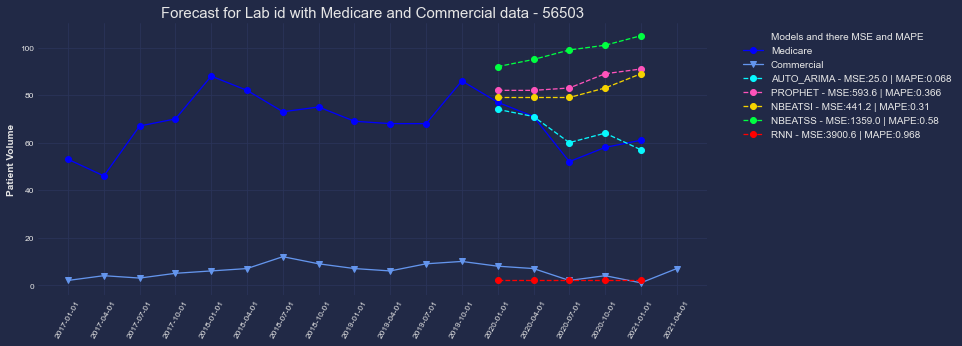

In [104]:
import random
import mplcyberpunk
import plotly.tools as tls

def getRandomID():
    rand_id = []
    for id_list in [lm_with_lc,pm_with_pc,only_lm,only_pm]:
        rand_id.extend(random.sample(list(id_list),5))
    return rand_id

def getRightData(name,data,index):    
    data_df = pd.DataFrame()
    if name == 'PROPHET':
        data_df= data[['ds','yhat']]
        data_df = data_df.reset_index(drop=True)
        data_df.columns=['date','volume']
        data_df['date'] = data_df['date'].astype(str)
        data_df = data_df.set_index('date')
        data_df.index=index
    elif name == 'AUTO_ARIMA':
        data_df = data.copy()
        data_df.columns = ['volume']
    else:
        data_df = data.reset_index(drop=True)
        data_df.index=index
    return data_df
    
def plotPredictComparision():
    for id in [56503]:
        plt.figure(figsize=(12,5))
#         plt.style.use("seaborn-muted")
        plt.style.use("cyberpunk")
        if id in lm_with_lc:
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='L')&(data_copy4.type=='M')]['volume'],
                    marker='o',label="Medicare",color='blue')
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='L')&(data_copy4.type=='C')]['volume'],
                    marker='v',label="Commercial",color='cornflowerblue')
            title = f'Forecast for Lab id with Medicare and Commercial data - {id}'
        elif id in pm_with_pc:
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='P')&(data_copy4.type=='M')]['volume'],
                    marker='o')
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='P')&(data_copy4.type=='C')]['volume'],
                    marker='o')
            title = f'Forecast for Physician id with Medicare and Commercial data - {id}'
        elif id in only_lm:
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='L')&(data_copy4.type=='M')]['volume'],
                    marker='o')
            title = f'Forecast for Lab id with only Medicare - {id}'
        else:
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='P')&(data_copy4.type=='M')]['volume'],
                    marker='o')
            title = f'Forecast for Physician id with only Medicare - {id}'
            
        plt.title(title, fontsize=15)

        pkl_list = {'AUTO_ARIMA':autoArima_pk_df,'PROPHET':prophet_pk_df,
                'NBEATSI':nbeatsI_pk_df,'NBEATSS':nbeatsSingle_pk_df,'RNN':rnn_pk_df}
#         pkl_list = {'NBEATSI':nbeatsI_pk_df}
        index = autoArima_pkl[id]['predict'].index
        for name,model in pkl_list.items():
            prediction = getRightData(name, model[id]['predict'].copy(),index)
            mse=np.round(model[id]['best_mse'],3)
            mape=np.round(model[id]['best_mape'],3)
            plt.plot(prediction,"--",marker='o',label=f"{name} - MSE:{mse} | MAPE:{mape}")
        plt.xticks(rotation=60)
        plt.ylabel("Patient Volume")
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",title="Models and there MSE and MAPE",fontsize='medium')
#         mplcyberpunk.make_lines_glow()
        plt.show()
        
plotPredictComparision()

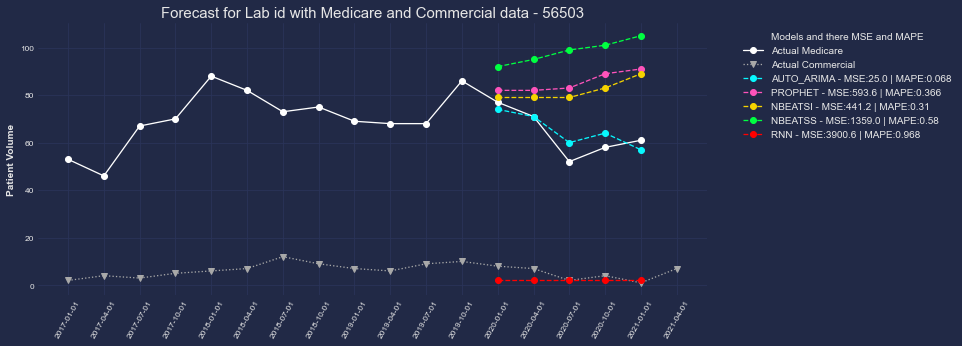

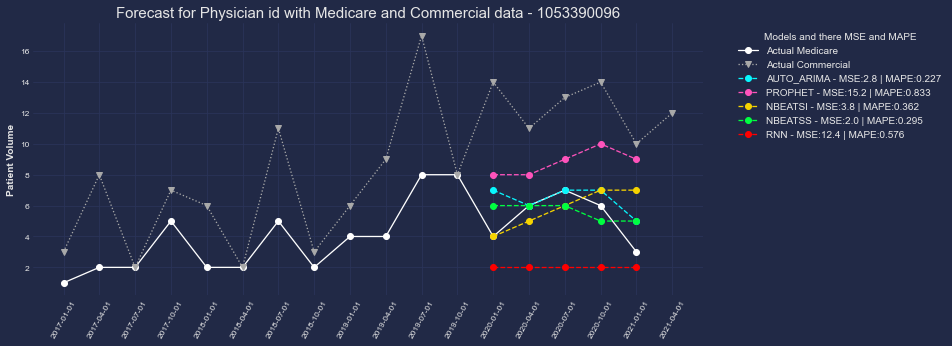

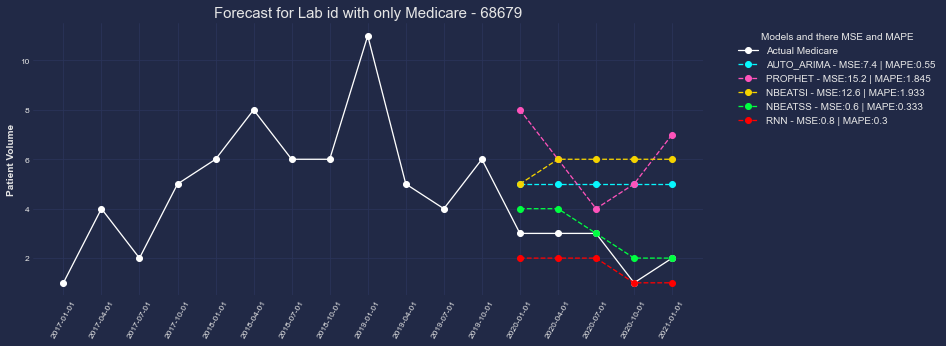

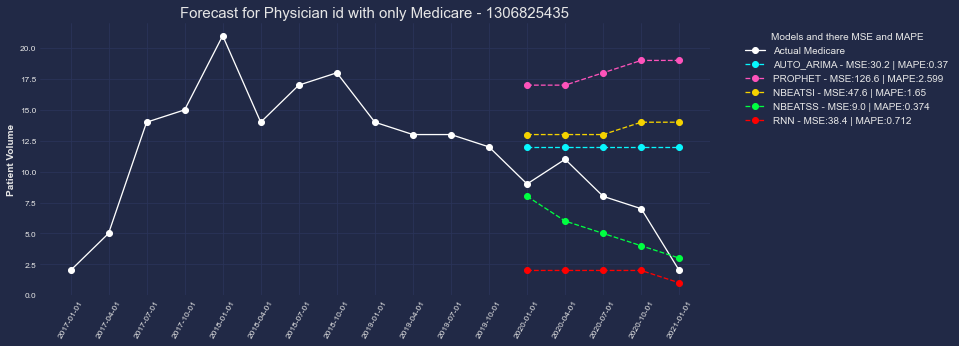

In [136]:
import random
import mplcyberpunk
import plotly.tools as tls

def getRandomID():
    rand_id = []
    for id_list in [lm_with_lc,pm_with_pc,only_lm,only_pm]:
        rand_id.extend(random.sample(list(id_list),5))
    return rand_id

def getRightData(name,data,index):    
    data_df = pd.DataFrame()
    if name == 'PROPHET':
        data_df= data[['ds','yhat']]
        data_df = data_df.reset_index(drop=True)
        data_df.columns=['date','volume']
        data_df['date'] = data_df['date'].astype(str)
        data_df = data_df.set_index('date')
        data_df.index=index
    elif name == 'AUTO_ARIMA':
        data_df = data.copy()
        data_df.columns = ['volume']
    else:
        data_df = data.reset_index(drop=True)
        data_df.index=index
    return data_df
    
def plotPredictComparision():
    for id in [56503,1053390096,68679,1306825435]:
        plt.figure(figsize=(12,5))
        plt.style.use("cyberpunk")
        if id in lm_with_lc:
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='L')&(data_copy4.type=='M')]['volume'],
                    marker='o',label="Actual Medicare",color='white')
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='L')&(data_copy4.type=='C')]['volume'],
                    ":",marker='v',label="Actual Commercial",color='darkgray')
            title = f'Forecast for Lab id with Medicare and Commercial data - {id}'
        elif id in pm_with_pc:
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='P')&(data_copy4.type=='M')]['volume'],
                    marker='o',label="Actual Medicare",color='white')
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='P')&(data_copy4.type=='C')]['volume'],
                    ":",marker='v',label="Actual Commercial",color='darkgray')
            title = f'Forecast for Physician id with Medicare and Commercial data - {id}'
        elif id in only_lm:
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='L')&(data_copy4.type=='M')]['volume'],
                    marker='o',label="Actual Medicare",color='white')
            title = f'Forecast for Lab id with only Medicare - {id}'
        else:
            plt.plot(data_copy4[(data_copy4.id==id)&(data_copy4.source=='P')&(data_copy4.type=='M')]['volume'],
                    marker='o',label="Actual Medicare",color='white')
            title = f'Forecast for Physician id with only Medicare - {id}'
            
        plt.title(title, fontsize=15)

        pkl_list = {'AUTO_ARIMA':autoArima_pk_df,'PROPHET':prophet_pk_df,
                'NBEATSI':nbeatsI_pk_df,'NBEATSS':nbeatsSingle_pk_df,'RNN':rnn_pk_df}
#         pkl_list = {'NBEATSI':nbeatsI_pk_df}
        index = autoArima_pkl[id]['predict'].index
        for name,model in pkl_list.items():
            prediction = getRightData(name, model[id]['predict'].copy(),index)
            mse=np.round(model[id]['best_mse'],3)
            mape=np.round(model[id]['best_mape'],3)
            plt.plot(prediction,"--",marker='o',label=f"{name} - MSE:{mse} | MAPE:{mape}")
        plt.xticks(rotation=60)
        plt.ylabel("Patient Volume")
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",title="Models and there MSE and MAPE",fontsize='medium')
#         mplcyberpunk.make_lines_glow()
        plt.show()
        
plotPredictComparision()